# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=1, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  RUL  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9  ...     s12      s13      s14     s15  s17    s20      s21  RUL  \
0  9046.19  ...  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191   
1  9044.07  ...  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190   
2  9052.94  ...  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189   
3  9049.48  ...  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188   
4  9055.15  ...  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1   1      2  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2   1      3  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3   1      4  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4   1      5  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.242424  0.109755  ...  0.205882  0.199608  0.363986  0.333333  0.713178   
1  0.212121  0.100242  ...  0.279412  0.162813  0.411312  0.333333  0.666667   
2  0.272727  0.140043  ...  0.220588  0.171793  0.357445  0.166667  0.627907   
3  0.318182  0.124518  ...  0.294118  0.174889  0.166603  0.333333  0.573643   
4  0.242424  0.149960  ...  0.235294  0.174734  0.402078  0.416667  0.589147   

        s21  RUL  label1  label2  cycle_norm  
0  0.724662  191      -1      -1     0.00000  
1  0.731014  190      -1      -1     0.00277  
2  0.621375  189      -1      -1     0.00554  
3  0.662386  188      -1      -1     0.00831  
4  0.704502  187      -1      -1     0.01108  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(20631, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1    0.0023    0.0003  643.02  1585.29  1398.21  553.90  2388.04   
1   1      2   -0.0027   -0.0003  641.71  1588.45  1395.42  554.85  2388.01   
2   1      3    0.0003    0.0001  642.46  1586.94  1401.34  554.11  2388.05   
3   1      4    0.0042    0.0000  642.44  1584.12  1406.42  554.07  2388.03   
4   1      5    0.0014    0.0000  642.51  1587.19  1401.92  554.16  2388.01   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9050.17  47.20  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735  
1  9054.42  47.50  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916  
2  9056.96  47.50  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166  
3  9045.29  47.28  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737  
4  9044.55  47.31  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0  112
1   98
2   69
3   82
4   91

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  
0  0.333333  0.558140  0.661834     0.00000  
1  0.416667  0.682171  0.686827     0.00277  
2  0.416667  0.728682  0.721348     0.00554  
3  0.250000  0.666667  0.662110     0.00831  
4  0.166667  0.658915  0.716377     0.01108

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  142  
1  0.416667  0.682171  0.686827     0.00277  141  
2  0.416667  0.728682  0.721348     0.00554  140  
3  0.250000  0.666667  0.662110     0.00831  139  
4  0.166667  0.658915  0.716377     0.01108  138

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  100  
1  0.416667  0.682171  0.686827     0.00277  100  
2  0.416667  0.728682  0.721348     0.00554  100  
3  0.250000  0.666667  0.662110     0.00831  100  
4  0.166667  0.658915  0.716377     0.01108  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(13096, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

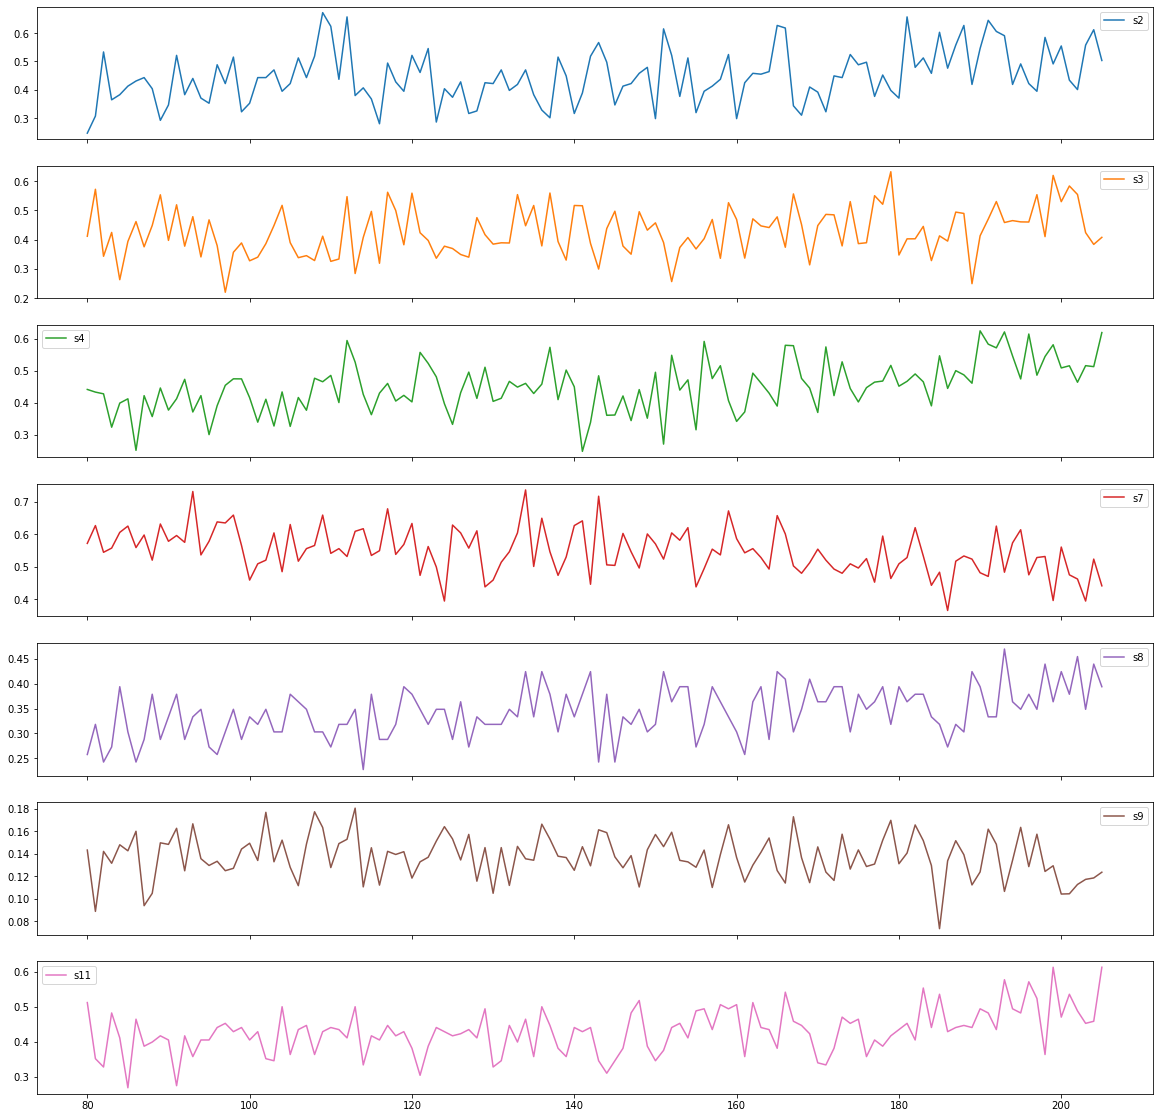

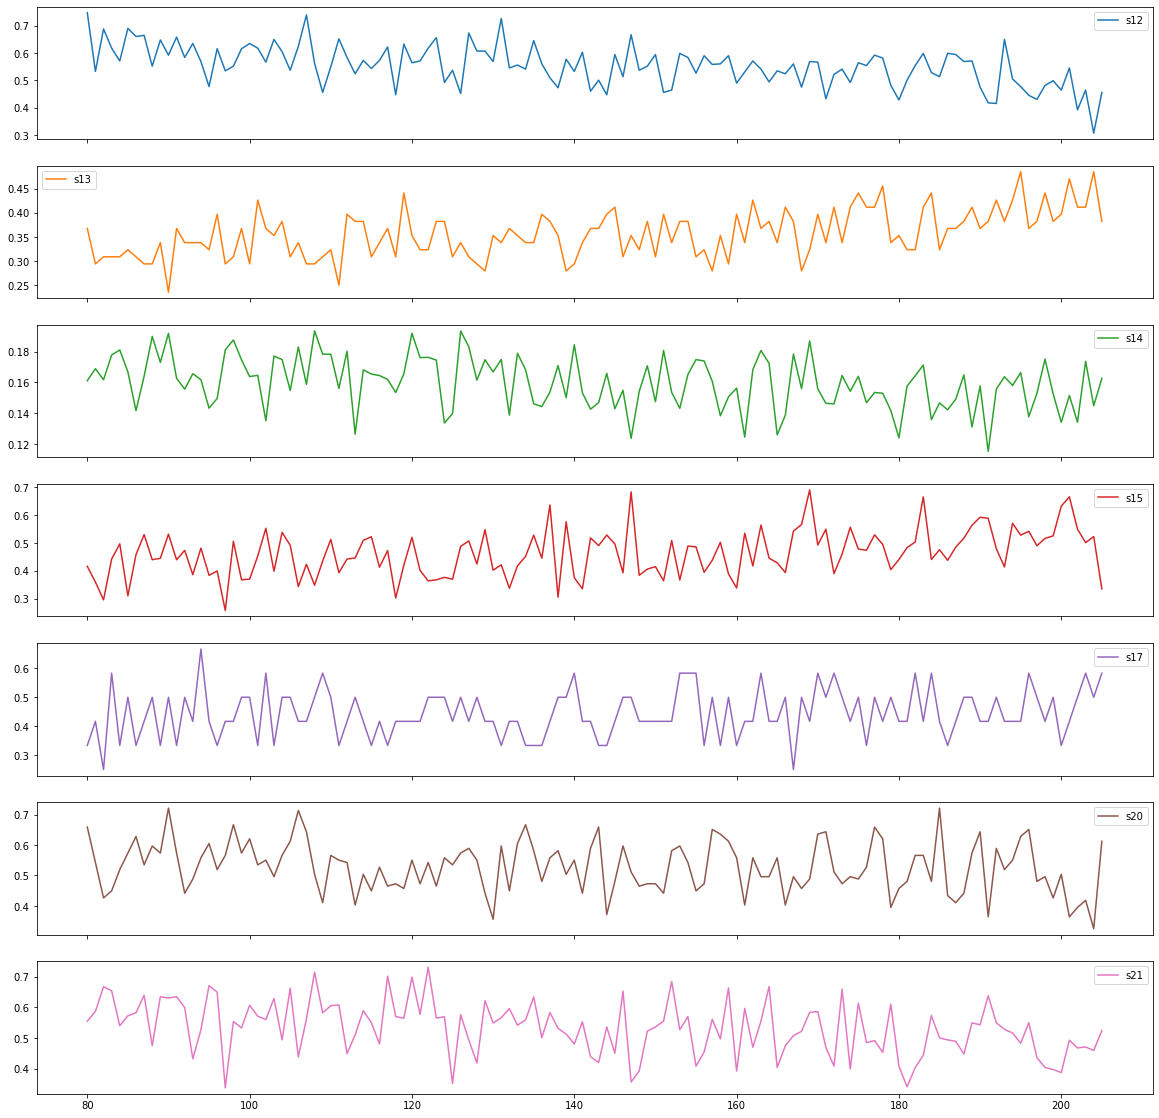

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\alibei\AppData\Local\Temp/ipykernel_2796/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

100
100
100
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\alibei\AppData\Local\Temp/ipykernel_2796/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

56
56
56
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Number of iteration: 1 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.42]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Number of iteration: 2 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 7

Epoch 0 	Batch: 50 - 75 	Loss: [114.63]
Epoch 0 	Batch: 50 - 75 	Loss: [114.69]
Epoch 0 	Batch: 50 - 75 	Loss: [114.63]
Epoch 0 	Batch: 50 - 75 	Loss: [114.64]
Epoch 0 	Batch: 50 - 75 	Loss: [114.57]
Epoch 0 	Batch: 50 - 75 	Loss: [114.81]
Epoch 0 	Batch: 50 - 75 	Loss: [114.69]
Epoch 0 	Batch: 50 - 75 	Loss: [114.78]
Epoch 0 	Batch: 50 - 75 	Loss: [114.68]
Epoch 0 	Batch: 50 - 75 	Loss: [114.59]
Number of iteration: 20 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.59]
Epoch 0 	Batch: 50 - 75 	Loss: [114.63]
Epoch 0 	Batch: 50 - 75 	Loss: [114.59]
Epoch 0 	Batch: 50 - 75 	Loss: [114.58]
Epoch 0 	Batch: 50 - 75 	Loss: [114.5]
Epoch 0 	Batch: 50 - 75 	Loss: [114.76]
Epoch 0 	Batch: 50 - 75 	Loss: [114.64]
Epoch 0 	Batch: 50 - 75 	Loss: [114.72]
Epoch 0 	Batch: 50 - 75 	Loss: [114.61]
Epoch 0 	Batch: 50 - 75 	Loss: [114.53]
Number of iteration: 21 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.57]
Epoch 0 	Batch: 50 - 75 	Loss: [114.56]
Epoch 0 	Batch: 50 - 75 	Loss: [114.56]
Epoch 0 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [113.37]
Epoch 0 	Batch: 50 - 75 	Loss: [113.39]
Epoch 0 	Batch: 50 - 75 	Loss: [113.31]
Epoch 0 	Batch: 50 - 75 	Loss: [113.25]
Epoch 0 	Batch: 50 - 75 	Loss: [113.23]
Epoch 0 	Batch: 50 - 75 	Loss: [114.01]
Epoch 0 	Batch: 50 - 75 	Loss: [113.43]
Epoch 0 	Batch: 50 - 75 	Loss: [113.66]
Epoch 0 	Batch: 50 - 75 	Loss: [113.3]
Epoch 0 	Batch: 50 - 75 	Loss: [113.19]
Number of iteration: 39 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.27]
Epoch 0 	Batch: 50 - 75 	Loss: [113.3]
Epoch 0 	Batch: 50 - 75 	Loss: [113.22]
Epoch 0 	Batch: 50 - 75 	Loss: [113.16]
Epoch 0 	Batch: 50 - 75 	Loss: [113.13]
Epoch 0 	Batch: 50 - 75 	Loss: [113.96]
Epoch 0 	Batch: 50 - 75 	Loss: [113.34]
Epoch 0 	Batch: 50 - 75 	Loss: [113.59]
Epoch 0 	Batch: 50 - 75 	Loss: [113.22]
Epoch 0 	Batch: 50 - 75 	Loss: [113.1]
Number of iteration: 40 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.17]
Epoch 0 	Batch: 50 - 75 	Loss: [113.21]
Epoch 0 	Batch: 50 - 75 	Loss: [113.12]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [111.51]
Epoch 0 	Batch: 50 - 75 	Loss: [111.32]
Epoch 0 	Batch: 50 - 75 	Loss: [111.34]
Epoch 0 	Batch: 50 - 75 	Loss: [111.32]
Epoch 0 	Batch: 50 - 75 	Loss: [112.76]
Epoch 0 	Batch: 50 - 75 	Loss: [111.58]
Epoch 0 	Batch: 50 - 75 	Loss: [112.03]
Epoch 0 	Batch: 50 - 75 	Loss: [111.37]
Epoch 0 	Batch: 50 - 75 	Loss: [111.21]
Number of iteration: 58 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [111.27]
Epoch 0 	Batch: 50 - 75 	Loss: [111.4]
Epoch 0 	Batch: 50 - 75 	Loss: [111.2]
Epoch 0 	Batch: 50 - 75 	Loss: [111.22]
Epoch 0 	Batch: 50 - 75 	Loss: [111.2]
Epoch 0 	Batch: 50 - 75 	Loss: [112.66]
Epoch 0 	Batch: 50 - 75 	Loss: [111.47]
Epoch 0 	Batch: 50 - 75 	Loss: [111.92]
Epoch 0 	Batch: 50 - 75 	Loss: [111.25]
Epoch 0 	Batch: 50 - 75 	Loss: [111.09]
Number of iteration: 59 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [111.15]
Epoch 0 	Batch: 50 - 75 	Loss: [111.29]
Epoch 0 	Batch: 50 - 75 	Loss: [111.07]
Epoch 0 	Batch: 50 - 75 	Loss: [111.1]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [109.12]
Epoch 0 	Batch: 50 - 75 	Loss: [109.13]
Epoch 0 	Batch: 50 - 75 	Loss: [109.18]
Epoch 0 	Batch: 50 - 75 	Loss: [111.21]
Epoch 0 	Batch: 50 - 75 	Loss: [109.57]
Epoch 0 	Batch: 50 - 75 	Loss: [110.16]
Epoch 0 	Batch: 50 - 75 	Loss: [109.22]
Epoch 0 	Batch: 50 - 75 	Loss: [109.02]
Number of iteration: 77 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [109.08]
Epoch 0 	Batch: 50 - 75 	Loss: [109.34]
Epoch 0 	Batch: 50 - 75 	Loss: [109.]
Epoch 0 	Batch: 50 - 75 	Loss: [109.01]
Epoch 0 	Batch: 50 - 75 	Loss: [109.04]
Epoch 0 	Batch: 50 - 75 	Loss: [111.1]
Epoch 0 	Batch: 50 - 75 	Loss: [109.45]
Epoch 0 	Batch: 50 - 75 	Loss: [110.05]
Epoch 0 	Batch: 50 - 75 	Loss: [109.11]
Epoch 0 	Batch: 50 - 75 	Loss: [108.89]
Number of iteration: 78 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [108.96]
Epoch 0 	Batch: 50 - 75 	Loss: [109.22]
Epoch 0 	Batch: 50 - 75 	Loss: [108.88]
Epoch 0 	Batch: 50 - 75 	Loss: [108.89]
Epoch 0 	Batch: 50 - 75 	Loss: [108.93]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [106.75]
Epoch 0 	Batch: 50 - 75 	Loss: [106.77]
Epoch 0 	Batch: 50 - 75 	Loss: [106.91]
Epoch 0 	Batch: 50 - 75 	Loss: [109.35]
Epoch 0 	Batch: 50 - 75 	Loss: [107.36]
Epoch 0 	Batch: 50 - 75 	Loss: [108.03]
Epoch 0 	Batch: 50 - 75 	Loss: [106.94]
Epoch 0 	Batch: 50 - 75 	Loss: [106.66]
Number of iteration: 96 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [106.71]
Epoch 0 	Batch: 50 - 75 	Loss: [107.13]
Epoch 0 	Batch: 50 - 75 	Loss: [106.62]
Epoch 0 	Batch: 50 - 75 	Loss: [106.65]
Epoch 0 	Batch: 50 - 75 	Loss: [106.77]
Epoch 0 	Batch: 50 - 75 	Loss: [109.23]
Epoch 0 	Batch: 50 - 75 	Loss: [107.23]
Epoch 0 	Batch: 50 - 75 	Loss: [107.91]
Epoch 0 	Batch: 50 - 75 	Loss: [106.81]
Epoch 0 	Batch: 50 - 75 	Loss: [106.53]
Number of iteration: 97 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [106.57]
Epoch 0 	Batch: 50 - 75 	Loss: [107.]
Epoch 0 	Batch: 50 - 75 	Loss: [106.49]
Epoch 0 	Batch: 50 - 75 	Loss: [106.51]
Epoch 0 	Batch: 50 - 75 	Loss: [106.63]
Epoch 0 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [104.53]
Epoch 0 	Batch: 50 - 75 	Loss: [107.31]
Epoch 0 	Batch: 50 - 75 	Loss: [105.01]
Epoch 0 	Batch: 50 - 75 	Loss: [105.7]
Epoch 0 	Batch: 50 - 75 	Loss: [104.59]
Epoch 0 	Batch: 50 - 75 	Loss: [104.28]
Number of iteration: 115 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.33]
Epoch 0 	Batch: 50 - 75 	Loss: [104.78]
Epoch 0 	Batch: 50 - 75 	Loss: [104.19]
Epoch 0 	Batch: 50 - 75 	Loss: [104.27]
Epoch 0 	Batch: 50 - 75 	Loss: [104.41]
Epoch 0 	Batch: 50 - 75 	Loss: [107.23]
Epoch 0 	Batch: 50 - 75 	Loss: [104.9]
Epoch 0 	Batch: 50 - 75 	Loss: [105.59]
Epoch 0 	Batch: 50 - 75 	Loss: [104.47]
Epoch 0 	Batch: 50 - 75 	Loss: [104.15]
Number of iteration: 116 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [104.2]
Epoch 0 	Batch: 50 - 75 	Loss: [104.65]
Epoch 0 	Batch: 50 - 75 	Loss: [104.07]
Epoch 0 	Batch: 50 - 75 	Loss: [104.16]
Epoch 0 	Batch: 50 - 75 	Loss: [104.28]
Epoch 0 	Batch: 50 - 75 	Loss: [107.12]
Epoch 0 	Batch: 50 - 75 	Loss: [104.78]
Epoch 0 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [102.67]
Epoch 0 	Batch: 50 - 75 	Loss: [103.38]
Epoch 0 	Batch: 50 - 75 	Loss: [102.24]
Epoch 0 	Batch: 50 - 75 	Loss: [101.83]
Number of iteration: 134 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [101.87]
Epoch 0 	Batch: 50 - 75 	Loss: [102.38]
Epoch 0 	Batch: 50 - 75 	Loss: [101.71]
Epoch 0 	Batch: 50 - 75 	Loss: [101.85]
Epoch 0 	Batch: 50 - 75 	Loss: [101.97]
Epoch 0 	Batch: 50 - 75 	Loss: [105.11]
Epoch 0 	Batch: 50 - 75 	Loss: [102.54]
Epoch 0 	Batch: 50 - 75 	Loss: [103.25]
Epoch 0 	Batch: 50 - 75 	Loss: [102.11]
Epoch 0 	Batch: 50 - 75 	Loss: [101.69]
Number of iteration: 135 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [101.73]
Epoch 0 	Batch: 50 - 75 	Loss: [102.24]
Epoch 0 	Batch: 50 - 75 	Loss: [101.58]
Epoch 0 	Batch: 50 - 75 	Loss: [101.71]
Epoch 0 	Batch: 50 - 75 	Loss: [101.83]
Epoch 0 	Batch: 50 - 75 	Loss: [104.99]
Epoch 0 	Batch: 50 - 75 	Loss: [102.4]
Epoch 0 	Batch: 50 - 75 	Loss: [103.12]
Epoch 0 	Batch: 50 - 75 	Loss: [101.98]
Epoch 0 	

Epoch 0 	Batch: 50 - 75 	Loss: [103.02]
Epoch 0 	Batch: 50 - 75 	Loss: [100.29]
Epoch 0 	Batch: 50 - 75 	Loss: [101.04]
Epoch 0 	Batch: 50 - 75 	Loss: [99.83]
Epoch 0 	Batch: 50 - 75 	Loss: [99.36]
Number of iteration: 153 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [99.45]
Epoch 0 	Batch: 50 - 75 	Loss: [99.97]
Epoch 0 	Batch: 50 - 75 	Loss: [99.24]
Epoch 0 	Batch: 50 - 75 	Loss: [99.5]
Epoch 0 	Batch: 50 - 75 	Loss: [99.65]
Epoch 0 	Batch: 50 - 75 	Loss: [102.89]
Epoch 0 	Batch: 50 - 75 	Loss: [100.16]
Epoch 0 	Batch: 50 - 75 	Loss: [100.91]
Epoch 0 	Batch: 50 - 75 	Loss: [99.7]
Epoch 0 	Batch: 50 - 75 	Loss: [99.22]
Number of iteration: 154 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [99.31]
Epoch 0 	Batch: 50 - 75 	Loss: [99.84]
Epoch 0 	Batch: 50 - 75 	Loss: [99.1]
Epoch 0 	Batch: 50 - 75 	Loss: [99.36]
Epoch 0 	Batch: 50 - 75 	Loss: [99.52]
Epoch 0 	Batch: 50 - 75 	Loss: [102.77]
Epoch 0 	Batch: 50 - 75 	Loss: [100.02]
Epoch 0 	Batch: 50 - 75 	Loss: [100.77]
Epoch 0 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [96.84]
Epoch 0 	Batch: 50 - 75 	Loss: [97.23]
Epoch 0 	Batch: 50 - 75 	Loss: [97.39]
Epoch 0 	Batch: 50 - 75 	Loss: [100.68]
Epoch 0 	Batch: 50 - 75 	Loss: [97.85]
Epoch 0 	Batch: 50 - 75 	Loss: [98.61]
Epoch 0 	Batch: 50 - 75 	Loss: [97.36]
Epoch 0 	Batch: 50 - 75 	Loss: [96.83]
Number of iteration: 173 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [96.97]
Epoch 0 	Batch: 50 - 75 	Loss: [97.52]
Epoch 0 	Batch: 50 - 75 	Loss: [96.72]
Epoch 0 	Batch: 50 - 75 	Loss: [97.13]
Epoch 0 	Batch: 50 - 75 	Loss: [97.27]
Epoch 0 	Batch: 50 - 75 	Loss: [100.58]
Epoch 0 	Batch: 50 - 75 	Loss: [97.73]
Epoch 0 	Batch: 50 - 75 	Loss: [98.49]
Epoch 0 	Batch: 50 - 75 	Loss: [97.24]
Epoch 0 	Batch: 50 - 75 	Loss: [96.71]
Number of iteration: 174 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [96.88]
Epoch 0 	Batch: 50 - 75 	Loss: [97.4]
Epoch 0 	Batch: 50 - 75 	Loss: [96.61]
Epoch 0 	Batch: 50 - 75 	Loss: [97.01]
Epoch 0 	Batch: 50 - 75 	Loss: [97.15]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [94.68]
Number of iteration: 192 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [94.86]
Epoch 0 	Batch: 50 - 75 	Loss: [95.37]
Epoch 0 	Batch: 50 - 75 	Loss: [94.57]
Epoch 0 	Batch: 50 - 75 	Loss: [95.]
Epoch 0 	Batch: 50 - 75 	Loss: [95.12]
Epoch 0 	Batch: 50 - 75 	Loss: [98.59]
Epoch 0 	Batch: 50 - 75 	Loss: [95.58]
Epoch 0 	Batch: 50 - 75 	Loss: [96.36]
Epoch 0 	Batch: 50 - 75 	Loss: [95.14]
Epoch 0 	Batch: 50 - 75 	Loss: [94.55]
Number of iteration: 193 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [94.74]
Epoch 0 	Batch: 50 - 75 	Loss: [95.25]
Epoch 0 	Batch: 50 - 75 	Loss: [94.44]
Epoch 0 	Batch: 50 - 75 	Loss: [94.87]
Epoch 0 	Batch: 50 - 75 	Loss: [95.02]
Epoch 0 	Batch: 50 - 75 	Loss: [98.49]
Epoch 0 	Batch: 50 - 75 	Loss: [95.47]
Epoch 0 	Batch: 50 - 75 	Loss: [96.24]
Epoch 0 	Batch: 50 - 75 	Loss: [95.02]
Epoch 0 	Batch: 50 - 75 	Loss: [94.44]
Number of iteration: 194 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [94.61]
Epoch 0 	Batch: 50 - 75 	Loss: [95.1

Epoch 0 	Batch: 50 - 75 	Loss: [93.23]
Epoch 0 	Batch: 50 - 75 	Loss: [94.02]
Epoch 0 	Batch: 50 - 75 	Loss: [92.83]
Epoch 0 	Batch: 50 - 75 	Loss: [92.26]
Number of iteration: 212 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [92.43]
Epoch 0 	Batch: 50 - 75 	Loss: [93.]
Epoch 0 	Batch: 50 - 75 	Loss: [92.12]
Epoch 0 	Batch: 50 - 75 	Loss: [92.59]
Epoch 0 	Batch: 50 - 75 	Loss: [92.82]
Epoch 0 	Batch: 50 - 75 	Loss: [96.24]
Epoch 0 	Batch: 50 - 75 	Loss: [93.12]
Epoch 0 	Batch: 50 - 75 	Loss: [93.92]
Epoch 0 	Batch: 50 - 75 	Loss: [92.71]
Epoch 0 	Batch: 50 - 75 	Loss: [92.14]
Number of iteration: 213 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [92.34]
Epoch 0 	Batch: 50 - 75 	Loss: [92.89]
Epoch 0 	Batch: 50 - 75 	Loss: [92.]
Epoch 0 	Batch: 50 - 75 	Loss: [92.47]
Epoch 0 	Batch: 50 - 75 	Loss: [92.74]
Epoch 0 	Batch: 50 - 75 	Loss: [96.14]
Epoch 0 	Batch: 50 - 75 	Loss: [93.01]
Epoch 0 	Batch: 50 - 75 	Loss: [93.8]
Epoch 0 	Batch: 50 - 75 	Loss: [92.6]
Epoch 0 	Batch: 50 - 75 	Loss: [92.04

Epoch 0 	Batch: 50 - 75 	Loss: [90.83]
Epoch 0 	Batch: 50 - 75 	Loss: [94.15]
Epoch 0 	Batch: 50 - 75 	Loss: [91.]
Epoch 0 	Batch: 50 - 75 	Loss: [91.73]
Epoch 0 	Batch: 50 - 75 	Loss: [90.63]
Epoch 0 	Batch: 50 - 75 	Loss: [90.09]
Number of iteration: 232 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [90.44]
Epoch 0 	Batch: 50 - 75 	Loss: [90.87]
Epoch 0 	Batch: 50 - 75 	Loss: [89.97]
Epoch 0 	Batch: 50 - 75 	Loss: [90.61]
Epoch 0 	Batch: 50 - 75 	Loss: [90.83]
Epoch 0 	Batch: 50 - 75 	Loss: [94.14]
Epoch 0 	Batch: 50 - 75 	Loss: [91.]
Epoch 0 	Batch: 50 - 75 	Loss: [91.71]
Epoch 0 	Batch: 50 - 75 	Loss: [90.57]
Epoch 0 	Batch: 50 - 75 	Loss: [90.1]
Number of iteration: 233 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [90.33]
Epoch 0 	Batch: 50 - 75 	Loss: [90.75]
Epoch 0 	Batch: 50 - 75 	Loss: [89.89]
Epoch 0 	Batch: 50 - 75 	Loss: [90.5]
Epoch 0 	Batch: 50 - 75 	Loss: [90.72]
Epoch 0 	Batch: 50 - 75 	Loss: [94.04]
Epoch 0 	Batch: 50 - 75 	Loss: [90.89]
Epoch 0 	Batch: 50 - 75 	Loss: [91.6]

Epoch 0 	Batch: 50 - 75 	Loss: [88.32]
Number of iteration: 251 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [88.67]
Epoch 0 	Batch: 50 - 75 	Loss: [88.98]
Epoch 0 	Batch: 50 - 75 	Loss: [88.17]
Epoch 0 	Batch: 50 - 75 	Loss: [88.77]
Epoch 0 	Batch: 50 - 75 	Loss: [88.98]
Epoch 0 	Batch: 50 - 75 	Loss: [92.36]
Epoch 0 	Batch: 50 - 75 	Loss: [89.09]
Epoch 0 	Batch: 50 - 75 	Loss: [89.8]
Epoch 0 	Batch: 50 - 75 	Loss: [88.77]
Epoch 0 	Batch: 50 - 75 	Loss: [88.2]
Number of iteration: 252 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [88.58]
Epoch 0 	Batch: 50 - 75 	Loss: [88.89]
Epoch 0 	Batch: 50 - 75 	Loss: [88.07]
Epoch 0 	Batch: 50 - 75 	Loss: [88.67]
Epoch 0 	Batch: 50 - 75 	Loss: [88.91]
Epoch 0 	Batch: 50 - 75 	Loss: [92.27]
Epoch 0 	Batch: 50 - 75 	Loss: [88.99]
Epoch 0 	Batch: 50 - 75 	Loss: [89.69]
Epoch 0 	Batch: 50 - 75 	Loss: [88.66]
Epoch 0 	Batch: 50 - 75 	Loss: [88.12]
Number of iteration: 253 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [88.48]
Epoch 0 	Batch: 50 - 75 	Loss: [88.7

Epoch 0 	Batch: 50 - 75 	Loss: [87.35]
Epoch 0 	Batch: 50 - 75 	Loss: [90.6]
Epoch 0 	Batch: 50 - 75 	Loss: [87.28]
Epoch 0 	Batch: 50 - 75 	Loss: [87.97]
Epoch 0 	Batch: 50 - 75 	Loss: [87.03]
Epoch 0 	Batch: 50 - 75 	Loss: [86.47]
Number of iteration: 271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [86.86]
Epoch 0 	Batch: 50 - 75 	Loss: [87.11]
Epoch 0 	Batch: 50 - 75 	Loss: [86.32]
Epoch 0 	Batch: 50 - 75 	Loss: [87.01]
Epoch 0 	Batch: 50 - 75 	Loss: [87.25]
Epoch 0 	Batch: 50 - 75 	Loss: [90.5]
Epoch 0 	Batch: 50 - 75 	Loss: [87.18]
Epoch 0 	Batch: 50 - 75 	Loss: [87.87]
Epoch 0 	Batch: 50 - 75 	Loss: [86.94]
Epoch 0 	Batch: 50 - 75 	Loss: [86.37]
Number of iteration: 272 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [86.77]
Epoch 0 	Batch: 50 - 75 	Loss: [87.01]
Epoch 0 	Batch: 50 - 75 	Loss: [86.21]
Epoch 0 	Batch: 50 - 75 	Loss: [86.91]
Epoch 0 	Batch: 50 - 75 	Loss: [87.16]
Epoch 0 	Batch: 50 - 75 	Loss: [90.4]
Epoch 0 	Batch: 50 - 75 	Loss: [87.07]
Epoch 0 	Batch: 50 - 75 	Loss: [87

Epoch 0 	Batch: 50 - 75 	Loss: [85.16]
Epoch 0 	Batch: 50 - 75 	Loss: [84.59]
Number of iteration: 290 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [85.04]
Epoch 0 	Batch: 50 - 75 	Loss: [85.27]
Epoch 0 	Batch: 50 - 75 	Loss: [84.42]
Epoch 0 	Batch: 50 - 75 	Loss: [85.22]
Epoch 0 	Batch: 50 - 75 	Loss: [85.51]
Epoch 0 	Batch: 50 - 75 	Loss: [88.69]
Epoch 0 	Batch: 50 - 75 	Loss: [85.34]
Epoch 0 	Batch: 50 - 75 	Loss: [85.99]
Epoch 0 	Batch: 50 - 75 	Loss: [85.05]
Epoch 0 	Batch: 50 - 75 	Loss: [84.5]
Number of iteration: 291 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [84.92]
Epoch 0 	Batch: 50 - 75 	Loss: [85.18]
Epoch 0 	Batch: 50 - 75 	Loss: [84.31]
Epoch 0 	Batch: 50 - 75 	Loss: [85.12]
Epoch 0 	Batch: 50 - 75 	Loss: [85.43]
Epoch 0 	Batch: 50 - 75 	Loss: [88.59]
Epoch 0 	Batch: 50 - 75 	Loss: [85.25]
Epoch 0 	Batch: 50 - 75 	Loss: [85.88]
Epoch 0 	Batch: 50 - 75 	Loss: [84.94]
Epoch 0 	Batch: 50 - 75 	Loss: [84.39]
Number of iteration: 292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [84.

Epoch 0 	Batch: 50 - 75 	Loss: [83.7]
Epoch 0 	Batch: 50 - 75 	Loss: [82.83]
Epoch 0 	Batch: 50 - 75 	Loss: [83.84]
Epoch 0 	Batch: 50 - 75 	Loss: [84.12]
Epoch 0 	Batch: 50 - 75 	Loss: [87.2]
Epoch 0 	Batch: 50 - 75 	Loss: [83.79]
Epoch 0 	Batch: 50 - 75 	Loss: [84.37]
Epoch 0 	Batch: 50 - 75 	Loss: [83.45]
Epoch 0 	Batch: 50 - 75 	Loss: [82.92]
Number of iteration: 310 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [83.47]
Epoch 0 	Batch: 50 - 75 	Loss: [83.64]
Epoch 0 	Batch: 50 - 75 	Loss: [82.73]
Epoch 0 	Batch: 50 - 75 	Loss: [83.74]
Epoch 0 	Batch: 50 - 75 	Loss: [84.09]
Epoch 0 	Batch: 50 - 75 	Loss: [87.12]
Epoch 0 	Batch: 50 - 75 	Loss: [83.74]
Epoch 0 	Batch: 50 - 75 	Loss: [84.3]
Epoch 0 	Batch: 50 - 75 	Loss: [83.36]
Epoch 0 	Batch: 50 - 75 	Loss: [82.84]
Number of iteration: 311 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [83.37]
Epoch 0 	Batch: 50 - 75 	Loss: [83.54]
Epoch 0 	Batch: 50 - 75 	Loss: [82.64]
Epoch 0 	Batch: 50 - 75 	Loss: [83.64]
Epoch 0 	Batch: 50 - 75 	Loss: [83

Epoch 0 	Batch: 50 - 75 	Loss: [82.43]
Epoch 0 	Batch: 50 - 75 	Loss: [83.12]
Epoch 0 	Batch: 50 - 75 	Loss: [82.03]
Epoch 0 	Batch: 50 - 75 	Loss: [81.44]
Number of iteration: 329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [82.1]
Epoch 0 	Batch: 50 - 75 	Loss: [82.24]
Epoch 0 	Batch: 50 - 75 	Loss: [81.31]
Epoch 0 	Batch: 50 - 75 	Loss: [82.34]
Epoch 0 	Batch: 50 - 75 	Loss: [82.83]
Epoch 0 	Batch: 50 - 75 	Loss: [85.6]
Epoch 0 	Batch: 50 - 75 	Loss: [82.34]
Epoch 0 	Batch: 50 - 75 	Loss: [83.04]
Epoch 0 	Batch: 50 - 75 	Loss: [81.99]
Epoch 0 	Batch: 50 - 75 	Loss: [81.39]
Number of iteration: 330 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [82.03]
Epoch 0 	Batch: 50 - 75 	Loss: [82.15]
Epoch 0 	Batch: 50 - 75 	Loss: [81.26]
Epoch 0 	Batch: 50 - 75 	Loss: [82.31]
Epoch 0 	Batch: 50 - 75 	Loss: [82.77]
Epoch 0 	Batch: 50 - 75 	Loss: [85.51]
Epoch 0 	Batch: 50 - 75 	Loss: [82.25]
Epoch 0 	Batch: 50 - 75 	Loss: [82.96]
Epoch 0 	Batch: 50 - 75 	Loss: [81.95]
Epoch 0 	Batch: 50 - 75 	Loss: [8

Epoch 0 	Batch: 50 - 75 	Loss: [83.97]
Epoch 0 	Batch: 50 - 75 	Loss: [80.8]
Epoch 0 	Batch: 50 - 75 	Loss: [81.42]
Epoch 0 	Batch: 50 - 75 	Loss: [80.51]
Epoch 0 	Batch: 50 - 75 	Loss: [79.76]
Number of iteration: 349 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [80.49]
Epoch 0 	Batch: 50 - 75 	Loss: [80.6]
Epoch 0 	Batch: 50 - 75 	Loss: [79.68]
Epoch 0 	Batch: 50 - 75 	Loss: [80.84]
Epoch 0 	Batch: 50 - 75 	Loss: [81.31]
Epoch 0 	Batch: 50 - 75 	Loss: [83.87]
Epoch 0 	Batch: 50 - 75 	Loss: [80.71]
Epoch 0 	Batch: 50 - 75 	Loss: [81.33]
Epoch 0 	Batch: 50 - 75 	Loss: [80.44]
Epoch 0 	Batch: 50 - 75 	Loss: [79.68]
Number of iteration: 350 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [80.4]
Epoch 0 	Batch: 50 - 75 	Loss: [80.52]
Epoch 0 	Batch: 50 - 75 	Loss: [79.61]
Epoch 0 	Batch: 50 - 75 	Loss: [80.76]
Epoch 0 	Batch: 50 - 75 	Loss: [81.22]
Epoch 0 	Batch: 50 - 75 	Loss: [83.78]
Epoch 0 	Batch: 50 - 75 	Loss: [80.62]
Epoch 0 	Batch: 50 - 75 	Loss: [81.25]
Epoch 0 	Batch: 50 - 75 	Loss: [80

Epoch 0 	Batch: 50 - 75 	Loss: [78.23]
Number of iteration: 368 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [79.04]
Epoch 0 	Batch: 50 - 75 	Loss: [79.19]
Epoch 0 	Batch: 50 - 75 	Loss: [78.23]
Epoch 0 	Batch: 50 - 75 	Loss: [79.26]
Epoch 0 	Batch: 50 - 75 	Loss: [80.02]
Epoch 0 	Batch: 50 - 75 	Loss: [82.27]
Epoch 0 	Batch: 50 - 75 	Loss: [79.22]
Epoch 0 	Batch: 50 - 75 	Loss: [79.81]
Epoch 0 	Batch: 50 - 75 	Loss: [79.05]
Epoch 0 	Batch: 50 - 75 	Loss: [78.16]
Number of iteration: 369 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [79.01]
Epoch 0 	Batch: 50 - 75 	Loss: [79.11]
Epoch 0 	Batch: 50 - 75 	Loss: [78.16]
Epoch 0 	Batch: 50 - 75 	Loss: [79.18]
Epoch 0 	Batch: 50 - 75 	Loss: [79.94]
Epoch 0 	Batch: 50 - 75 	Loss: [82.18]
Epoch 0 	Batch: 50 - 75 	Loss: [79.15]
Epoch 0 	Batch: 50 - 75 	Loss: [79.74]
Epoch 0 	Batch: 50 - 75 	Loss: [78.99]
Epoch 0 	Batch: 50 - 75 	Loss: [78.07]
Number of iteration: 370 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [78.95]
Epoch 0 	Batch: 50 - 75 	Loss: [79

Epoch 0 	Batch: 50 - 75 	Loss: [78.81]
Epoch 0 	Batch: 50 - 75 	Loss: [80.8]
Epoch 0 	Batch: 50 - 75 	Loss: [77.95]
Epoch 0 	Batch: 50 - 75 	Loss: [78.43]
Epoch 0 	Batch: 50 - 75 	Loss: [77.78]
Epoch 0 	Batch: 50 - 75 	Loss: [76.8]
Number of iteration: 388 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [77.78]
Epoch 0 	Batch: 50 - 75 	Loss: [77.83]
Epoch 0 	Batch: 50 - 75 	Loss: [76.78]
Epoch 0 	Batch: 50 - 75 	Loss: [77.75]
Epoch 0 	Batch: 50 - 75 	Loss: [78.73]
Epoch 0 	Batch: 50 - 75 	Loss: [80.72]
Epoch 0 	Batch: 50 - 75 	Loss: [77.87]
Epoch 0 	Batch: 50 - 75 	Loss: [78.35]
Epoch 0 	Batch: 50 - 75 	Loss: [77.7]
Epoch 0 	Batch: 50 - 75 	Loss: [76.73]
Number of iteration: 389 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [77.74]
Epoch 0 	Batch: 50 - 75 	Loss: [77.77]
Epoch 0 	Batch: 50 - 75 	Loss: [76.75]
Epoch 0 	Batch: 50 - 75 	Loss: [77.72]
Epoch 0 	Batch: 50 - 75 	Loss: [78.71]
Epoch 0 	Batch: 50 - 75 	Loss: [80.63]
Epoch 0 	Batch: 50 - 75 	Loss: [77.81]
Epoch 0 	Batch: 50 - 75 	Loss: [78

Epoch 0 	Batch: 50 - 75 	Loss: [76.7]
Epoch 0 	Batch: 50 - 75 	Loss: [75.77]
Number of iteration: 407 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [76.71]
Epoch 0 	Batch: 50 - 75 	Loss: [76.76]
Epoch 0 	Batch: 50 - 75 	Loss: [75.66]
Epoch 0 	Batch: 50 - 75 	Loss: [76.63]
Epoch 0 	Batch: 50 - 75 	Loss: [77.79]
Epoch 0 	Batch: 50 - 75 	Loss: [79.43]
Epoch 0 	Batch: 50 - 75 	Loss: [76.81]
Epoch 0 	Batch: 50 - 75 	Loss: [77.17]
Epoch 0 	Batch: 50 - 75 	Loss: [76.65]
Epoch 0 	Batch: 50 - 75 	Loss: [75.71]
Number of iteration: 408 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [76.63]
Epoch 0 	Batch: 50 - 75 	Loss: [76.71]
Epoch 0 	Batch: 50 - 75 	Loss: [75.57]
Epoch 0 	Batch: 50 - 75 	Loss: [76.54]
Epoch 0 	Batch: 50 - 75 	Loss: [77.75]
Epoch 0 	Batch: 50 - 75 	Loss: [79.38]
Epoch 0 	Batch: 50 - 75 	Loss: [76.77]
Epoch 0 	Batch: 50 - 75 	Loss: [77.12]
Epoch 0 	Batch: 50 - 75 	Loss: [76.57]
Epoch 0 	Batch: 50 - 75 	Loss: [75.64]
Number of iteration: 409 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [76.

Epoch 0 	Batch: 50 - 75 	Loss: [75.6]
Epoch 0 	Batch: 50 - 75 	Loss: [74.4]
Epoch 0 	Batch: 50 - 75 	Loss: [75.52]
Epoch 0 	Batch: 50 - 75 	Loss: [76.69]
Epoch 0 	Batch: 50 - 75 	Loss: [78.14]
Epoch 0 	Batch: 50 - 75 	Loss: [75.75]
Epoch 0 	Batch: 50 - 75 	Loss: [76.02]
Epoch 0 	Batch: 50 - 75 	Loss: [75.47]
Epoch 0 	Batch: 50 - 75 	Loss: [74.5]
Number of iteration: 427 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [75.5]
Epoch 0 	Batch: 50 - 75 	Loss: [75.56]
Epoch 0 	Batch: 50 - 75 	Loss: [74.42]
Epoch 0 	Batch: 50 - 75 	Loss: [75.57]
Epoch 0 	Batch: 50 - 75 	Loss: [76.63]
Epoch 0 	Batch: 50 - 75 	Loss: [78.09]
Epoch 0 	Batch: 50 - 75 	Loss: [75.72]
Epoch 0 	Batch: 50 - 75 	Loss: [75.98]
Epoch 0 	Batch: 50 - 75 	Loss: [75.48]
Epoch 0 	Batch: 50 - 75 	Loss: [74.48]
Number of iteration: 428 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [75.43]
Epoch 0 	Batch: 50 - 75 	Loss: [75.52]
Epoch 0 	Batch: 50 - 75 	Loss: [74.34]
Epoch 0 	Batch: 50 - 75 	Loss: [75.5]
Epoch 0 	Batch: 50 - 75 	Loss: [76.5

Epoch 0 	Batch: 50 - 75 	Loss: [74.38]
Epoch 0 	Batch: 50 - 75 	Loss: [73.47]
Number of iteration: 446 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [74.38]
Epoch 0 	Batch: 50 - 75 	Loss: [74.45]
Epoch 0 	Batch: 50 - 75 	Loss: [73.27]
Epoch 0 	Batch: 50 - 75 	Loss: [74.35]
Epoch 0 	Batch: 50 - 75 	Loss: [75.56]
Epoch 0 	Batch: 50 - 75 	Loss: [77.12]
Epoch 0 	Batch: 50 - 75 	Loss: [74.71]
Epoch 0 	Batch: 50 - 75 	Loss: [74.89]
Epoch 0 	Batch: 50 - 75 	Loss: [74.32]
Epoch 0 	Batch: 50 - 75 	Loss: [73.4]
Number of iteration: 447 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [74.31]
Epoch 0 	Batch: 50 - 75 	Loss: [74.38]
Epoch 0 	Batch: 50 - 75 	Loss: [73.2]
Epoch 0 	Batch: 50 - 75 	Loss: [74.28]
Epoch 0 	Batch: 50 - 75 	Loss: [75.48]
Epoch 0 	Batch: 50 - 75 	Loss: [77.04]
Epoch 0 	Batch: 50 - 75 	Loss: [74.63]
Epoch 0 	Batch: 50 - 75 	Loss: [74.82]
Epoch 0 	Batch: 50 - 75 	Loss: [74.26]
Epoch 0 	Batch: 50 - 75 	Loss: [73.34]
Number of iteration: 448 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [74.2

Epoch 0 	Batch: 50 - 75 	Loss: [73.52]
Epoch 0 	Batch: 50 - 75 	Loss: [73.64]
Epoch 0 	Batch: 50 - 75 	Loss: [73.17]
Epoch 0 	Batch: 50 - 75 	Loss: [72.35]
Number of iteration: 466 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [73.19]
Epoch 0 	Batch: 50 - 75 	Loss: [73.11]
Epoch 0 	Batch: 50 - 75 	Loss: [72.04]
Epoch 0 	Batch: 50 - 75 	Loss: [73.1]
Epoch 0 	Batch: 50 - 75 	Loss: [74.22]
Epoch 0 	Batch: 50 - 75 	Loss: [75.92]
Epoch 0 	Batch: 50 - 75 	Loss: [73.45]
Epoch 0 	Batch: 50 - 75 	Loss: [73.56]
Epoch 0 	Batch: 50 - 75 	Loss: [73.11]
Epoch 0 	Batch: 50 - 75 	Loss: [72.3]
Number of iteration: 467 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [73.1]
Epoch 0 	Batch: 50 - 75 	Loss: [73.05]
Epoch 0 	Batch: 50 - 75 	Loss: [71.97]
Epoch 0 	Batch: 50 - 75 	Loss: [73.01]
Epoch 0 	Batch: 50 - 75 	Loss: [74.2]
Epoch 0 	Batch: 50 - 75 	Loss: [75.86]
Epoch 0 	Batch: 50 - 75 	Loss: [73.39]
Epoch 0 	Batch: 50 - 75 	Loss: [73.49]
Epoch 0 	Batch: 50 - 75 	Loss: [73.04]
Epoch 0 	Batch: 50 - 75 	Loss: [72.

Epoch 0 	Batch: 50 - 75 	Loss: [71.89]
Epoch 0 	Batch: 50 - 75 	Loss: [71.01]
Epoch 0 	Batch: 50 - 75 	Loss: [71.96]
Epoch 0 	Batch: 50 - 75 	Loss: [73.12]
Epoch 0 	Batch: 50 - 75 	Loss: [74.81]
Epoch 0 	Batch: 50 - 75 	Loss: [72.28]
Epoch 0 	Batch: 50 - 75 	Loss: [72.34]
Epoch 0 	Batch: 50 - 75 	Loss: [72.01]
Epoch 0 	Batch: 50 - 75 	Loss: [71.23]
Number of iteration: 486 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.13]
Epoch 0 	Batch: 50 - 75 	Loss: [71.86]
Epoch 0 	Batch: 50 - 75 	Loss: [70.95]
Epoch 0 	Batch: 50 - 75 	Loss: [71.9]
Epoch 0 	Batch: 50 - 75 	Loss: [73.13]
Epoch 0 	Batch: 50 - 75 	Loss: [74.82]
Epoch 0 	Batch: 50 - 75 	Loss: [72.27]
Epoch 0 	Batch: 50 - 75 	Loss: [72.33]
Epoch 0 	Batch: 50 - 75 	Loss: [71.94]
Epoch 0 	Batch: 50 - 75 	Loss: [71.18]
Number of iteration: 487 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.09]
Epoch 0 	Batch: 50 - 75 	Loss: [71.8]
Epoch 0 	Batch: 50 - 75 	Loss: [70.88]
Epoch 0 	Batch: 50 - 75 	Loss: [71.83]
Epoch 0 	Batch: 50 - 75 	Loss: [7

Epoch 0 	Batch: 50 - 75 	Loss: [70.15]
Number of iteration: 505 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [71.08]
Epoch 0 	Batch: 50 - 75 	Loss: [70.85]
Epoch 0 	Batch: 50 - 75 	Loss: [70.05]
Epoch 0 	Batch: 50 - 75 	Loss: [70.89]
Epoch 0 	Batch: 50 - 75 	Loss: [72.15]
Epoch 0 	Batch: 50 - 75 	Loss: [73.94]
Epoch 0 	Batch: 50 - 75 	Loss: [71.42]
Epoch 0 	Batch: 50 - 75 	Loss: [71.36]
Epoch 0 	Batch: 50 - 75 	Loss: [70.93]
Epoch 0 	Batch: 50 - 75 	Loss: [70.08]
Number of iteration: 506 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [71.04]
Epoch 0 	Batch: 50 - 75 	Loss: [70.78]
Epoch 0 	Batch: 50 - 75 	Loss: [70.]
Epoch 0 	Batch: 50 - 75 	Loss: [70.83]
Epoch 0 	Batch: 50 - 75 	Loss: [72.07]
Epoch 0 	Batch: 50 - 75 	Loss: [73.87]
Epoch 0 	Batch: 50 - 75 	Loss: [71.35]
Epoch 0 	Batch: 50 - 75 	Loss: [71.29]
Epoch 0 	Batch: 50 - 75 	Loss: [70.88]
Epoch 0 	Batch: 50 - 75 	Loss: [70.02]
Number of iteration: 507 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [71.01]
Epoch 0 	Batch: 50 - 75 	Loss: [70.7

Epoch 0 	Batch: 50 - 75 	Loss: [70.37]
Epoch 0 	Batch: 50 - 75 	Loss: [69.9]
Epoch 0 	Batch: 50 - 75 	Loss: [69.07]
Number of iteration: 525 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [70.12]
Epoch 0 	Batch: 50 - 75 	Loss: [69.76]
Epoch 0 	Batch: 50 - 75 	Loss: [68.99]
Epoch 0 	Batch: 50 - 75 	Loss: [70.04]
Epoch 0 	Batch: 50 - 75 	Loss: [71.04]
Epoch 0 	Batch: 50 - 75 	Loss: [72.94]
Epoch 0 	Batch: 50 - 75 	Loss: [70.41]
Epoch 0 	Batch: 50 - 75 	Loss: [70.31]
Epoch 0 	Batch: 50 - 75 	Loss: [69.85]
Epoch 0 	Batch: 50 - 75 	Loss: [69.02]
Number of iteration: 526 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [70.07]
Epoch 0 	Batch: 50 - 75 	Loss: [69.7]
Epoch 0 	Batch: 50 - 75 	Loss: [68.93]
Epoch 0 	Batch: 50 - 75 	Loss: [69.97]
Epoch 0 	Batch: 50 - 75 	Loss: [70.97]
Epoch 0 	Batch: 50 - 75 	Loss: [72.91]
Epoch 0 	Batch: 50 - 75 	Loss: [70.36]
Epoch 0 	Batch: 50 - 75 	Loss: [70.28]
Epoch 0 	Batch: 50 - 75 	Loss: [69.79]
Epoch 0 	Batch: 50 - 75 	Loss: [69.02]
Number of iteration: 527 /from 30

Epoch 0 	Batch: 50 - 75 	Loss: [69.89]
Epoch 0 	Batch: 50 - 75 	Loss: [71.9]
Epoch 0 	Batch: 50 - 75 	Loss: [69.35]
Epoch 0 	Batch: 50 - 75 	Loss: [69.27]
Epoch 0 	Batch: 50 - 75 	Loss: [68.78]
Epoch 0 	Batch: 50 - 75 	Loss: [68.09]
Number of iteration: 545 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [69.09]
Epoch 0 	Batch: 50 - 75 	Loss: [68.62]
Epoch 0 	Batch: 50 - 75 	Loss: [67.92]
Epoch 0 	Batch: 50 - 75 	Loss: [68.96]
Epoch 0 	Batch: 50 - 75 	Loss: [69.89]
Epoch 0 	Batch: 50 - 75 	Loss: [71.92]
Epoch 0 	Batch: 50 - 75 	Loss: [69.36]
Epoch 0 	Batch: 50 - 75 	Loss: [69.27]
Epoch 0 	Batch: 50 - 75 	Loss: [68.72]
Epoch 0 	Batch: 50 - 75 	Loss: [68.06]
Number of iteration: 546 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [69.04]
Epoch 0 	Batch: 50 - 75 	Loss: [68.56]
Epoch 0 	Batch: 50 - 75 	Loss: [67.87]
Epoch 0 	Batch: 50 - 75 	Loss: [68.9]
Epoch 0 	Batch: 50 - 75 	Loss: [69.87]
Epoch 0 	Batch: 50 - 75 	Loss: [71.89]
Epoch 0 	Batch: 50 - 75 	Loss: [69.32]
Epoch 0 	Batch: 50 - 75 	Loss: [6

Epoch 0 	Batch: 50 - 75 	Loss: [67.54]
Epoch 0 	Batch: 50 - 75 	Loss: [67.02]
Epoch 0 	Batch: 50 - 75 	Loss: [68.2]
Epoch 0 	Batch: 50 - 75 	Loss: [68.8]
Epoch 0 	Batch: 50 - 75 	Loss: [70.93]
Epoch 0 	Batch: 50 - 75 	Loss: [68.32]
Epoch 0 	Batch: 50 - 75 	Loss: [68.25]
Epoch 0 	Batch: 50 - 75 	Loss: [67.76]
Epoch 0 	Batch: 50 - 75 	Loss: [67.21]
Number of iteration: 565 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [68.17]
Epoch 0 	Batch: 50 - 75 	Loss: [67.48]
Epoch 0 	Batch: 50 - 75 	Loss: [66.96]
Epoch 0 	Batch: 50 - 75 	Loss: [68.14]
Epoch 0 	Batch: 50 - 75 	Loss: [68.75]
Epoch 0 	Batch: 50 - 75 	Loss: [70.89]
Epoch 0 	Batch: 50 - 75 	Loss: [68.27]
Epoch 0 	Batch: 50 - 75 	Loss: [68.21]
Epoch 0 	Batch: 50 - 75 	Loss: [67.71]
Epoch 0 	Batch: 50 - 75 	Loss: [67.15]
Number of iteration: 566 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [68.13]
Epoch 0 	Batch: 50 - 75 	Loss: [67.42]
Epoch 0 	Batch: 50 - 75 	Loss: [66.9]
Epoch 0 	Batch: 50 - 75 	Loss: [68.07]
Epoch 0 	Batch: 50 - 75 	Loss: [68

Epoch 0 	Batch: 50 - 75 	Loss: [66.27]
Number of iteration: 584 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [67.36]
Epoch 0 	Batch: 50 - 75 	Loss: [66.52]
Epoch 0 	Batch: 50 - 75 	Loss: [66.04]
Epoch 0 	Batch: 50 - 75 	Loss: [67.25]
Epoch 0 	Batch: 50 - 75 	Loss: [67.72]
Epoch 0 	Batch: 50 - 75 	Loss: [69.98]
Epoch 0 	Batch: 50 - 75 	Loss: [67.35]
Epoch 0 	Batch: 50 - 75 	Loss: [67.34]
Epoch 0 	Batch: 50 - 75 	Loss: [66.7]
Epoch 0 	Batch: 50 - 75 	Loss: [66.25]
Number of iteration: 585 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [67.31]
Epoch 0 	Batch: 50 - 75 	Loss: [66.48]
Epoch 0 	Batch: 50 - 75 	Loss: [65.98]
Epoch 0 	Batch: 50 - 75 	Loss: [67.19]
Epoch 0 	Batch: 50 - 75 	Loss: [67.66]
Epoch 0 	Batch: 50 - 75 	Loss: [69.97]
Epoch 0 	Batch: 50 - 75 	Loss: [67.32]
Epoch 0 	Batch: 50 - 75 	Loss: [67.31]
Epoch 0 	Batch: 50 - 75 	Loss: [66.65]
Epoch 0 	Batch: 50 - 75 	Loss: [66.19]
Number of iteration: 586 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [67.27]
Epoch 0 	Batch: 50 - 75 	Loss: [66.

Epoch 0 	Batch: 50 - 75 	Loss: [66.47]
Epoch 0 	Batch: 50 - 75 	Loss: [66.48]
Epoch 0 	Batch: 50 - 75 	Loss: [65.82]
Epoch 0 	Batch: 50 - 75 	Loss: [65.53]
Number of iteration: 604 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [66.57]
Epoch 0 	Batch: 50 - 75 	Loss: [65.59]
Epoch 0 	Batch: 50 - 75 	Loss: [65.21]
Epoch 0 	Batch: 50 - 75 	Loss: [66.42]
Epoch 0 	Batch: 50 - 75 	Loss: [66.82]
Epoch 0 	Batch: 50 - 75 	Loss: [69.15]
Epoch 0 	Batch: 50 - 75 	Loss: [66.41]
Epoch 0 	Batch: 50 - 75 	Loss: [66.42]
Epoch 0 	Batch: 50 - 75 	Loss: [65.77]
Epoch 0 	Batch: 50 - 75 	Loss: [65.49]
Number of iteration: 605 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [66.54]
Epoch 0 	Batch: 50 - 75 	Loss: [65.58]
Epoch 0 	Batch: 50 - 75 	Loss: [65.16]
Epoch 0 	Batch: 50 - 75 	Loss: [66.39]
Epoch 0 	Batch: 50 - 75 	Loss: [66.83]
Epoch 0 	Batch: 50 - 75 	Loss: [69.17]
Epoch 0 	Batch: 50 - 75 	Loss: [66.42]
Epoch 0 	Batch: 50 - 75 	Loss: [66.41]
Epoch 0 	Batch: 50 - 75 	Loss: [65.72]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [65.92]
Epoch 0 	Batch: 50 - 75 	Loss: [64.79]
Epoch 0 	Batch: 50 - 75 	Loss: [64.39]
Epoch 0 	Batch: 50 - 75 	Loss: [65.7]
Epoch 0 	Batch: 50 - 75 	Loss: [66.13]
Epoch 0 	Batch: 50 - 75 	Loss: [68.43]
Epoch 0 	Batch: 50 - 75 	Loss: [65.61]
Epoch 0 	Batch: 50 - 75 	Loss: [65.71]
Epoch 0 	Batch: 50 - 75 	Loss: [64.89]
Epoch 0 	Batch: 50 - 75 	Loss: [64.85]
Number of iteration: 624 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.87]
Epoch 0 	Batch: 50 - 75 	Loss: [64.73]
Epoch 0 	Batch: 50 - 75 	Loss: [64.33]
Epoch 0 	Batch: 50 - 75 	Loss: [65.67]
Epoch 0 	Batch: 50 - 75 	Loss: [66.07]
Epoch 0 	Batch: 50 - 75 	Loss: [68.39]
Epoch 0 	Batch: 50 - 75 	Loss: [65.56]
Epoch 0 	Batch: 50 - 75 	Loss: [65.65]
Epoch 0 	Batch: 50 - 75 	Loss: [64.84]
Epoch 0 	Batch: 50 - 75 	Loss: [64.81]
Number of iteration: 625 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.82]
Epoch 0 	Batch: 50 - 75 	Loss: [64.69]
Epoch 0 	Batch: 50 - 75 	Loss: [64.28]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [65.22]
Epoch 0 	Batch: 50 - 75 	Loss: [67.54]
Epoch 0 	Batch: 50 - 75 	Loss: [64.72]
Epoch 0 	Batch: 50 - 75 	Loss: [64.86]
Epoch 0 	Batch: 50 - 75 	Loss: [63.97]
Epoch 0 	Batch: 50 - 75 	Loss: [64.03]
Number of iteration: 643 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.07]
Epoch 0 	Batch: 50 - 75 	Loss: [63.91]
Epoch 0 	Batch: 50 - 75 	Loss: [63.45]
Epoch 0 	Batch: 50 - 75 	Loss: [64.83]
Epoch 0 	Batch: 50 - 75 	Loss: [65.2]
Epoch 0 	Batch: 50 - 75 	Loss: [67.51]
Epoch 0 	Batch: 50 - 75 	Loss: [64.68]
Epoch 0 	Batch: 50 - 75 	Loss: [64.9]
Epoch 0 	Batch: 50 - 75 	Loss: [63.91]
Epoch 0 	Batch: 50 - 75 	Loss: [64.]
Number of iteration: 644 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.07]
Epoch 0 	Batch: 50 - 75 	Loss: [63.88]
Epoch 0 	Batch: 50 - 75 	Loss: [63.43]
Epoch 0 	Batch: 50 - 75 	Loss: [64.8]
Epoch 0 	Batch: 50 - 75 	Loss: [65.17]
Epoch 0 	Batch: 50 - 75 	Loss: [67.46]
Epoch 0 	Batch: 50 - 75 	Loss: [64.64]
Epoch 0 	Batch: 50 - 75 	Loss: [64.8

Number of iteration: 662 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.39]
Epoch 0 	Batch: 50 - 75 	Loss: [63.18]
Epoch 0 	Batch: 50 - 75 	Loss: [62.67]
Epoch 0 	Batch: 50 - 75 	Loss: [64.03]
Epoch 0 	Batch: 50 - 75 	Loss: [64.38]
Epoch 0 	Batch: 50 - 75 	Loss: [66.79]
Epoch 0 	Batch: 50 - 75 	Loss: [63.94]
Epoch 0 	Batch: 50 - 75 	Loss: [64.24]
Epoch 0 	Batch: 50 - 75 	Loss: [63.09]
Epoch 0 	Batch: 50 - 75 	Loss: [63.33]
Number of iteration: 663 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.34]
Epoch 0 	Batch: 50 - 75 	Loss: [63.13]
Epoch 0 	Batch: 50 - 75 	Loss: [62.62]
Epoch 0 	Batch: 50 - 75 	Loss: [63.97]
Epoch 0 	Batch: 50 - 75 	Loss: [64.33]
Epoch 0 	Batch: 50 - 75 	Loss: [66.73]
Epoch 0 	Batch: 50 - 75 	Loss: [63.88]
Epoch 0 	Batch: 50 - 75 	Loss: [64.24]
Epoch 0 	Batch: 50 - 75 	Loss: [63.04]
Epoch 0 	Batch: 50 - 75 	Loss: [63.27]
Number of iteration: 664 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.32]
Epoch 0 	Batch: 50 - 75 	Loss: [63.09]
Epoch 0 	Batch: 50 - 75 	Loss: [62

Epoch 0 	Batch: 50 - 75 	Loss: [63.47]
Epoch 0 	Batch: 50 - 75 	Loss: [62.22]
Epoch 0 	Batch: 50 - 75 	Loss: [62.76]
Number of iteration: 682 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.79]
Epoch 0 	Batch: 50 - 75 	Loss: [62.34]
Epoch 0 	Batch: 50 - 75 	Loss: [61.85]
Epoch 0 	Batch: 50 - 75 	Loss: [63.39]
Epoch 0 	Batch: 50 - 75 	Loss: [63.59]
Epoch 0 	Batch: 50 - 75 	Loss: [65.91]
Epoch 0 	Batch: 50 - 75 	Loss: [63.08]
Epoch 0 	Batch: 50 - 75 	Loss: [63.41]
Epoch 0 	Batch: 50 - 75 	Loss: [62.17]
Epoch 0 	Batch: 50 - 75 	Loss: [62.71]
Number of iteration: 683 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.78]
Epoch 0 	Batch: 50 - 75 	Loss: [62.3]
Epoch 0 	Batch: 50 - 75 	Loss: [61.79]
Epoch 0 	Batch: 50 - 75 	Loss: [63.38]
Epoch 0 	Batch: 50 - 75 	Loss: [63.55]
Epoch 0 	Batch: 50 - 75 	Loss: [65.87]
Epoch 0 	Batch: 50 - 75 	Loss: [63.04]
Epoch 0 	Batch: 50 - 75 	Loss: [63.37]
Epoch 0 	Batch: 50 - 75 	Loss: [62.12]
Epoch 0 	Batch: 50 - 75 	Loss: [62.68]
Number of iteration: 684 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [65.08]
Epoch 0 	Batch: 50 - 75 	Loss: [62.29]
Epoch 0 	Batch: 50 - 75 	Loss: [62.74]
Epoch 0 	Batch: 50 - 75 	Loss: [61.3]
Epoch 0 	Batch: 50 - 75 	Loss: [62.09]
Number of iteration: 702 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.17]
Epoch 0 	Batch: 50 - 75 	Loss: [61.55]
Epoch 0 	Batch: 50 - 75 	Loss: [61.09]
Epoch 0 	Batch: 50 - 75 	Loss: [62.85]
Epoch 0 	Batch: 50 - 75 	Loss: [62.95]
Epoch 0 	Batch: 50 - 75 	Loss: [65.03]
Epoch 0 	Batch: 50 - 75 	Loss: [62.25]
Epoch 0 	Batch: 50 - 75 	Loss: [62.7]
Epoch 0 	Batch: 50 - 75 	Loss: [61.28]
Epoch 0 	Batch: 50 - 75 	Loss: [62.08]
Number of iteration: 703 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.13]
Epoch 0 	Batch: 50 - 75 	Loss: [61.53]
Epoch 0 	Batch: 50 - 75 	Loss: [61.04]
Epoch 0 	Batch: 50 - 75 	Loss: [62.83]
Epoch 0 	Batch: 50 - 75 	Loss: [62.95]
Epoch 0 	Batch: 50 - 75 	Loss: [65.03]
Epoch 0 	Batch: 50 - 75 	Loss: [62.25]
Epoch 0 	Batch: 50 - 75 	Loss: [62.68]
Epoch 0 	Batch: 50 - 75 	Loss: [6

Number of iteration: 721 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [62.54]
Epoch 0 	Batch: 50 - 75 	Loss: [60.91]
Epoch 0 	Batch: 50 - 75 	Loss: [60.32]
Epoch 0 	Batch: 50 - 75 	Loss: [62.08]
Epoch 0 	Batch: 50 - 75 	Loss: [62.52]
Epoch 0 	Batch: 50 - 75 	Loss: [64.26]
Epoch 0 	Batch: 50 - 75 	Loss: [61.66]
Epoch 0 	Batch: 50 - 75 	Loss: [62.05]
Epoch 0 	Batch: 50 - 75 	Loss: [60.46]
Epoch 0 	Batch: 50 - 75 	Loss: [61.42]
Number of iteration: 722 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [62.49]
Epoch 0 	Batch: 50 - 75 	Loss: [60.87]
Epoch 0 	Batch: 50 - 75 	Loss: [60.29]
Epoch 0 	Batch: 50 - 75 	Loss: [62.04]
Epoch 0 	Batch: 50 - 75 	Loss: [62.48]
Epoch 0 	Batch: 50 - 75 	Loss: [64.23]
Epoch 0 	Batch: 50 - 75 	Loss: [61.61]
Epoch 0 	Batch: 50 - 75 	Loss: [61.99]
Epoch 0 	Batch: 50 - 75 	Loss: [60.42]
Epoch 0 	Batch: 50 - 75 	Loss: [61.36]
Number of iteration: 723 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [62.44]
Epoch 0 	Batch: 50 - 75 	Loss: [60.87]
Epoch 0 	Batch: 50 - 75 	Loss: [60

Epoch 0 	Batch: 50 - 75 	Loss: [61.85]
Epoch 0 	Batch: 50 - 75 	Loss: [63.45]
Epoch 0 	Batch: 50 - 75 	Loss: [60.84]
Epoch 0 	Batch: 50 - 75 	Loss: [61.25]
Epoch 0 	Batch: 50 - 75 	Loss: [59.65]
Epoch 0 	Batch: 50 - 75 	Loss: [60.75]
Number of iteration: 741 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.96]
Epoch 0 	Batch: 50 - 75 	Loss: [60.1]
Epoch 0 	Batch: 50 - 75 	Loss: [59.54]
Epoch 0 	Batch: 50 - 75 	Loss: [61.27]
Epoch 0 	Batch: 50 - 75 	Loss: [61.8]
Epoch 0 	Batch: 50 - 75 	Loss: [63.39]
Epoch 0 	Batch: 50 - 75 	Loss: [60.78]
Epoch 0 	Batch: 50 - 75 	Loss: [61.21]
Epoch 0 	Batch: 50 - 75 	Loss: [59.61]
Epoch 0 	Batch: 50 - 75 	Loss: [60.72]
Number of iteration: 742 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.91]
Epoch 0 	Batch: 50 - 75 	Loss: [60.06]
Epoch 0 	Batch: 50 - 75 	Loss: [59.49]
Epoch 0 	Batch: 50 - 75 	Loss: [61.22]
Epoch 0 	Batch: 50 - 75 	Loss: [61.78]
Epoch 0 	Batch: 50 - 75 	Loss: [63.37]
Epoch 0 	Batch: 50 - 75 	Loss: [60.75]
Epoch 0 	Batch: 50 - 75 	Loss: [6

Epoch 0 	Batch: 50 - 75 	Loss: [59.27]
Epoch 0 	Batch: 50 - 75 	Loss: [58.75]
Epoch 0 	Batch: 50 - 75 	Loss: [60.42]
Epoch 0 	Batch: 50 - 75 	Loss: [61.07]
Epoch 0 	Batch: 50 - 75 	Loss: [62.54]
Epoch 0 	Batch: 50 - 75 	Loss: [59.94]
Epoch 0 	Batch: 50 - 75 	Loss: [60.35]
Epoch 0 	Batch: 50 - 75 	Loss: [58.76]
Epoch 0 	Batch: 50 - 75 	Loss: [60.06]
Number of iteration: 761 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.54]
Epoch 0 	Batch: 50 - 75 	Loss: [59.22]
Epoch 0 	Batch: 50 - 75 	Loss: [58.7]
Epoch 0 	Batch: 50 - 75 	Loss: [60.37]
Epoch 0 	Batch: 50 - 75 	Loss: [61.03]
Epoch 0 	Batch: 50 - 75 	Loss: [62.48]
Epoch 0 	Batch: 50 - 75 	Loss: [59.89]
Epoch 0 	Batch: 50 - 75 	Loss: [60.29]
Epoch 0 	Batch: 50 - 75 	Loss: [58.71]
Epoch 0 	Batch: 50 - 75 	Loss: [60.02]
Number of iteration: 762 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.51]
Epoch 0 	Batch: 50 - 75 	Loss: [59.21]
Epoch 0 	Batch: 50 - 75 	Loss: [58.66]
Epoch 0 	Batch: 50 - 75 	Loss: [60.33]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [59.5]
Number of iteration: 780 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.09]
Epoch 0 	Batch: 50 - 75 	Loss: [58.58]
Epoch 0 	Batch: 50 - 75 	Loss: [58.16]
Epoch 0 	Batch: 50 - 75 	Loss: [59.92]
Epoch 0 	Batch: 50 - 75 	Loss: [60.59]
Epoch 0 	Batch: 50 - 75 	Loss: [61.83]
Epoch 0 	Batch: 50 - 75 	Loss: [59.23]
Epoch 0 	Batch: 50 - 75 	Loss: [59.68]
Epoch 0 	Batch: 50 - 75 	Loss: [58.01]
Epoch 0 	Batch: 50 - 75 	Loss: [59.46]
Number of iteration: 781 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.11]
Epoch 0 	Batch: 50 - 75 	Loss: [58.53]
Epoch 0 	Batch: 50 - 75 	Loss: [58.12]
Epoch 0 	Batch: 50 - 75 	Loss: [59.87]
Epoch 0 	Batch: 50 - 75 	Loss: [60.53]
Epoch 0 	Batch: 50 - 75 	Loss: [61.78]
Epoch 0 	Batch: 50 - 75 	Loss: [59.18]
Epoch 0 	Batch: 50 - 75 	Loss: [59.63]
Epoch 0 	Batch: 50 - 75 	Loss: [57.97]
Epoch 0 	Batch: 50 - 75 	Loss: [59.43]
Number of iteration: 782 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.1]
Epoch 0 	Batch: 50 - 75 	Loss: [58.4

Epoch 0 	Batch: 50 - 75 	Loss: [60.32]
Epoch 0 	Batch: 50 - 75 	Loss: [61.36]
Epoch 0 	Batch: 50 - 75 	Loss: [58.86]
Epoch 0 	Batch: 50 - 75 	Loss: [59.35]
Epoch 0 	Batch: 50 - 75 	Loss: [57.54]
Epoch 0 	Batch: 50 - 75 	Loss: [59.15]
Number of iteration: 800 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.18]
Epoch 0 	Batch: 50 - 75 	Loss: [58.23]
Epoch 0 	Batch: 50 - 75 	Loss: [57.89]
Epoch 0 	Batch: 50 - 75 	Loss: [59.5]
Epoch 0 	Batch: 50 - 75 	Loss: [60.26]
Epoch 0 	Batch: 50 - 75 	Loss: [61.31]
Epoch 0 	Batch: 50 - 75 	Loss: [58.81]
Epoch 0 	Batch: 50 - 75 	Loss: [59.32]
Epoch 0 	Batch: 50 - 75 	Loss: [57.51]
Epoch 0 	Batch: 50 - 75 	Loss: [59.13]
Number of iteration: 801 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.13]
Epoch 0 	Batch: 50 - 75 	Loss: [58.2]
Epoch 0 	Batch: 50 - 75 	Loss: [57.85]
Epoch 0 	Batch: 50 - 75 	Loss: [59.46]
Epoch 0 	Batch: 50 - 75 	Loss: [60.25]
Epoch 0 	Batch: 50 - 75 	Loss: [61.27]
Epoch 0 	Batch: 50 - 75 	Loss: [58.78]
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [58.58]
Number of iteration: 819 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.73]
Epoch 0 	Batch: 50 - 75 	Loss: [57.57]
Epoch 0 	Batch: 50 - 75 	Loss: [57.19]
Epoch 0 	Batch: 50 - 75 	Loss: [59.18]
Epoch 0 	Batch: 50 - 75 	Loss: [59.59]
Epoch 0 	Batch: 50 - 75 	Loss: [60.58]
Epoch 0 	Batch: 50 - 75 	Loss: [58.09]
Epoch 0 	Batch: 50 - 75 	Loss: [58.73]
Epoch 0 	Batch: 50 - 75 	Loss: [56.79]
Epoch 0 	Batch: 50 - 75 	Loss: [58.57]
Number of iteration: 820 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.73]
Epoch 0 	Batch: 50 - 75 	Loss: [57.64]
Epoch 0 	Batch: 50 - 75 	Loss: [57.16]
Epoch 0 	Batch: 50 - 75 	Loss: [59.17]
Epoch 0 	Batch: 50 - 75 	Loss: [59.66]
Epoch 0 	Batch: 50 - 75 	Loss: [60.61]
Epoch 0 	Batch: 50 - 75 	Loss: [58.17]
Epoch 0 	Batch: 50 - 75 	Loss: [58.81]
Epoch 0 	Batch: 50 - 75 	Loss: [56.76]
Epoch 0 	Batch: 50 - 75 	Loss: [58.57]
Number of iteration: 821 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.73]
Epoch 0 	Batch: 50 - 75 	Loss: [57

Epoch 0 	Batch: 50 - 75 	Loss: [59.06]
Epoch 0 	Batch: 50 - 75 	Loss: [59.96]
Epoch 0 	Batch: 50 - 75 	Loss: [57.59]
Epoch 0 	Batch: 50 - 75 	Loss: [58.34]
Epoch 0 	Batch: 50 - 75 	Loss: [56.19]
Epoch 0 	Batch: 50 - 75 	Loss: [58.07]
Number of iteration: 839 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.44]
Epoch 0 	Batch: 50 - 75 	Loss: [57.04]
Epoch 0 	Batch: 50 - 75 	Loss: [56.56]
Epoch 0 	Batch: 50 - 75 	Loss: [58.68]
Epoch 0 	Batch: 50 - 75 	Loss: [59.06]
Epoch 0 	Batch: 50 - 75 	Loss: [59.92]
Epoch 0 	Batch: 50 - 75 	Loss: [57.55]
Epoch 0 	Batch: 50 - 75 	Loss: [58.29]
Epoch 0 	Batch: 50 - 75 	Loss: [56.15]
Epoch 0 	Batch: 50 - 75 	Loss: [58.04]
Number of iteration: 840 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.39]
Epoch 0 	Batch: 50 - 75 	Loss: [57.01]
Epoch 0 	Batch: 50 - 75 	Loss: [56.51]
Epoch 0 	Batch: 50 - 75 	Loss: [58.63]
Epoch 0 	Batch: 50 - 75 	Loss: [59.04]
Epoch 0 	Batch: 50 - 75 	Loss: [59.89]
Epoch 0 	Batch: 50 - 75 	Loss: [57.52]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [56.44]
Epoch 0 	Batch: 50 - 75 	Loss: [55.98]
Epoch 0 	Batch: 50 - 75 	Loss: [58.34]
Epoch 0 	Batch: 50 - 75 	Loss: [58.55]
Epoch 0 	Batch: 50 - 75 	Loss: [59.25]
Epoch 0 	Batch: 50 - 75 	Loss: [56.89]
Epoch 0 	Batch: 50 - 75 	Loss: [57.71]
Epoch 0 	Batch: 50 - 75 	Loss: [55.48]
Epoch 0 	Batch: 50 - 75 	Loss: [57.6]
Number of iteration: 859 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.08]
Epoch 0 	Batch: 50 - 75 	Loss: [56.41]
Epoch 0 	Batch: 50 - 75 	Loss: [55.94]
Epoch 0 	Batch: 50 - 75 	Loss: [58.3]
Epoch 0 	Batch: 50 - 75 	Loss: [58.51]
Epoch 0 	Batch: 50 - 75 	Loss: [59.23]
Epoch 0 	Batch: 50 - 75 	Loss: [56.85]
Epoch 0 	Batch: 50 - 75 	Loss: [57.66]
Epoch 0 	Batch: 50 - 75 	Loss: [55.44]
Epoch 0 	Batch: 50 - 75 	Loss: [57.57]
Number of iteration: 860 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.09]
Epoch 0 	Batch: 50 - 75 	Loss: [56.37]
Epoch 0 	Batch: 50 - 75 	Loss: [55.9]
Epoch 0 	Batch: 50 - 75 	Loss: [58.34]
Epoch 0 	Batch: 50 - 75 	Loss: [58

Epoch 0 	Batch: 50 - 75 	Loss: [54.95]
Epoch 0 	Batch: 50 - 75 	Loss: [57.16]
Number of iteration: 878 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.98]
Epoch 0 	Batch: 50 - 75 	Loss: [55.93]
Epoch 0 	Batch: 50 - 75 	Loss: [55.41]
Epoch 0 	Batch: 50 - 75 	Loss: [58.03]
Epoch 0 	Batch: 50 - 75 	Loss: [58.24]
Epoch 0 	Batch: 50 - 75 	Loss: [58.66]
Epoch 0 	Batch: 50 - 75 	Loss: [56.39]
Epoch 0 	Batch: 50 - 75 	Loss: [57.32]
Epoch 0 	Batch: 50 - 75 	Loss: [54.91]
Epoch 0 	Batch: 50 - 75 	Loss: [57.19]
Number of iteration: 879 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.96]
Epoch 0 	Batch: 50 - 75 	Loss: [55.88]
Epoch 0 	Batch: 50 - 75 	Loss: [55.37]
Epoch 0 	Batch: 50 - 75 	Loss: [57.98]
Epoch 0 	Batch: 50 - 75 	Loss: [58.21]
Epoch 0 	Batch: 50 - 75 	Loss: [58.61]
Epoch 0 	Batch: 50 - 75 	Loss: [56.35]
Epoch 0 	Batch: 50 - 75 	Loss: [57.28]
Epoch 0 	Batch: 50 - 75 	Loss: [54.87]
Epoch 0 	Batch: 50 - 75 	Loss: [57.23]
Number of iteration: 880 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59

Epoch 0 	Batch: 50 - 75 	Loss: [58.07]
Epoch 0 	Batch: 50 - 75 	Loss: [55.78]
Epoch 0 	Batch: 50 - 75 	Loss: [56.75]
Epoch 0 	Batch: 50 - 75 	Loss: [54.3]
Epoch 0 	Batch: 50 - 75 	Loss: [57.14]
Number of iteration: 898 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.48]
Epoch 0 	Batch: 50 - 75 	Loss: [55.3]
Epoch 0 	Batch: 50 - 75 	Loss: [54.76]
Epoch 0 	Batch: 50 - 75 	Loss: [57.78]
Epoch 0 	Batch: 50 - 75 	Loss: [57.67]
Epoch 0 	Batch: 50 - 75 	Loss: [58.05]
Epoch 0 	Batch: 50 - 75 	Loss: [55.76]
Epoch 0 	Batch: 50 - 75 	Loss: [56.72]
Epoch 0 	Batch: 50 - 75 	Loss: [54.27]
Epoch 0 	Batch: 50 - 75 	Loss: [57.1]
Number of iteration: 899 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.46]
Epoch 0 	Batch: 50 - 75 	Loss: [55.27]
Epoch 0 	Batch: 50 - 75 	Loss: [54.74]
Epoch 0 	Batch: 50 - 75 	Loss: [57.8]
Epoch 0 	Batch: 50 - 75 	Loss: [57.64]
Epoch 0 	Batch: 50 - 75 	Loss: [58.01]
Epoch 0 	Batch: 50 - 75 	Loss: [55.73]
Epoch 0 	Batch: 50 - 75 	Loss: [56.69]
Epoch 0 	Batch: 50 - 75 	Loss: [54.

Epoch 0 	Batch: 50 - 75 	Loss: [54.11]
Epoch 0 	Batch: 50 - 75 	Loss: [57.41]
Epoch 0 	Batch: 50 - 75 	Loss: [57.14]
Epoch 0 	Batch: 50 - 75 	Loss: [57.4]
Epoch 0 	Batch: 50 - 75 	Loss: [55.2]
Epoch 0 	Batch: 50 - 75 	Loss: [56.19]
Epoch 0 	Batch: 50 - 75 	Loss: [53.64]
Epoch 0 	Batch: 50 - 75 	Loss: [56.76]
Number of iteration: 918 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.87]
Epoch 0 	Batch: 50 - 75 	Loss: [54.7]
Epoch 0 	Batch: 50 - 75 	Loss: [54.09]
Epoch 0 	Batch: 50 - 75 	Loss: [57.45]
Epoch 0 	Batch: 50 - 75 	Loss: [57.1]
Epoch 0 	Batch: 50 - 75 	Loss: [57.36]
Epoch 0 	Batch: 50 - 75 	Loss: [55.15]
Epoch 0 	Batch: 50 - 75 	Loss: [56.16]
Epoch 0 	Batch: 50 - 75 	Loss: [53.61]
Epoch 0 	Batch: 50 - 75 	Loss: [56.76]
Number of iteration: 919 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.82]
Epoch 0 	Batch: 50 - 75 	Loss: [54.68]
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 0 	Batch: 50 - 75 	Loss: [57.4]
Epoch 0 	Batch: 50 - 75 	Loss: [57.07]
Epoch 0 	Batch: 50 - 75 	Loss: [57.3

Epoch 0 	Batch: 50 - 75 	Loss: [52.99]
Epoch 0 	Batch: 50 - 75 	Loss: [56.44]
Number of iteration: 937 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.25]
Epoch 0 	Batch: 50 - 75 	Loss: [54.07]
Epoch 0 	Batch: 50 - 75 	Loss: [53.52]
Epoch 0 	Batch: 50 - 75 	Loss: [56.9]
Epoch 0 	Batch: 50 - 75 	Loss: [56.58]
Epoch 0 	Batch: 50 - 75 	Loss: [56.65]
Epoch 0 	Batch: 50 - 75 	Loss: [54.55]
Epoch 0 	Batch: 50 - 75 	Loss: [55.69]
Epoch 0 	Batch: 50 - 75 	Loss: [52.96]
Epoch 0 	Batch: 50 - 75 	Loss: [56.48]
Number of iteration: 938 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.25]
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 0 	Batch: 50 - 75 	Loss: [53.49]
Epoch 0 	Batch: 50 - 75 	Loss: [56.87]
Epoch 0 	Batch: 50 - 75 	Loss: [56.53]
Epoch 0 	Batch: 50 - 75 	Loss: [56.6]
Epoch 0 	Batch: 50 - 75 	Loss: [54.51]
Epoch 0 	Batch: 50 - 75 	Loss: [55.67]
Epoch 0 	Batch: 50 - 75 	Loss: [52.92]
Epoch 0 	Batch: 50 - 75 	Loss: [56.44]
Number of iteration: 939 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.2

Epoch 0 	Batch: 50 - 75 	Loss: [56.07]
Epoch 0 	Batch: 50 - 75 	Loss: [54.03]
Epoch 0 	Batch: 50 - 75 	Loss: [55.38]
Epoch 0 	Batch: 50 - 75 	Loss: [52.41]
Epoch 0 	Batch: 50 - 75 	Loss: [56.15]
Number of iteration: 957 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.88]
Epoch 0 	Batch: 50 - 75 	Loss: [53.54]
Epoch 0 	Batch: 50 - 75 	Loss: [52.95]
Epoch 0 	Batch: 50 - 75 	Loss: [56.67]
Epoch 0 	Batch: 50 - 75 	Loss: [56.05]
Epoch 0 	Batch: 50 - 75 	Loss: [56.04]
Epoch 0 	Batch: 50 - 75 	Loss: [54.]
Epoch 0 	Batch: 50 - 75 	Loss: [55.4]
Epoch 0 	Batch: 50 - 75 	Loss: [52.38]
Epoch 0 	Batch: 50 - 75 	Loss: [56.11]
Number of iteration: 958 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.84]
Epoch 0 	Batch: 50 - 75 	Loss: [53.5]
Epoch 0 	Batch: 50 - 75 	Loss: [52.91]
Epoch 0 	Batch: 50 - 75 	Loss: [56.63]
Epoch 0 	Batch: 50 - 75 	Loss: [56.]
Epoch 0 	Batch: 50 - 75 	Loss: [56.01]
Epoch 0 	Batch: 50 - 75 	Loss: [53.97]
Epoch 0 	Batch: 50 - 75 	Loss: [55.37]
Epoch 0 	Batch: 50 - 75 	Loss: [52.34

Epoch 0 	Batch: 50 - 75 	Loss: [52.9]
Epoch 0 	Batch: 50 - 75 	Loss: [56.33]
Epoch 0 	Batch: 50 - 75 	Loss: [55.54]
Epoch 0 	Batch: 50 - 75 	Loss: [55.49]
Epoch 0 	Batch: 50 - 75 	Loss: [53.47]
Epoch 0 	Batch: 50 - 75 	Loss: [54.93]
Epoch 0 	Batch: 50 - 75 	Loss: [51.99]
Epoch 0 	Batch: 50 - 75 	Loss: [55.78]
Number of iteration: 977 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.35]
Epoch 0 	Batch: 50 - 75 	Loss: [52.96]
Epoch 0 	Batch: 50 - 75 	Loss: [52.9]
Epoch 0 	Batch: 50 - 75 	Loss: [56.29]
Epoch 0 	Batch: 50 - 75 	Loss: [55.53]
Epoch 0 	Batch: 50 - 75 	Loss: [55.46]
Epoch 0 	Batch: 50 - 75 	Loss: [53.45]
Epoch 0 	Batch: 50 - 75 	Loss: [54.91]
Epoch 0 	Batch: 50 - 75 	Loss: [51.96]
Epoch 0 	Batch: 50 - 75 	Loss: [55.8]
Number of iteration: 978 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.35]
Epoch 0 	Batch: 50 - 75 	Loss: [52.94]
Epoch 0 	Batch: 50 - 75 	Loss: [52.88]
Epoch 0 	Batch: 50 - 75 	Loss: [56.32]
Epoch 0 	Batch: 50 - 75 	Loss: [55.5]
Epoch 0 	Batch: 50 - 75 	Loss: [55.

Epoch 0 	Batch: 50 - 75 	Loss: [53.]
Epoch 0 	Batch: 50 - 75 	Loss: [54.53]
Epoch 0 	Batch: 50 - 75 	Loss: [51.42]
Epoch 0 	Batch: 50 - 75 	Loss: [55.59]
Number of iteration: 996 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.95]
Epoch 0 	Batch: 50 - 75 	Loss: [52.49]
Epoch 0 	Batch: 50 - 75 	Loss: [52.65]
Epoch 0 	Batch: 50 - 75 	Loss: [55.93]
Epoch 0 	Batch: 50 - 75 	Loss: [55.03]
Epoch 0 	Batch: 50 - 75 	Loss: [54.91]
Epoch 0 	Batch: 50 - 75 	Loss: [52.99]
Epoch 0 	Batch: 50 - 75 	Loss: [54.52]
Epoch 0 	Batch: 50 - 75 	Loss: [51.39]
Epoch 0 	Batch: 50 - 75 	Loss: [55.55]
Number of iteration: 997 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.94]
Epoch 0 	Batch: 50 - 75 	Loss: [52.46]
Epoch 0 	Batch: 50 - 75 	Loss: [52.64]
Epoch 0 	Batch: 50 - 75 	Loss: [55.96]
Epoch 0 	Batch: 50 - 75 	Loss: [55.01]
Epoch 0 	Batch: 50 - 75 	Loss: [54.88]
Epoch 0 	Batch: 50 - 75 	Loss: [52.95]
Epoch 0 	Batch: 50 - 75 	Loss: [54.48]
Epoch 0 	Batch: 50 - 75 	Loss: [51.37]
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [51.98]
Epoch 0 	Batch: 50 - 75 	Loss: [52.1]
Epoch 0 	Batch: 50 - 75 	Loss: [55.44]
Epoch 0 	Batch: 50 - 75 	Loss: [54.47]
Epoch 0 	Batch: 50 - 75 	Loss: [54.37]
Epoch 0 	Batch: 50 - 75 	Loss: [52.45]
Epoch 0 	Batch: 50 - 75 	Loss: [54.11]
Epoch 0 	Batch: 50 - 75 	Loss: [50.81]
Epoch 0 	Batch: 50 - 75 	Loss: [55.1]
Number of iteration: 1016 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.28]
Epoch 0 	Batch: 50 - 75 	Loss: [51.97]
Epoch 0 	Batch: 50 - 75 	Loss: [52.07]
Epoch 0 	Batch: 50 - 75 	Loss: [55.42]
Epoch 0 	Batch: 50 - 75 	Loss: [54.51]
Epoch 0 	Batch: 50 - 75 	Loss: [54.36]
Epoch 0 	Batch: 50 - 75 	Loss: [52.45]
Epoch 0 	Batch: 50 - 75 	Loss: [54.13]
Epoch 0 	Batch: 50 - 75 	Loss: [50.78]
Epoch 0 	Batch: 50 - 75 	Loss: [55.09]
Number of iteration: 1017 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.29]
Epoch 0 	Batch: 50 - 75 	Loss: [51.94]
Epoch 0 	Batch: 50 - 75 	Loss: [52.08]
Epoch 0 	Batch: 50 - 75 	Loss: [55.44]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [50.33]
Epoch 0 	Batch: 50 - 75 	Loss: [54.98]
Number of iteration: 1035 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.87]
Epoch 0 	Batch: 50 - 75 	Loss: [51.69]
Epoch 0 	Batch: 50 - 75 	Loss: [51.86]
Epoch 0 	Batch: 50 - 75 	Loss: [55.27]
Epoch 0 	Batch: 50 - 75 	Loss: [54.17]
Epoch 0 	Batch: 50 - 75 	Loss: [53.93]
Epoch 0 	Batch: 50 - 75 	Loss: [52.08]
Epoch 0 	Batch: 50 - 75 	Loss: [54.03]
Epoch 0 	Batch: 50 - 75 	Loss: [50.3]
Epoch 0 	Batch: 50 - 75 	Loss: [55.]
Number of iteration: 1036 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.82]
Epoch 0 	Batch: 50 - 75 	Loss: [51.66]
Epoch 0 	Batch: 50 - 75 	Loss: [51.83]
Epoch 0 	Batch: 50 - 75 	Loss: [55.23]
Epoch 0 	Batch: 50 - 75 	Loss: [54.15]
Epoch 0 	Batch: 50 - 75 	Loss: [53.89]
Epoch 0 	Batch: 50 - 75 	Loss: [52.05]
Epoch 0 	Batch: 50 - 75 	Loss: [54.04]
Epoch 0 	Batch: 50 - 75 	Loss: [50.26]
Epoch 0 	Batch: 50 - 75 	Loss: [54.98]
Number of iteration: 1037 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55

Epoch 0 	Batch: 50 - 75 	Loss: [53.84]
Epoch 0 	Batch: 50 - 75 	Loss: [53.43]
Epoch 0 	Batch: 50 - 75 	Loss: [51.57]
Epoch 0 	Batch: 50 - 75 	Loss: [53.69]
Epoch 0 	Batch: 50 - 75 	Loss: [49.78]
Epoch 0 	Batch: 50 - 75 	Loss: [54.78]
Number of iteration: 1055 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.44]
Epoch 0 	Batch: 50 - 75 	Loss: [51.14]
Epoch 0 	Batch: 50 - 75 	Loss: [51.78]
Epoch 0 	Batch: 50 - 75 	Loss: [55.02]
Epoch 0 	Batch: 50 - 75 	Loss: [53.81]
Epoch 0 	Batch: 50 - 75 	Loss: [53.4]
Epoch 0 	Batch: 50 - 75 	Loss: [51.54]
Epoch 0 	Batch: 50 - 75 	Loss: [53.64]
Epoch 0 	Batch: 50 - 75 	Loss: [49.75]
Epoch 0 	Batch: 50 - 75 	Loss: [54.8]
Number of iteration: 1056 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.41]
Epoch 0 	Batch: 50 - 75 	Loss: [51.11]
Epoch 0 	Batch: 50 - 75 	Loss: [51.83]
Epoch 0 	Batch: 50 - 75 	Loss: [55.05]
Epoch 0 	Batch: 50 - 75 	Loss: [53.76]
Epoch 0 	Batch: 50 - 75 	Loss: [53.36]
Epoch 0 	Batch: 50 - 75 	Loss: [51.52]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [54.56]
Number of iteration: 1074 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.22]
Epoch 0 	Batch: 50 - 75 	Loss: [50.66]
Epoch 0 	Batch: 50 - 75 	Loss: [51.39]
Epoch 0 	Batch: 50 - 75 	Loss: [55.02]
Epoch 0 	Batch: 50 - 75 	Loss: [53.63]
Epoch 0 	Batch: 50 - 75 	Loss: [52.9]
Epoch 0 	Batch: 50 - 75 	Loss: [51.07]
Epoch 0 	Batch: 50 - 75 	Loss: [53.41]
Epoch 0 	Batch: 50 - 75 	Loss: [49.24]
Epoch 0 	Batch: 50 - 75 	Loss: [54.51]
Number of iteration: 1075 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.18]
Epoch 0 	Batch: 50 - 75 	Loss: [50.62]
Epoch 0 	Batch: 50 - 75 	Loss: [51.37]
Epoch 0 	Batch: 50 - 75 	Loss: [55.06]
Epoch 0 	Batch: 50 - 75 	Loss: [53.59]
Epoch 0 	Batch: 50 - 75 	Loss: [52.88]
Epoch 0 	Batch: 50 - 75 	Loss: [51.04]
Epoch 0 	Batch: 50 - 75 	Loss: [53.37]
Epoch 0 	Batch: 50 - 75 	Loss: [49.22]
Epoch 0 	Batch: 50 - 75 	Loss: [54.47]
Number of iteration: 1076 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.13]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [50.25]
Epoch 0 	Batch: 50 - 75 	Loss: [51.65]
Epoch 0 	Batch: 50 - 75 	Loss: [55.47]
Epoch 0 	Batch: 50 - 75 	Loss: [53.26]
Epoch 0 	Batch: 50 - 75 	Loss: [52.64]
Epoch 0 	Batch: 50 - 75 	Loss: [50.73]
Epoch 0 	Batch: 50 - 75 	Loss: [53.1]
Epoch 0 	Batch: 50 - 75 	Loss: [49.17]
Epoch 0 	Batch: 50 - 75 	Loss: [54.6]
Number of iteration: 1094 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.88]
Epoch 0 	Batch: 50 - 75 	Loss: [50.24]
Epoch 0 	Batch: 50 - 75 	Loss: [51.61]
Epoch 0 	Batch: 50 - 75 	Loss: [55.58]
Epoch 0 	Batch: 50 - 75 	Loss: [53.26]
Epoch 0 	Batch: 50 - 75 	Loss: [52.63]
Epoch 0 	Batch: 50 - 75 	Loss: [50.73]
Epoch 0 	Batch: 50 - 75 	Loss: [53.11]
Epoch 0 	Batch: 50 - 75 	Loss: [49.15]
Epoch 0 	Batch: 50 - 75 	Loss: [54.62]
Number of iteration: 1095 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.85]
Epoch 0 	Batch: 50 - 75 	Loss: [50.22]
Epoch 0 	Batch: 50 - 75 	Loss: [51.58]
Epoch 0 	Batch: 50 - 75 	Loss: [55.61]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [48.7]
Epoch 0 	Batch: 50 - 75 	Loss: [54.26]
Number of iteration: 1113 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.29]
Epoch 0 	Batch: 50 - 75 	Loss: [49.85]
Epoch 0 	Batch: 50 - 75 	Loss: [51.19]
Epoch 0 	Batch: 50 - 75 	Loss: [55.34]
Epoch 0 	Batch: 50 - 75 	Loss: [52.97]
Epoch 0 	Batch: 50 - 75 	Loss: [52.18]
Epoch 0 	Batch: 50 - 75 	Loss: [50.32]
Epoch 0 	Batch: 50 - 75 	Loss: [52.78]
Epoch 0 	Batch: 50 - 75 	Loss: [48.67]
Epoch 0 	Batch: 50 - 75 	Loss: [54.24]
Number of iteration: 1114 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.37]
Epoch 0 	Batch: 50 - 75 	Loss: [49.84]
Epoch 0 	Batch: 50 - 75 	Loss: [51.19]
Epoch 0 	Batch: 50 - 75 	Loss: [55.42]
Epoch 0 	Batch: 50 - 75 	Loss: [52.98]
Epoch 0 	Batch: 50 - 75 	Loss: [52.14]
Epoch 0 	Batch: 50 - 75 	Loss: [50.29]
Epoch 0 	Batch: 50 - 75 	Loss: [52.8]
Epoch 0 	Batch: 50 - 75 	Loss: [48.68]
Epoch 0 	Batch: 50 - 75 	Loss: [54.35]
Number of iteration: 1115 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [52.86]
Epoch 0 	Batch: 50 - 75 	Loss: [51.8]
Epoch 0 	Batch: 50 - 75 	Loss: [50.]
Epoch 0 	Batch: 50 - 75 	Loss: [52.4]
Epoch 0 	Batch: 50 - 75 	Loss: [48.29]
Epoch 0 	Batch: 50 - 75 	Loss: [54.05]
Number of iteration: 1133 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.98]
Epoch 0 	Batch: 50 - 75 	Loss: [49.68]
Epoch 0 	Batch: 50 - 75 	Loss: [50.95]
Epoch 0 	Batch: 50 - 75 	Loss: [55.53]
Epoch 0 	Batch: 50 - 75 	Loss: [52.82]
Epoch 0 	Batch: 50 - 75 	Loss: [51.77]
Epoch 0 	Batch: 50 - 75 	Loss: [49.96]
Epoch 0 	Batch: 50 - 75 	Loss: [52.39]
Epoch 0 	Batch: 50 - 75 	Loss: [48.27]
Epoch 0 	Batch: 50 - 75 	Loss: [54.05]
Number of iteration: 1134 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.93]
Epoch 0 	Batch: 50 - 75 	Loss: [49.66]
Epoch 0 	Batch: 50 - 75 	Loss: [50.91]
Epoch 0 	Batch: 50 - 75 	Loss: [55.5]
Epoch 0 	Batch: 50 - 75 	Loss: [52.84]
Epoch 0 	Batch: 50 - 75 	Loss: [51.75]
Epoch 0 	Batch: 50 - 75 	Loss: [49.94]
Epoch 0 	Batch: 50 - 75 	Loss: [52

Epoch 0 	Batch: 50 - 75 	Loss: [49.24]
Epoch 0 	Batch: 50 - 75 	Loss: [50.46]
Epoch 0 	Batch: 50 - 75 	Loss: [55.12]
Epoch 0 	Batch: 50 - 75 	Loss: [52.34]
Epoch 0 	Batch: 50 - 75 	Loss: [51.3]
Epoch 0 	Batch: 50 - 75 	Loss: [49.6]
Epoch 0 	Batch: 50 - 75 	Loss: [52.03]
Epoch 0 	Batch: 50 - 75 	Loss: [47.78]
Epoch 0 	Batch: 50 - 75 	Loss: [53.68]
Number of iteration: 1153 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.35]
Epoch 0 	Batch: 50 - 75 	Loss: [49.21]
Epoch 0 	Batch: 50 - 75 	Loss: [50.42]
Epoch 0 	Batch: 50 - 75 	Loss: [55.07]
Epoch 0 	Batch: 50 - 75 	Loss: [52.32]
Epoch 0 	Batch: 50 - 75 	Loss: [51.27]
Epoch 0 	Batch: 50 - 75 	Loss: [49.57]
Epoch 0 	Batch: 50 - 75 	Loss: [51.99]
Epoch 0 	Batch: 50 - 75 	Loss: [47.76]
Epoch 0 	Batch: 50 - 75 	Loss: [53.64]
Number of iteration: 1154 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.3]
Epoch 0 	Batch: 50 - 75 	Loss: [49.2]
Epoch 0 	Batch: 50 - 75 	Loss: [50.38]
Epoch 0 	Batch: 50 - 75 	Loss: [55.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [50.85]
Epoch 0 	Batch: 50 - 75 	Loss: [49.25]
Epoch 0 	Batch: 50 - 75 	Loss: [51.46]
Epoch 0 	Batch: 50 - 75 	Loss: [47.33]
Epoch 0 	Batch: 50 - 75 	Loss: [53.19]
Number of iteration: 1172 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.95]
Epoch 0 	Batch: 50 - 75 	Loss: [48.86]
Epoch 0 	Batch: 50 - 75 	Loss: [49.92]
Epoch 0 	Batch: 50 - 75 	Loss: [55.02]
Epoch 0 	Batch: 50 - 75 	Loss: [52.09]
Epoch 0 	Batch: 50 - 75 	Loss: [50.82]
Epoch 0 	Batch: 50 - 75 	Loss: [49.22]
Epoch 0 	Batch: 50 - 75 	Loss: [51.43]
Epoch 0 	Batch: 50 - 75 	Loss: [47.32]
Epoch 0 	Batch: 50 - 75 	Loss: [53.19]
Number of iteration: 1173 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.93]
Epoch 0 	Batch: 50 - 75 	Loss: [48.83]
Epoch 0 	Batch: 50 - 75 	Loss: [50.18]
Epoch 0 	Batch: 50 - 75 	Loss: [55.22]
Epoch 0 	Batch: 50 - 75 	Loss: [52.06]
Epoch 0 	Batch: 50 - 75 	Loss: [50.79]
Epoch 0 	Batch: 50 - 75 	Loss: [49.18]
Epoch 0 	Batch: 50 - 75 	Loss: [51.39]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [49.77]
Epoch 0 	Batch: 50 - 75 	Loss: [54.79]
Epoch 0 	Batch: 50 - 75 	Loss: [51.92]
Epoch 0 	Batch: 50 - 75 	Loss: [50.48]
Epoch 0 	Batch: 50 - 75 	Loss: [48.8]
Epoch 0 	Batch: 50 - 75 	Loss: [51.47]
Epoch 0 	Batch: 50 - 75 	Loss: [46.9]
Epoch 0 	Batch: 50 - 75 	Loss: [52.62]
Number of iteration: 1192 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.5]
Epoch 0 	Batch: 50 - 75 	Loss: [48.45]
Epoch 0 	Batch: 50 - 75 	Loss: [49.76]
Epoch 0 	Batch: 50 - 75 	Loss: [54.83]
Epoch 0 	Batch: 50 - 75 	Loss: [51.88]
Epoch 0 	Batch: 50 - 75 	Loss: [50.45]
Epoch 0 	Batch: 50 - 75 	Loss: [48.77]
Epoch 0 	Batch: 50 - 75 	Loss: [51.47]
Epoch 0 	Batch: 50 - 75 	Loss: [46.89]
Epoch 0 	Batch: 50 - 75 	Loss: [52.67]
Number of iteration: 1193 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.48]
Epoch 0 	Batch: 50 - 75 	Loss: [48.43]
Epoch 0 	Batch: 50 - 75 	Loss: [49.73]
Epoch 0 	Batch: 50 - 75 	Loss: [54.83]
Epoch 0 	Batch: 50 - 75 	Loss: [51.85]
Epoch 0 	Batch: 50 - 75 	Loss: [

Number of iteration: 1211 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.04]
Epoch 0 	Batch: 50 - 75 	Loss: [48.16]
Epoch 0 	Batch: 50 - 75 	Loss: [49.63]
Epoch 0 	Batch: 50 - 75 	Loss: [55.18]
Epoch 0 	Batch: 50 - 75 	Loss: [51.37]
Epoch 0 	Batch: 50 - 75 	Loss: [50.06]
Epoch 0 	Batch: 50 - 75 	Loss: [48.42]
Epoch 0 	Batch: 50 - 75 	Loss: [51.28]
Epoch 0 	Batch: 50 - 75 	Loss: [46.81]
Epoch 0 	Batch: 50 - 75 	Loss: [52.45]
Number of iteration: 1212 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.01]
Epoch 0 	Batch: 50 - 75 	Loss: [48.13]
Epoch 0 	Batch: 50 - 75 	Loss: [49.62]
Epoch 0 	Batch: 50 - 75 	Loss: [55.14]
Epoch 0 	Batch: 50 - 75 	Loss: [51.33]
Epoch 0 	Batch: 50 - 75 	Loss: [50.04]
Epoch 0 	Batch: 50 - 75 	Loss: [48.39]
Epoch 0 	Batch: 50 - 75 	Loss: [51.26]
Epoch 0 	Batch: 50 - 75 	Loss: [46.8]
Epoch 0 	Batch: 50 - 75 	Loss: [52.41]
Number of iteration: 1213 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.98]
Epoch 0 	Batch: 50 - 75 	Loss: [48.15]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [49.48]
Epoch 0 	Batch: 50 - 75 	Loss: [54.99]
Epoch 0 	Batch: 50 - 75 	Loss: [51.14]
Epoch 0 	Batch: 50 - 75 	Loss: [49.73]
Epoch 0 	Batch: 50 - 75 	Loss: [48.2]
Epoch 0 	Batch: 50 - 75 	Loss: [50.93]
Epoch 0 	Batch: 50 - 75 	Loss: [46.51]
Epoch 0 	Batch: 50 - 75 	Loss: [52.15]
Number of iteration: 1231 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.66]
Epoch 0 	Batch: 50 - 75 	Loss: [47.92]
Epoch 0 	Batch: 50 - 75 	Loss: [49.45]
Epoch 0 	Batch: 50 - 75 	Loss: [54.94]
Epoch 0 	Batch: 50 - 75 	Loss: [51.13]
Epoch 0 	Batch: 50 - 75 	Loss: [49.7]
Epoch 0 	Batch: 50 - 75 	Loss: [48.18]
Epoch 0 	Batch: 50 - 75 	Loss: [50.96]
Epoch 0 	Batch: 50 - 75 	Loss: [46.48]
Epoch 0 	Batch: 50 - 75 	Loss: [52.13]
Number of iteration: 1232 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.61]
Epoch 0 	Batch: 50 - 75 	Loss: [47.92]
Epoch 0 	Batch: 50 - 75 	Loss: [49.43]
Epoch 0 	Batch: 50 - 75 	Loss: [54.95]
Epoch 0 	Batch: 50 - 75 	Loss: [51.13]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [46.07]
Epoch 0 	Batch: 50 - 75 	Loss: [51.59]
Number of iteration: 1250 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.27]
Epoch 0 	Batch: 50 - 75 	Loss: [47.72]
Epoch 0 	Batch: 50 - 75 	Loss: [49.04]
Epoch 0 	Batch: 50 - 75 	Loss: [54.36]
Epoch 0 	Batch: 50 - 75 	Loss: [50.98]
Epoch 0 	Batch: 50 - 75 	Loss: [49.3]
Epoch 0 	Batch: 50 - 75 	Loss: [47.99]
Epoch 0 	Batch: 50 - 75 	Loss: [50.3]
Epoch 0 	Batch: 50 - 75 	Loss: [46.06]
Epoch 0 	Batch: 50 - 75 	Loss: [51.57]
Number of iteration: 1251 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.24]
Epoch 0 	Batch: 50 - 75 	Loss: [47.7]
Epoch 0 	Batch: 50 - 75 	Loss: [49.34]
Epoch 0 	Batch: 50 - 75 	Loss: [54.43]
Epoch 0 	Batch: 50 - 75 	Loss: [50.96]
Epoch 0 	Batch: 50 - 75 	Loss: [49.26]
Epoch 0 	Batch: 50 - 75 	Loss: [47.96]
Epoch 0 	Batch: 50 - 75 	Loss: [50.34]
Epoch 0 	Batch: 50 - 75 	Loss: [46.05]
Epoch 0 	Batch: 50 - 75 	Loss: [51.66]
Number of iteration: 1252 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51

Epoch 0 	Batch: 50 - 75 	Loss: [48.82]
Epoch 0 	Batch: 50 - 75 	Loss: [47.68]
Epoch 0 	Batch: 50 - 75 	Loss: [50.]
Epoch 0 	Batch: 50 - 75 	Loss: [45.65]
Epoch 0 	Batch: 50 - 75 	Loss: [51.35]
Number of iteration: 1270 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.9]
Epoch 0 	Batch: 50 - 75 	Loss: [47.45]
Epoch 0 	Batch: 50 - 75 	Loss: [48.91]
Epoch 0 	Batch: 50 - 75 	Loss: [54.4]
Epoch 0 	Batch: 50 - 75 	Loss: [50.72]
Epoch 0 	Batch: 50 - 75 	Loss: [48.8]
Epoch 0 	Batch: 50 - 75 	Loss: [47.66]
Epoch 0 	Batch: 50 - 75 	Loss: [49.96]
Epoch 0 	Batch: 50 - 75 	Loss: [45.62]
Epoch 0 	Batch: 50 - 75 	Loss: [51.33]
Number of iteration: 1271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.89]
Epoch 0 	Batch: 50 - 75 	Loss: [47.45]
Epoch 0 	Batch: 50 - 75 	Loss: [48.93]
Epoch 0 	Batch: 50 - 75 	Loss: [54.41]
Epoch 0 	Batch: 50 - 75 	Loss: [50.72]
Epoch 0 	Batch: 50 - 75 	Loss: [48.79]
Epoch 0 	Batch: 50 - 75 	Loss: [47.64]
Epoch 0 	Batch: 50 - 75 	Loss: [49.93]
Epoch 0 	Batch: 50 - 75 	Loss: [45

Epoch 0 	Batch: 50 - 75 	Loss: [50.43]
Epoch 0 	Batch: 50 - 75 	Loss: [47.24]
Epoch 0 	Batch: 50 - 75 	Loss: [48.69]
Epoch 0 	Batch: 50 - 75 	Loss: [54.27]
Epoch 0 	Batch: 50 - 75 	Loss: [50.26]
Epoch 0 	Batch: 50 - 75 	Loss: [48.49]
Epoch 0 	Batch: 50 - 75 	Loss: [47.4]
Epoch 0 	Batch: 50 - 75 	Loss: [49.51]
Epoch 0 	Batch: 50 - 75 	Loss: [45.42]
Epoch 0 	Batch: 50 - 75 	Loss: [50.82]
Number of iteration: 1290 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.4]
Epoch 0 	Batch: 50 - 75 	Loss: [47.22]
Epoch 0 	Batch: 50 - 75 	Loss: [48.7]
Epoch 0 	Batch: 50 - 75 	Loss: [54.26]
Epoch 0 	Batch: 50 - 75 	Loss: [50.27]
Epoch 0 	Batch: 50 - 75 	Loss: [48.46]
Epoch 0 	Batch: 50 - 75 	Loss: [47.41]
Epoch 0 	Batch: 50 - 75 	Loss: [49.47]
Epoch 0 	Batch: 50 - 75 	Loss: [45.41]
Epoch 0 	Batch: 50 - 75 	Loss: [50.79]
Number of iteration: 1291 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.36]
Epoch 0 	Batch: 50 - 75 	Loss: [47.19]
Epoch 0 	Batch: 50 - 75 	Loss: [48.73]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [49.8]
Epoch 0 	Batch: 50 - 75 	Loss: [48.21]
Epoch 0 	Batch: 50 - 75 	Loss: [47.16]
Epoch 0 	Batch: 50 - 75 	Loss: [49.06]
Epoch 0 	Batch: 50 - 75 	Loss: [45.15]
Epoch 0 	Batch: 50 - 75 	Loss: [50.29]
Number of iteration: 1309 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.79]
Epoch 0 	Batch: 50 - 75 	Loss: [46.97]
Epoch 0 	Batch: 50 - 75 	Loss: [48.57]
Epoch 0 	Batch: 50 - 75 	Loss: [54.02]
Epoch 0 	Batch: 50 - 75 	Loss: [49.77]
Epoch 0 	Batch: 50 - 75 	Loss: [48.18]
Epoch 0 	Batch: 50 - 75 	Loss: [47.15]
Epoch 0 	Batch: 50 - 75 	Loss: [49.04]
Epoch 0 	Batch: 50 - 75 	Loss: [45.12]
Epoch 0 	Batch: 50 - 75 	Loss: [50.25]
Number of iteration: 1310 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.76]
Epoch 0 	Batch: 50 - 75 	Loss: [46.95]
Epoch 0 	Batch: 50 - 75 	Loss: [48.55]
Epoch 0 	Batch: 50 - 75 	Loss: [54.02]
Epoch 0 	Batch: 50 - 75 	Loss: [49.72]
Epoch 0 	Batch: 50 - 75 	Loss: [48.16]
Epoch 0 	Batch: 50 - 75 	Loss: [47.13]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [48.86]
Epoch 0 	Batch: 50 - 75 	Loss: [44.79]
Epoch 0 	Batch: 50 - 75 	Loss: [49.69]
Number of iteration: 1328 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.12]
Epoch 0 	Batch: 50 - 75 	Loss: [46.65]
Epoch 0 	Batch: 50 - 75 	Loss: [48.08]
Epoch 0 	Batch: 50 - 75 	Loss: [53.52]
Epoch 0 	Batch: 50 - 75 	Loss: [49.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.76]
Epoch 0 	Batch: 50 - 75 	Loss: [46.78]
Epoch 0 	Batch: 50 - 75 	Loss: [48.89]
Epoch 0 	Batch: 50 - 75 	Loss: [44.77]
Epoch 0 	Batch: 50 - 75 	Loss: [49.66]
Number of iteration: 1329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.09]
Epoch 0 	Batch: 50 - 75 	Loss: [46.61]
Epoch 0 	Batch: 50 - 75 	Loss: [48.05]
Epoch 0 	Batch: 50 - 75 	Loss: [53.48]
Epoch 0 	Batch: 50 - 75 	Loss: [49.2]
Epoch 0 	Batch: 50 - 75 	Loss: [47.73]
Epoch 0 	Batch: 50 - 75 	Loss: [46.76]
Epoch 0 	Batch: 50 - 75 	Loss: [48.88]
Epoch 0 	Batch: 50 - 75 	Loss: [44.75]
Epoch 0 	Batch: 50 - 75 	Loss: [49.63]
Number of iteration: 1330 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [48.67]
Epoch 0 	Batch: 50 - 75 	Loss: [47.35]
Epoch 0 	Batch: 50 - 75 	Loss: [46.4]
Epoch 0 	Batch: 50 - 75 	Loss: [48.65]
Epoch 0 	Batch: 50 - 75 	Loss: [44.39]
Epoch 0 	Batch: 50 - 75 	Loss: [49.05]
Number of iteration: 1348 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [48.48]
Epoch 0 	Batch: 50 - 75 	Loss: [46.32]
Epoch 0 	Batch: 50 - 75 	Loss: [47.51]
Epoch 0 	Batch: 50 - 75 	Loss: [53.18]
Epoch 0 	Batch: 50 - 75 	Loss: [48.66]
Epoch 0 	Batch: 50 - 75 	Loss: [47.34]
Epoch 0 	Batch: 50 - 75 	Loss: [46.41]
Epoch 0 	Batch: 50 - 75 	Loss: [48.63]
Epoch 0 	Batch: 50 - 75 	Loss: [44.37]
Epoch 0 	Batch: 50 - 75 	Loss: [49.03]
Number of iteration: 1349 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [48.45]
Epoch 0 	Batch: 50 - 75 	Loss: [46.3]
Epoch 0 	Batch: 50 - 75 	Loss: [47.49]
Epoch 0 	Batch: 50 - 75 	Loss: [53.15]
Epoch 0 	Batch: 50 - 75 	Loss: [48.62]
Epoch 0 	Batch: 50 - 75 	Loss: [47.33]
Epoch 0 	Batch: 50 - 75 	Loss: [46.38]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [48.37]
Number of iteration: 1367 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.81]
Epoch 0 	Batch: 50 - 75 	Loss: [46.02]
Epoch 0 	Batch: 50 - 75 	Loss: [47.08]
Epoch 0 	Batch: 50 - 75 	Loss: [52.6]
Epoch 0 	Batch: 50 - 75 	Loss: [48.11]
Epoch 0 	Batch: 50 - 75 	Loss: [46.85]
Epoch 0 	Batch: 50 - 75 	Loss: [45.97]
Epoch 0 	Batch: 50 - 75 	Loss: [48.31]
Epoch 0 	Batch: 50 - 75 	Loss: [43.96]
Epoch 0 	Batch: 50 - 75 	Loss: [48.33]
Number of iteration: 1368 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.76]
Epoch 0 	Batch: 50 - 75 	Loss: [45.99]
Epoch 0 	Batch: 50 - 75 	Loss: [47.04]
Epoch 0 	Batch: 50 - 75 	Loss: [52.55]
Epoch 0 	Batch: 50 - 75 	Loss: [48.07]
Epoch 0 	Batch: 50 - 75 	Loss: [46.81]
Epoch 0 	Batch: 50 - 75 	Loss: [45.94]
Epoch 0 	Batch: 50 - 75 	Loss: [48.27]
Epoch 0 	Batch: 50 - 75 	Loss: [43.93]
Epoch 0 	Batch: 50 - 75 	Loss: [48.29]
Number of iteration: 1369 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.73]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [46.57]
Epoch 0 	Batch: 50 - 75 	Loss: [45.95]
Epoch 0 	Batch: 50 - 75 	Loss: [48.17]
Epoch 0 	Batch: 50 - 75 	Loss: [43.79]
Epoch 0 	Batch: 50 - 75 	Loss: [47.84]
Number of iteration: 1387 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.41]
Epoch 0 	Batch: 50 - 75 	Loss: [45.96]
Epoch 0 	Batch: 50 - 75 	Loss: [47.01]
Epoch 0 	Batch: 50 - 75 	Loss: [52.48]
Epoch 0 	Batch: 50 - 75 	Loss: [47.94]
Epoch 0 	Batch: 50 - 75 	Loss: [46.54]
Epoch 0 	Batch: 50 - 75 	Loss: [45.93]
Epoch 0 	Batch: 50 - 75 	Loss: [48.14]
Epoch 0 	Batch: 50 - 75 	Loss: [43.78]
Epoch 0 	Batch: 50 - 75 	Loss: [47.8]
Number of iteration: 1388 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.37]
Epoch 0 	Batch: 50 - 75 	Loss: [45.93]
Epoch 0 	Batch: 50 - 75 	Loss: [47.01]
Epoch 0 	Batch: 50 - 75 	Loss: [52.43]
Epoch 0 	Batch: 50 - 75 	Loss: [47.91]
Epoch 0 	Batch: 50 - 75 	Loss: [46.52]
Epoch 0 	Batch: 50 - 75 	Loss: [45.9]
Epoch 0 	Batch: 50 - 75 	Loss: [48.15]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [46.]
Epoch 0 	Batch: 50 - 75 	Loss: [46.97]
Epoch 0 	Batch: 50 - 75 	Loss: [51.94]
Epoch 0 	Batch: 50 - 75 	Loss: [47.8]
Epoch 0 	Batch: 50 - 75 	Loss: [46.4]
Epoch 0 	Batch: 50 - 75 	Loss: [45.96]
Epoch 0 	Batch: 50 - 75 	Loss: [47.88]
Epoch 0 	Batch: 50 - 75 	Loss: [43.55]
Epoch 0 	Batch: 50 - 75 	Loss: [47.22]
Number of iteration: 1407 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.89]
Epoch 0 	Batch: 50 - 75 	Loss: [45.99]
Epoch 0 	Batch: 50 - 75 	Loss: [46.94]
Epoch 0 	Batch: 50 - 75 	Loss: [51.9]
Epoch 0 	Batch: 50 - 75 	Loss: [47.83]
Epoch 0 	Batch: 50 - 75 	Loss: [46.38]
Epoch 0 	Batch: 50 - 75 	Loss: [45.95]
Epoch 0 	Batch: 50 - 75 	Loss: [47.85]
Epoch 0 	Batch: 50 - 75 	Loss: [43.54]
Epoch 0 	Batch: 50 - 75 	Loss: [47.2]
Number of iteration: 1408 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.86]
Epoch 0 	Batch: 50 - 75 	Loss: [45.96]
Epoch 0 	Batch: 50 - 75 	Loss: [46.92]
Epoch 0 	Batch: 50 - 75 	Loss: [51.87]
Epoch 0 	Batch: 50 - 75 	Loss: [47.

Epoch 0 	Batch: 50 - 75 	Loss: [46.03]
Epoch 0 	Batch: 50 - 75 	Loss: [45.67]
Epoch 0 	Batch: 50 - 75 	Loss: [47.68]
Epoch 0 	Batch: 50 - 75 	Loss: [43.26]
Epoch 0 	Batch: 50 - 75 	Loss: [46.64]
Number of iteration: 1426 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.29]
Epoch 0 	Batch: 50 - 75 	Loss: [45.67]
Epoch 0 	Batch: 50 - 75 	Loss: [46.54]
Epoch 0 	Batch: 50 - 75 	Loss: [51.3]
Epoch 0 	Batch: 50 - 75 	Loss: [47.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.01]
Epoch 0 	Batch: 50 - 75 	Loss: [45.64]
Epoch 0 	Batch: 50 - 75 	Loss: [47.67]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Epoch 0 	Batch: 50 - 75 	Loss: [46.6]
Number of iteration: 1427 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.25]
Epoch 0 	Batch: 50 - 75 	Loss: [45.64]
Epoch 0 	Batch: 50 - 75 	Loss: [46.5]
Epoch 0 	Batch: 50 - 75 	Loss: [51.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.46]
Epoch 0 	Batch: 50 - 75 	Loss: [45.98]
Epoch 0 	Batch: 50 - 75 	Loss: [45.61]
Epoch 0 	Batch: 50 - 75 	Loss: [47.64]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [45.4]
Epoch 0 	Batch: 50 - 75 	Loss: [46.2]
Epoch 0 	Batch: 50 - 75 	Loss: [50.76]
Epoch 0 	Batch: 50 - 75 	Loss: [47.08]
Epoch 0 	Batch: 50 - 75 	Loss: [45.65]
Epoch 0 	Batch: 50 - 75 	Loss: [45.42]
Epoch 0 	Batch: 50 - 75 	Loss: [47.15]
Epoch 0 	Batch: 50 - 75 	Loss: [42.87]
Epoch 0 	Batch: 50 - 75 	Loss: [45.92]
Number of iteration: 1446 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.67]
Epoch 0 	Batch: 50 - 75 	Loss: [45.4]
Epoch 0 	Batch: 50 - 75 	Loss: [46.18]
Epoch 0 	Batch: 50 - 75 	Loss: [50.73]
Epoch 0 	Batch: 50 - 75 	Loss: [47.05]
Epoch 0 	Batch: 50 - 75 	Loss: [45.64]
Epoch 0 	Batch: 50 - 75 	Loss: [45.42]
Epoch 0 	Batch: 50 - 75 	Loss: [47.12]
Epoch 0 	Batch: 50 - 75 	Loss: [42.85]
Epoch 0 	Batch: 50 - 75 	Loss: [45.89]
Number of iteration: 1447 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.65]
Epoch 0 	Batch: 50 - 75 	Loss: [45.43]
Epoch 0 	Batch: 50 - 75 	Loss: [46.16]
Epoch 0 	Batch: 50 - 75 	Loss: [50.72]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [47.39]
Epoch 0 	Batch: 50 - 75 	Loss: [42.8]
Epoch 0 	Batch: 50 - 75 	Loss: [45.77]
Number of iteration: 1465 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.24]
Epoch 0 	Batch: 50 - 75 	Loss: [45.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.29]
Epoch 0 	Batch: 50 - 75 	Loss: [50.68]
Epoch 0 	Batch: 50 - 75 	Loss: [46.87]
Epoch 0 	Batch: 50 - 75 	Loss: [45.32]
Epoch 0 	Batch: 50 - 75 	Loss: [45.44]
Epoch 0 	Batch: 50 - 75 	Loss: [47.35]
Epoch 0 	Batch: 50 - 75 	Loss: [42.77]
Epoch 0 	Batch: 50 - 75 	Loss: [45.73]
Number of iteration: 1466 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.21]
Epoch 0 	Batch: 50 - 75 	Loss: [45.39]
Epoch 0 	Batch: 50 - 75 	Loss: [46.25]
Epoch 0 	Batch: 50 - 75 	Loss: [50.63]
Epoch 0 	Batch: 50 - 75 	Loss: [46.82]
Epoch 0 	Batch: 50 - 75 	Loss: [45.3]
Epoch 0 	Batch: 50 - 75 	Loss: [45.41]
Epoch 0 	Batch: 50 - 75 	Loss: [47.32]
Epoch 0 	Batch: 50 - 75 	Loss: [42.74]
Epoch 0 	Batch: 50 - 75 	Loss: [45.7]
Number of iteration: 1467 /from 

Epoch 0 	Batch: 50 - 75 	Loss: [44.72]
Epoch 0 	Batch: 50 - 75 	Loss: [45.27]
Epoch 0 	Batch: 50 - 75 	Loss: [45.91]
Epoch 0 	Batch: 50 - 75 	Loss: [50.16]
Epoch 0 	Batch: 50 - 75 	Loss: [46.47]
Epoch 0 	Batch: 50 - 75 	Loss: [45.05]
Epoch 0 	Batch: 50 - 75 	Loss: [45.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.6]
Epoch 0 	Batch: 50 - 75 	Loss: [42.48]
Epoch 0 	Batch: 50 - 75 	Loss: [45.17]
Number of iteration: 1485 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.69]
Epoch 0 	Batch: 50 - 75 	Loss: [45.26]
Epoch 0 	Batch: 50 - 75 	Loss: [45.89]
Epoch 0 	Batch: 50 - 75 	Loss: [50.13]
Epoch 0 	Batch: 50 - 75 	Loss: [46.46]
Epoch 0 	Batch: 50 - 75 	Loss: [45.04]
Epoch 0 	Batch: 50 - 75 	Loss: [45.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.57]
Epoch 0 	Batch: 50 - 75 	Loss: [42.46]
Epoch 0 	Batch: 50 - 75 	Loss: [45.15]
Number of iteration: 1486 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 0 	Batch: 50 - 75 	Loss: [45.25]
Epoch 0 	Batch: 50 - 75 	Loss: [45.86]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [44.89]
Epoch 0 	Batch: 50 - 75 	Loss: [47.31]
Epoch 0 	Batch: 50 - 75 	Loss: [42.1]
Epoch 0 	Batch: 50 - 75 	Loss: [44.54]
Number of iteration: 1504 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.1]
Epoch 0 	Batch: 50 - 75 	Loss: [44.98]
Epoch 0 	Batch: 50 - 75 	Loss: [45.68]
Epoch 0 	Batch: 50 - 75 	Loss: [49.51]
Epoch 0 	Batch: 50 - 75 	Loss: [45.96]
Epoch 0 	Batch: 50 - 75 	Loss: [44.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.93]
Epoch 0 	Batch: 50 - 75 	Loss: [47.28]
Epoch 0 	Batch: 50 - 75 	Loss: [42.08]
Epoch 0 	Batch: 50 - 75 	Loss: [44.52]
Number of iteration: 1505 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.07]
Epoch 0 	Batch: 50 - 75 	Loss: [44.96]
Epoch 0 	Batch: 50 - 75 	Loss: [45.66]
Epoch 0 	Batch: 50 - 75 	Loss: [49.49]
Epoch 0 	Batch: 50 - 75 	Loss: [45.93]
Epoch 0 	Batch: 50 - 75 	Loss: [44.58]
Epoch 0 	Batch: 50 - 75 	Loss: [44.91]
Epoch 0 	Batch: 50 - 75 	Loss: [47.31]
Epoch 0 	Batch: 50 - 75 	Loss: [42.06]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [45.21]
Epoch 0 	Batch: 50 - 75 	Loss: [49.15]
Epoch 0 	Batch: 50 - 75 	Loss: [45.64]
Epoch 0 	Batch: 50 - 75 	Loss: [44.31]
Epoch 0 	Batch: 50 - 75 	Loss: [44.86]
Epoch 0 	Batch: 50 - 75 	Loss: [47.04]
Epoch 0 	Batch: 50 - 75 	Loss: [41.8]
Epoch 0 	Batch: 50 - 75 	Loss: [44.19]
Number of iteration: 1524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.63]
Epoch 0 	Batch: 50 - 75 	Loss: [44.92]
Epoch 0 	Batch: 50 - 75 	Loss: [45.18]
Epoch 0 	Batch: 50 - 75 	Loss: [49.11]
Epoch 0 	Batch: 50 - 75 	Loss: [45.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.29]
Epoch 0 	Batch: 50 - 75 	Loss: [44.83]
Epoch 0 	Batch: 50 - 75 	Loss: [47.]
Epoch 0 	Batch: 50 - 75 	Loss: [41.79]
Epoch 0 	Batch: 50 - 75 	Loss: [44.16]
Number of iteration: 1525 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.9]
Epoch 0 	Batch: 50 - 75 	Loss: [45.14]
Epoch 0 	Batch: 50 - 75 	Loss: [49.08]
Epoch 0 	Batch: 50 - 75 	Loss: [45.57]
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [44.72]
Epoch 0 	Batch: 50 - 75 	Loss: [47.]
Epoch 0 	Batch: 50 - 75 	Loss: [41.74]
Epoch 0 	Batch: 50 - 75 	Loss: [43.78]
Number of iteration: 1543 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.24]
Epoch 0 	Batch: 50 - 75 	Loss: [44.8]
Epoch 0 	Batch: 50 - 75 	Loss: [44.91]
Epoch 0 	Batch: 50 - 75 	Loss: [48.68]
Epoch 0 	Batch: 50 - 75 	Loss: [45.27]
Epoch 0 	Batch: 50 - 75 	Loss: [43.97]
Epoch 0 	Batch: 50 - 75 	Loss: [44.69]
Epoch 0 	Batch: 50 - 75 	Loss: [46.98]
Epoch 0 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [43.75]
Number of iteration: 1544 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.21]
Epoch 0 	Batch: 50 - 75 	Loss: [44.78]
Epoch 0 	Batch: 50 - 75 	Loss: [44.88]
Epoch 0 	Batch: 50 - 75 	Loss: [48.64]
Epoch 0 	Batch: 50 - 75 	Loss: [45.24]
Epoch 0 	Batch: 50 - 75 	Loss: [43.94]
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 0 	Batch: 50 - 75 	Loss: [46.96]
Epoch 0 	Batch: 50 - 75 	Loss: [41.68]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [47.97]
Epoch 0 	Batch: 50 - 75 	Loss: [44.81]
Epoch 0 	Batch: 50 - 75 	Loss: [43.64]
Epoch 0 	Batch: 50 - 75 	Loss: [44.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.94]
Epoch 0 	Batch: 50 - 75 	Loss: [41.45]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Number of iteration: 1563 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.69]
Epoch 0 	Batch: 50 - 75 	Loss: [44.53]
Epoch 0 	Batch: 50 - 75 	Loss: [44.58]
Epoch 0 	Batch: 50 - 75 	Loss: [47.92]
Epoch 0 	Batch: 50 - 75 	Loss: [44.77]
Epoch 0 	Batch: 50 - 75 	Loss: [43.62]
Epoch 0 	Batch: 50 - 75 	Loss: [44.38]
Epoch 0 	Batch: 50 - 75 	Loss: [46.89]
Epoch 0 	Batch: 50 - 75 	Loss: [41.43]
Epoch 0 	Batch: 50 - 75 	Loss: [43.22]
Number of iteration: 1564 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.66]
Epoch 0 	Batch: 50 - 75 	Loss: [44.5]
Epoch 0 	Batch: 50 - 75 	Loss: [44.56]
Epoch 0 	Batch: 50 - 75 	Loss: [47.9]
Epoch 0 	Batch: 50 - 75 	Loss: [44.73]
Epoch 0 	Batch: 50 - 75 	Loss: [43.59]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [46.64]
Epoch 0 	Batch: 50 - 75 	Loss: [41.22]
Epoch 0 	Batch: 50 - 75 	Loss: [42.7]
Number of iteration: 1582 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.2]
Epoch 0 	Batch: 50 - 75 	Loss: [44.34]
Epoch 0 	Batch: 50 - 75 	Loss: [44.37]
Epoch 0 	Batch: 50 - 75 	Loss: [47.32]
Epoch 0 	Batch: 50 - 75 	Loss: [44.53]
Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 0 	Batch: 50 - 75 	Loss: [44.09]
Epoch 0 	Batch: 50 - 75 	Loss: [46.71]
Epoch 0 	Batch: 50 - 75 	Loss: [41.2]
Epoch 0 	Batch: 50 - 75 	Loss: [42.68]
Number of iteration: 1583 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.17]
Epoch 0 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 0 	Batch: 50 - 75 	Loss: [47.29]
Epoch 0 	Batch: 50 - 75 	Loss: [44.6]
Epoch 0 	Batch: 50 - 75 	Loss: [43.28]
Epoch 0 	Batch: 50 - 75 	Loss: [44.08]
Epoch 0 	Batch: 50 - 75 	Loss: [46.69]
Epoch 0 	Batch: 50 - 75 	Loss: [41.2]
Epoch 0 	Batch: 50 - 75 	Loss: [42.65]
Number of iteration: 1584 /from 3000

Epoch 0 	Batch: 50 - 75 	Loss: [46.66]
Epoch 0 	Batch: 50 - 75 	Loss: [44.33]
Epoch 0 	Batch: 50 - 75 	Loss: [42.97]
Epoch 0 	Batch: 50 - 75 	Loss: [43.86]
Epoch 0 	Batch: 50 - 75 	Loss: [46.27]
Epoch 0 	Batch: 50 - 75 	Loss: [40.92]
Epoch 0 	Batch: 50 - 75 	Loss: [42.17]
Number of iteration: 1602 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Epoch 0 	Batch: 50 - 75 	Loss: [44.17]
Epoch 0 	Batch: 50 - 75 	Loss: [43.93]
Epoch 0 	Batch: 50 - 75 	Loss: [46.65]
Epoch 0 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [42.94]
Epoch 0 	Batch: 50 - 75 	Loss: [43.84]
Epoch 0 	Batch: 50 - 75 	Loss: [46.24]
Epoch 0 	Batch: 50 - 75 	Loss: [40.92]
Epoch 0 	Batch: 50 - 75 	Loss: [42.15]
Number of iteration: 1603 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.67]
Epoch 0 	Batch: 50 - 75 	Loss: [44.16]
Epoch 0 	Batch: 50 - 75 	Loss: [43.9]
Epoch 0 	Batch: 50 - 75 	Loss: [46.62]
Epoch 0 	Batch: 50 - 75 	Loss: [44.29]
Epoch 0 	Batch: 50 - 75 	Loss: [42.93]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [46.84]
Epoch 0 	Batch: 50 - 75 	Loss: [41.1]
Epoch 0 	Batch: 50 - 75 	Loss: [42.44]
Number of iteration: 1621 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.21]
Epoch 0 	Batch: 50 - 75 	Loss: [44.75]
Epoch 0 	Batch: 50 - 75 	Loss: [44.49]
Epoch 0 	Batch: 50 - 75 	Loss: [47.54]
Epoch 0 	Batch: 50 - 75 	Loss: [44.71]
Epoch 0 	Batch: 50 - 75 	Loss: [43.21]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 0 	Batch: 50 - 75 	Loss: [46.99]
Epoch 0 	Batch: 50 - 75 	Loss: [41.22]
Epoch 0 	Batch: 50 - 75 	Loss: [42.61]
Number of iteration: 1622 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.29]
Epoch 0 	Batch: 50 - 75 	Loss: [44.79]
Epoch 0 	Batch: 50 - 75 	Loss: [44.49]
Epoch 0 	Batch: 50 - 75 	Loss: [47.55]
Epoch 0 	Batch: 50 - 75 	Loss: [44.73]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Epoch 0 	Batch: 50 - 75 	Loss: [44.39]
Epoch 0 	Batch: 50 - 75 	Loss: [47.09]
Epoch 0 	Batch: 50 - 75 	Loss: [41.24]
Epoch 0 	Batch: 50 - 75 	Loss: [42.68]
Number of iteration: 1623 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [44.72]
Epoch 0 	Batch: 50 - 75 	Loss: [44.2]
Epoch 0 	Batch: 50 - 75 	Loss: [47.36]
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 0 	Batch: 50 - 75 	Loss: [43.31]
Epoch 0 	Batch: 50 - 75 	Loss: [44.38]
Epoch 0 	Batch: 50 - 75 	Loss: [47.05]
Epoch 0 	Batch: 50 - 75 	Loss: [41.46]
Epoch 0 	Batch: 50 - 75 	Loss: [42.56]
Number of iteration: 1641 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.05]
Epoch 0 	Batch: 50 - 75 	Loss: [44.69]
Epoch 0 	Batch: 50 - 75 	Loss: [44.17]
Epoch 0 	Batch: 50 - 75 	Loss: [47.32]
Epoch 0 	Batch: 50 - 75 	Loss: [44.63]
Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 0 	Batch: 50 - 75 	Loss: [47.03]
Epoch 0 	Batch: 50 - 75 	Loss: [41.45]
Epoch 0 	Batch: 50 - 75 	Loss: [42.54]
Number of iteration: 1642 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.02]
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 0 	Batch: 50 - 75 	Loss: [44.16]
Epoch 0 	Batch: 50 - 75 	Loss: [47.3]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [44.03]
Epoch 0 	Batch: 50 - 75 	Loss: [42.82]
Epoch 0 	Batch: 50 - 75 	Loss: [43.86]
Epoch 0 	Batch: 50 - 75 	Loss: [46.53]
Epoch 0 	Batch: 50 - 75 	Loss: [41.05]
Epoch 0 	Batch: 50 - 75 	Loss: [42.04]
Number of iteration: 1660 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.46]
Epoch 0 	Batch: 50 - 75 	Loss: [44.19]
Epoch 0 	Batch: 50 - 75 	Loss: [43.6]
Epoch 0 	Batch: 50 - 75 	Loss: [46.58]
Epoch 0 	Batch: 50 - 75 	Loss: [43.99]
Epoch 0 	Batch: 50 - 75 	Loss: [42.79]
Epoch 0 	Batch: 50 - 75 	Loss: [43.82]
Epoch 0 	Batch: 50 - 75 	Loss: [46.51]
Epoch 0 	Batch: 50 - 75 	Loss: [41.03]
Epoch 0 	Batch: 50 - 75 	Loss: [42.01]
Number of iteration: 1661 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.44]
Epoch 0 	Batch: 50 - 75 	Loss: [44.22]
Epoch 0 	Batch: 50 - 75 	Loss: [43.58]
Epoch 0 	Batch: 50 - 75 	Loss: [46.56]
Epoch 0 	Batch: 50 - 75 	Loss: [43.99]
Epoch 0 	Batch: 50 - 75 	Loss: [42.8]
Epoch 0 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [41.74]
Number of iteration: 1679 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.11]
Epoch 0 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [43.24]
Epoch 0 	Batch: 50 - 75 	Loss: [46.24]
Epoch 0 	Batch: 50 - 75 	Loss: [43.78]
Epoch 0 	Batch: 50 - 75 	Loss: [42.55]
Epoch 0 	Batch: 50 - 75 	Loss: [43.88]
Epoch 0 	Batch: 50 - 75 	Loss: [46.22]
Epoch 0 	Batch: 50 - 75 	Loss: [40.86]
Epoch 0 	Batch: 50 - 75 	Loss: [41.72]
Number of iteration: 1680 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.19]
Epoch 0 	Batch: 50 - 75 	Loss: [44.27]
Epoch 0 	Batch: 50 - 75 	Loss: [43.21]
Epoch 0 	Batch: 50 - 75 	Loss: [46.22]
Epoch 0 	Batch: 50 - 75 	Loss: [43.75]
Epoch 0 	Batch: 50 - 75 	Loss: [42.52]
Epoch 0 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Loss: [46.24]
Epoch 0 	Batch: 50 - 75 	Loss: [40.84]
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Number of iteration: 1681 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.17]
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [42.68]
Epoch 0 	Batch: 50 - 75 	Loss: [45.61]
Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 0 	Batch: 50 - 75 	Loss: [42.19]
Epoch 0 	Batch: 50 - 75 	Loss: [43.49]
Epoch 0 	Batch: 50 - 75 	Loss: [45.73]
Epoch 0 	Batch: 50 - 75 	Loss: [40.55]
Epoch 0 	Batch: 50 - 75 	Loss: [41.24]
Number of iteration: 1699 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.71]
Epoch 0 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Loss: [42.65]
Epoch 0 	Batch: 50 - 75 	Loss: [45.59]
Epoch 0 	Batch: 50 - 75 	Loss: [43.27]
Epoch 0 	Batch: 50 - 75 	Loss: [42.16]
Epoch 0 	Batch: 50 - 75 	Loss: [43.47]
Epoch 0 	Batch: 50 - 75 	Loss: [45.7]
Epoch 0 	Batch: 50 - 75 	Loss: [40.53]
Epoch 0 	Batch: 50 - 75 	Loss: [41.21]
Number of iteration: 1700 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.68]
Epoch 0 	Batch: 50 - 75 	Loss: [43.82]
Epoch 0 	Batch: 50 - 75 	Loss: [42.62]
Epoch 0 	Batch: 50 - 75 	Loss: [45.55]
Epoch 0 	Batch: 50 - 75 	Loss: [43.24]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [45.33]
Epoch 0 	Batch: 50 - 75 	Loss: [40.26]
Epoch 0 	Batch: 50 - 75 	Loss: [40.87]
Number of iteration: 1718 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.24]
Epoch 0 	Batch: 50 - 75 	Loss: [43.53]
Epoch 0 	Batch: 50 - 75 	Loss: [42.18]
Epoch 0 	Batch: 50 - 75 	Loss: [45.05]
Epoch 0 	Batch: 50 - 75 	Loss: [42.79]
Epoch 0 	Batch: 50 - 75 	Loss: [41.8]
Epoch 0 	Batch: 50 - 75 	Loss: [43.1]
Epoch 0 	Batch: 50 - 75 	Loss: [45.3]
Epoch 0 	Batch: 50 - 75 	Loss: [40.25]
Epoch 0 	Batch: 50 - 75 	Loss: [40.85]
Number of iteration: 1719 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.22]
Epoch 0 	Batch: 50 - 75 	Loss: [43.51]
Epoch 0 	Batch: 50 - 75 	Loss: [42.16]
Epoch 0 	Batch: 50 - 75 	Loss: [45.03]
Epoch 0 	Batch: 50 - 75 	Loss: [42.77]
Epoch 0 	Batch: 50 - 75 	Loss: [41.8]
Epoch 0 	Batch: 50 - 75 	Loss: [43.08]
Epoch 0 	Batch: 50 - 75 	Loss: [45.29]
Epoch 0 	Batch: 50 - 75 	Loss: [40.24]
Epoch 0 	Batch: 50 - 75 	Loss: [40.82]
Number of iteration: 1720 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [41.65]
Epoch 0 	Batch: 50 - 75 	Loss: [44.57]
Epoch 0 	Batch: 50 - 75 	Loss: [42.32]
Epoch 0 	Batch: 50 - 75 	Loss: [41.47]
Epoch 0 	Batch: 50 - 75 	Loss: [42.75]
Epoch 0 	Batch: 50 - 75 	Loss: [44.88]
Epoch 0 	Batch: 50 - 75 	Loss: [39.92]
Epoch 0 	Batch: 50 - 75 	Loss: [40.44]
Number of iteration: 1738 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.76]
Epoch 0 	Batch: 50 - 75 	Loss: [43.21]
Epoch 0 	Batch: 50 - 75 	Loss: [41.64]
Epoch 0 	Batch: 50 - 75 	Loss: [44.54]
Epoch 0 	Batch: 50 - 75 	Loss: [42.3]
Epoch 0 	Batch: 50 - 75 	Loss: [41.45]
Epoch 0 	Batch: 50 - 75 	Loss: [42.73]
Epoch 0 	Batch: 50 - 75 	Loss: [44.85]
Epoch 0 	Batch: 50 - 75 	Loss: [39.92]
Epoch 0 	Batch: 50 - 75 	Loss: [40.42]
Number of iteration: 1739 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.75]
Epoch 0 	Batch: 50 - 75 	Loss: [43.21]
Epoch 0 	Batch: 50 - 75 	Loss: [41.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.53]
Epoch 0 	Batch: 50 - 75 	Loss: [42.28]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [40.26]
Number of iteration: 1757 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.39]
Epoch 0 	Batch: 50 - 75 	Loss: [42.97]
Epoch 0 	Batch: 50 - 75 	Loss: [41.26]
Epoch 0 	Batch: 50 - 75 	Loss: [44.28]
Epoch 0 	Batch: 50 - 75 	Loss: [41.95]
Epoch 0 	Batch: 50 - 75 	Loss: [41.17]
Epoch 0 	Batch: 50 - 75 	Loss: [42.47]
Epoch 0 	Batch: 50 - 75 	Loss: [44.92]
Epoch 0 	Batch: 50 - 75 	Loss: [39.65]
Epoch 0 	Batch: 50 - 75 	Loss: [40.24]
Number of iteration: 1758 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 0 	Batch: 50 - 75 	Loss: [42.95]
Epoch 0 	Batch: 50 - 75 	Loss: [41.24]
Epoch 0 	Batch: 50 - 75 	Loss: [44.24]
Epoch 0 	Batch: 50 - 75 	Loss: [41.92]
Epoch 0 	Batch: 50 - 75 	Loss: [41.15]
Epoch 0 	Batch: 50 - 75 	Loss: [42.44]
Epoch 0 	Batch: 50 - 75 	Loss: [44.88]
Epoch 0 	Batch: 50 - 75 	Loss: [39.64]
Epoch 0 	Batch: 50 - 75 	Loss: [40.21]
Number of iteration: 1759 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.35]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [41.75]
Epoch 0 	Batch: 50 - 75 	Loss: [41.03]
Epoch 0 	Batch: 50 - 75 	Loss: [42.36]
Epoch 0 	Batch: 50 - 75 	Loss: [45.06]
Epoch 0 	Batch: 50 - 75 	Loss: [39.49]
Epoch 0 	Batch: 50 - 75 	Loss: [40.02]
Number of iteration: 1777 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.13]
Epoch 0 	Batch: 50 - 75 	Loss: [42.95]
Epoch 0 	Batch: 50 - 75 	Loss: [41.19]
Epoch 0 	Batch: 50 - 75 	Loss: [44.31]
Epoch 0 	Batch: 50 - 75 	Loss: [41.73]
Epoch 0 	Batch: 50 - 75 	Loss: [41.01]
Epoch 0 	Batch: 50 - 75 	Loss: [42.34]
Epoch 0 	Batch: 50 - 75 	Loss: [45.02]
Epoch 0 	Batch: 50 - 75 	Loss: [39.48]
Epoch 0 	Batch: 50 - 75 	Loss: [40.02]
Number of iteration: 1778 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.13]
Epoch 0 	Batch: 50 - 75 	Loss: [42.94]
Epoch 0 	Batch: 50 - 75 	Loss: [41.17]
Epoch 0 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [40.99]
Epoch 0 	Batch: 50 - 75 	Loss: [42.32]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [39.11]
Epoch 0 	Batch: 50 - 75 	Loss: [43.]
Epoch 0 	Batch: 50 - 75 	Loss: [40.94]
Epoch 0 	Batch: 50 - 75 	Loss: [44.26]
Epoch 0 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [40.9]
Epoch 0 	Batch: 50 - 75 	Loss: [42.39]
Epoch 0 	Batch: 50 - 75 	Loss: [45.42]
Epoch 0 	Batch: 50 - 75 	Loss: [39.31]
Epoch 0 	Batch: 50 - 75 	Loss: [40.23]
Number of iteration: 1797 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.09]
Epoch 0 	Batch: 50 - 75 	Loss: [42.99]
Epoch 0 	Batch: 50 - 75 	Loss: [40.92]
Epoch 0 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Epoch 0 	Batch: 50 - 75 	Loss: [40.87]
Epoch 0 	Batch: 50 - 75 	Loss: [42.36]
Epoch 0 	Batch: 50 - 75 	Loss: [45.49]
Epoch 0 	Batch: 50 - 75 	Loss: [39.3]
Epoch 0 	Batch: 50 - 75 	Loss: [40.23]
Number of iteration: 1798 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: [42.96]
Epoch 0 	Batch: 50 - 75 	Loss: [40.9]
Epoch 0 	Batch: 50 - 75 	Loss: [44.2

Epoch 0 	Batch: 50 - 75 	Loss: [40.6]
Epoch 0 	Batch: 50 - 75 	Loss: [42.14]
Epoch 0 	Batch: 50 - 75 	Loss: [45.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.04]
Epoch 0 	Batch: 50 - 75 	Loss: [39.96]
Number of iteration: 1816 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.75]
Epoch 0 	Batch: 50 - 75 	Loss: [42.78]
Epoch 0 	Batch: 50 - 75 	Loss: [40.61]
Epoch 0 	Batch: 50 - 75 	Loss: [43.97]
Epoch 0 	Batch: 50 - 75 	Loss: [41.35]
Epoch 0 	Batch: 50 - 75 	Loss: [40.59]
Epoch 0 	Batch: 50 - 75 	Loss: [42.12]
Epoch 0 	Batch: 50 - 75 	Loss: [45.03]
Epoch 0 	Batch: 50 - 75 	Loss: [39.01]
Epoch 0 	Batch: 50 - 75 	Loss: [39.93]
Number of iteration: 1817 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.72]
Epoch 0 	Batch: 50 - 75 	Loss: [42.75]
Epoch 0 	Batch: 50 - 75 	Loss: [40.58]
Epoch 0 	Batch: 50 - 75 	Loss: [43.92]
Epoch 0 	Batch: 50 - 75 	Loss: [41.32]
Epoch 0 	Batch: 50 - 75 	Loss: [40.57]
Epoch 0 	Batch: 50 - 75 	Loss: [42.09]
Epoch 0 	Batch: 50 - 75 	Loss: [44.98]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [39.5]
Number of iteration: 1835 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.35]
Epoch 0 	Batch: 50 - 75 	Loss: [42.41]
Epoch 0 	Batch: 50 - 75 	Loss: [40.25]
Epoch 0 	Batch: 50 - 75 	Loss: [43.4]
Epoch 0 	Batch: 50 - 75 	Loss: [40.88]
Epoch 0 	Batch: 50 - 75 	Loss: [40.24]
Epoch 0 	Batch: 50 - 75 	Loss: [41.73]
Epoch 0 	Batch: 50 - 75 	Loss: [44.58]
Epoch 0 	Batch: 50 - 75 	Loss: [38.63]
Epoch 0 	Batch: 50 - 75 	Loss: [39.48]
Number of iteration: 1836 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.33]
Epoch 0 	Batch: 50 - 75 	Loss: [42.38]
Epoch 0 	Batch: 50 - 75 	Loss: [40.22]
Epoch 0 	Batch: 50 - 75 	Loss: [43.36]
Epoch 0 	Batch: 50 - 75 	Loss: [40.85]
Epoch 0 	Batch: 50 - 75 	Loss: [40.22]
Epoch 0 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [44.6]
Epoch 0 	Batch: 50 - 75 	Loss: [38.61]
Epoch 0 	Batch: 50 - 75 	Loss: [39.44]
Number of iteration: 1837 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.3]
Epoch 0 	Batch: 50 - 75 	Loss: [42.

Epoch 0 	Batch: 50 - 75 	Loss: [39.78]
Epoch 0 	Batch: 50 - 75 	Loss: [42.68]
Epoch 0 	Batch: 50 - 75 	Loss: [40.41]
Epoch 0 	Batch: 50 - 75 	Loss: [39.78]
Epoch 0 	Batch: 50 - 75 	Loss: [41.18]
Epoch 0 	Batch: 50 - 75 	Loss: [44.21]
Epoch 0 	Batch: 50 - 75 	Loss: [38.18]
Epoch 0 	Batch: 50 - 75 	Loss: [38.93]
Number of iteration: 1855 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.82]
Epoch 0 	Batch: 50 - 75 	Loss: [41.96]
Epoch 0 	Batch: 50 - 75 	Loss: [39.75]
Epoch 0 	Batch: 50 - 75 	Loss: [42.65]
Epoch 0 	Batch: 50 - 75 	Loss: [40.4]
Epoch 0 	Batch: 50 - 75 	Loss: [39.76]
Epoch 0 	Batch: 50 - 75 	Loss: [41.18]
Epoch 0 	Batch: 50 - 75 	Loss: [44.18]
Epoch 0 	Batch: 50 - 75 	Loss: [38.15]
Epoch 0 	Batch: 50 - 75 	Loss: [38.93]
Number of iteration: 1856 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.8]
Epoch 0 	Batch: 50 - 75 	Loss: [41.92]
Epoch 0 	Batch: 50 - 75 	Loss: [39.73]
Epoch 0 	Batch: 50 - 75 	Loss: [42.62]
Epoch 0 	Batch: 50 - 75 	Loss: [40.36]
Epoch 0 	Batch: 50 - 75 	Loss: 

Number of iteration: 1874 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.48]
Epoch 0 	Batch: 50 - 75 	Loss: [41.73]
Epoch 0 	Batch: 50 - 75 	Loss: [39.41]
Epoch 0 	Batch: 50 - 75 	Loss: [42.36]
Epoch 0 	Batch: 50 - 75 	Loss: [40.02]
Epoch 0 	Batch: 50 - 75 	Loss: [39.62]
Epoch 0 	Batch: 50 - 75 	Loss: [40.93]
Epoch 0 	Batch: 50 - 75 	Loss: [43.91]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [38.53]
Number of iteration: 1875 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Epoch 0 	Batch: 50 - 75 	Loss: [39.39]
Epoch 0 	Batch: 50 - 75 	Loss: [42.35]
Epoch 0 	Batch: 50 - 75 	Loss: [40.]
Epoch 0 	Batch: 50 - 75 	Loss: [39.6]
Epoch 0 	Batch: 50 - 75 	Loss: [40.89]
Epoch 0 	Batch: 50 - 75 	Loss: [43.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.84]
Epoch 0 	Batch: 50 - 75 	Loss: [38.5]
Number of iteration: 1876 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.43]
Epoch 0 	Batch: 50 - 75 	Loss: [41.67]
Epoch 0 	Batch: 50 - 75 	Loss: [39.3

Epoch 0 	Batch: 50 - 75 	Loss: [39.24]
Epoch 0 	Batch: 50 - 75 	Loss: [40.52]
Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 0 	Batch: 50 - 75 	Loss: [37.48]
Epoch 0 	Batch: 50 - 75 	Loss: [38.1]
Number of iteration: 1894 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.03]
Epoch 0 	Batch: 50 - 75 	Loss: [41.43]
Epoch 0 	Batch: 50 - 75 	Loss: [39.03]
Epoch 0 	Batch: 50 - 75 	Loss: [41.88]
Epoch 0 	Batch: 50 - 75 	Loss: [39.57]
Epoch 0 	Batch: 50 - 75 	Loss: [39.24]
Epoch 0 	Batch: 50 - 75 	Loss: [40.54]
Epoch 0 	Batch: 50 - 75 	Loss: [43.28]
Epoch 0 	Batch: 50 - 75 	Loss: [37.46]
Epoch 0 	Batch: 50 - 75 	Loss: [38.08]
Number of iteration: 1895 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.02]
Epoch 0 	Batch: 50 - 75 	Loss: [41.43]
Epoch 0 	Batch: 50 - 75 	Loss: [39.04]
Epoch 0 	Batch: 50 - 75 	Loss: [41.87]
Epoch 0 	Batch: 50 - 75 	Loss: [39.56]
Epoch 0 	Batch: 50 - 75 	Loss: [39.22]
Epoch 0 	Batch: 50 - 75 	Loss: [40.52]
Epoch 0 	Batch: 50 - 75 	Loss: [43.26]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [38.02]
Epoch 0 	Batch: 50 - 75 	Loss: [42.09]
Epoch 0 	Batch: 50 - 75 	Loss: [39.85]
Epoch 0 	Batch: 50 - 75 	Loss: [42.45]
Epoch 0 	Batch: 50 - 75 	Loss: [40.08]
Epoch 0 	Batch: 50 - 75 	Loss: [39.5]
Epoch 0 	Batch: 50 - 75 	Loss: [41.09]
Epoch 0 	Batch: 50 - 75 	Loss: [44.37]
Epoch 0 	Batch: 50 - 75 	Loss: [38.12]
Epoch 0 	Batch: 50 - 75 	Loss: [39.21]
Number of iteration: 1914 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.01]
Epoch 0 	Batch: 50 - 75 	Loss: [42.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.83]
Epoch 0 	Batch: 50 - 75 	Loss: [42.44]
Epoch 0 	Batch: 50 - 75 	Loss: [40.06]
Epoch 0 	Batch: 50 - 75 	Loss: [39.48]
Epoch 0 	Batch: 50 - 75 	Loss: [41.06]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 0 	Batch: 50 - 75 	Loss: [38.12]
Epoch 0 	Batch: 50 - 75 	Loss: [39.21]
Number of iteration: 1915 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.]
Epoch 0 	Batch: 50 - 75 	Loss: [42.04]
Epoch 0 	Batch: 50 - 75 	Loss: [39.81]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [39.59]
Epoch 0 	Batch: 50 - 75 	Loss: [39.06]
Epoch 0 	Batch: 50 - 75 	Loss: [40.57]
Epoch 0 	Batch: 50 - 75 	Loss: [43.93]
Epoch 0 	Batch: 50 - 75 	Loss: [37.74]
Epoch 0 	Batch: 50 - 75 	Loss: [38.82]
Number of iteration: 1933 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.53]
Epoch 0 	Batch: 50 - 75 	Loss: [41.5]
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 0 	Batch: 50 - 75 	Loss: [41.98]
Epoch 0 	Batch: 50 - 75 	Loss: [39.55]
Epoch 0 	Batch: 50 - 75 	Loss: [39.03]
Epoch 0 	Batch: 50 - 75 	Loss: [40.53]
Epoch 0 	Batch: 50 - 75 	Loss: [43.89]
Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 0 	Batch: 50 - 75 	Loss: [38.79]
Number of iteration: 1934 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 0 	Batch: 50 - 75 	Loss: [41.46]
Epoch 0 	Batch: 50 - 75 	Loss: [39.33]
Epoch 0 	Batch: 50 - 75 	Loss: [41.95]
Epoch 0 	Batch: 50 - 75 	Loss: [39.52]
Epoch 0 	Batch: 50 - 75 	Loss: [39.]
Epoch 0 	Batch: 50 - 75 	Loss: [40.5]
Epoch 0 	Batch: 50 - 75 	Loss: [43

Epoch 0 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: [38.55]
Number of iteration: 1952 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.08]
Epoch 0 	Batch: 50 - 75 	Loss: [41.16]
Epoch 0 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: [41.52]
Epoch 0 	Batch: 50 - 75 	Loss: [39.16]
Epoch 0 	Batch: 50 - 75 	Loss: [38.71]
Epoch 0 	Batch: 50 - 75 	Loss: [40.18]
Epoch 0 	Batch: 50 - 75 	Loss: [43.82]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: [38.54]
Number of iteration: 1953 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.06]
Epoch 0 	Batch: 50 - 75 	Loss: [41.18]
Epoch 0 	Batch: 50 - 75 	Loss: [39.05]
Epoch 0 	Batch: 50 - 75 	Loss: [41.5]
Epoch 0 	Batch: 50 - 75 	Loss: [39.16]
Epoch 0 	Batch: 50 - 75 	Loss: [38.71]
Epoch 0 	Batch: 50 - 75 	Loss: [40.2]
Epoch 0 	Batch: 50 - 75 	Loss: [43.82]
Epoch 0 	Batch: 50 - 75 	Loss: [37.34]
Epoch 0 	Batch: 50 - 75 	Loss: [38.52]
Number of iteration: 1954 /from

Epoch 0 	Batch: 50 - 75 	Loss: [38.85]
Epoch 0 	Batch: 50 - 75 	Loss: [41.21]
Epoch 0 	Batch: 50 - 75 	Loss: [38.85]
Epoch 0 	Batch: 50 - 75 	Loss: [38.48]
Epoch 0 	Batch: 50 - 75 	Loss: [40.03]
Epoch 0 	Batch: 50 - 75 	Loss: [43.53]
Epoch 0 	Batch: 50 - 75 	Loss: [37.05]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Number of iteration: 1972 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.78]
Epoch 0 	Batch: 50 - 75 	Loss: [41.]
Epoch 0 	Batch: 50 - 75 	Loss: [38.9]
Epoch 0 	Batch: 50 - 75 	Loss: [41.2]
Epoch 0 	Batch: 50 - 75 	Loss: [38.83]
Epoch 0 	Batch: 50 - 75 	Loss: [38.47]
Epoch 0 	Batch: 50 - 75 	Loss: [40.]
Epoch 0 	Batch: 50 - 75 	Loss: [43.5]
Epoch 0 	Batch: 50 - 75 	Loss: [37.03]
Epoch 0 	Batch: 50 - 75 	Loss: [38.23]
Number of iteration: 1973 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.76]
Epoch 0 	Batch: 50 - 75 	Loss: [40.98]
Epoch 0 	Batch: 50 - 75 	Loss: [38.87]
Epoch 0 	Batch: 50 - 75 	Loss: [41.18]
Epoch 0 	Batch: 50 - 75 	Loss: [38.8]
Epoch 0 	Batch: 50 - 75 	Loss: [38.44

Epoch 0 	Batch: 50 - 75 	Loss: [43.34]
Epoch 0 	Batch: 50 - 75 	Loss: [36.72]
Epoch 0 	Batch: 50 - 75 	Loss: [37.88]
Number of iteration: 1991 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.4]
Epoch 0 	Batch: 50 - 75 	Loss: [40.75]
Epoch 0 	Batch: 50 - 75 	Loss: [38.58]
Epoch 0 	Batch: 50 - 75 	Loss: [40.82]
Epoch 0 	Batch: 50 - 75 	Loss: [38.46]
Epoch 0 	Batch: 50 - 75 	Loss: [38.18]
Epoch 0 	Batch: 50 - 75 	Loss: [39.72]
Epoch 0 	Batch: 50 - 75 	Loss: [43.31]
Epoch 0 	Batch: 50 - 75 	Loss: [36.7]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Number of iteration: 1992 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.38]
Epoch 0 	Batch: 50 - 75 	Loss: [40.71]
Epoch 0 	Batch: 50 - 75 	Loss: [38.56]
Epoch 0 	Batch: 50 - 75 	Loss: [40.8]
Epoch 0 	Batch: 50 - 75 	Loss: [38.45]
Epoch 0 	Batch: 50 - 75 	Loss: [38.16]
Epoch 0 	Batch: 50 - 75 	Loss: [39.7]
Epoch 0 	Batch: 50 - 75 	Loss: [43.28]
Epoch 0 	Batch: 50 - 75 	Loss: [36.68]
Epoch 0 	Batch: 50 - 75 	Loss: [37.83]
Number of iteration: 1993 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [40.42]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Epoch 0 	Batch: 50 - 75 	Loss: [40.35]
Epoch 0 	Batch: 50 - 75 	Loss: [38.14]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 0 	Batch: 50 - 75 	Loss: [43.33]
Epoch 0 	Batch: 50 - 75 	Loss: [36.34]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Number of iteration: 2011 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.]
Epoch 0 	Batch: 50 - 75 	Loss: [40.43]
Epoch 0 	Batch: 50 - 75 	Loss: [38.27]
Epoch 0 	Batch: 50 - 75 	Loss: [40.33]
Epoch 0 	Batch: 50 - 75 	Loss: [38.13]
Epoch 0 	Batch: 50 - 75 	Loss: [37.85]
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 0 	Batch: 50 - 75 	Loss: [43.45]
Epoch 0 	Batch: 50 - 75 	Loss: [36.33]
Epoch 0 	Batch: 50 - 75 	Loss: [37.37]
Number of iteration: 2012 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.01]
Epoch 0 	Batch: 50 - 75 	Loss: [40.41]
Epoch 0 	Batch: 50 - 75 	Loss: [38.3]
Epoch 0 	Batch: 50 - 75 	Loss: [40.36]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [36.06]
Epoch 0 	Batch: 50 - 75 	Loss: [37.15]
Number of iteration: 2030 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.67]
Epoch 0 	Batch: 50 - 75 	Loss: [40.19]
Epoch 0 	Batch: 50 - 75 	Loss: [38.01]
Epoch 0 	Batch: 50 - 75 	Loss: [39.94]
Epoch 0 	Batch: 50 - 75 	Loss: [37.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.67]
Epoch 0 	Batch: 50 - 75 	Loss: [39.14]
Epoch 0 	Batch: 50 - 75 	Loss: [43.28]
Epoch 0 	Batch: 50 - 75 	Loss: [36.04]
Epoch 0 	Batch: 50 - 75 	Loss: [37.12]
Number of iteration: 2031 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.65]
Epoch 0 	Batch: 50 - 75 	Loss: [40.19]
Epoch 0 	Batch: 50 - 75 	Loss: [37.99]
Epoch 0 	Batch: 50 - 75 	Loss: [39.92]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [37.66]
Epoch 0 	Batch: 50 - 75 	Loss: [39.14]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Epoch 0 	Batch: 50 - 75 	Loss: [36.02]
Epoch 0 	Batch: 50 - 75 	Loss: [37.1]
Number of iteration: 2032 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [39.5]
Epoch 0 	Batch: 50 - 75 	Loss: [37.52]
Epoch 0 	Batch: 50 - 75 	Loss: [37.34]
Epoch 0 	Batch: 50 - 75 	Loss: [38.81]
Epoch 0 	Batch: 50 - 75 	Loss: [43.64]
Epoch 0 	Batch: 50 - 75 	Loss: [35.7]
Epoch 0 	Batch: 50 - 75 	Loss: [36.72]
Number of iteration: 2050 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.27]
Epoch 0 	Batch: 50 - 75 	Loss: [39.91]
Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 0 	Batch: 50 - 75 	Loss: [39.47]
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 0 	Batch: 50 - 75 	Loss: [37.33]
Epoch 0 	Batch: 50 - 75 	Loss: [38.8]
Epoch 0 	Batch: 50 - 75 	Loss: [43.6]
Epoch 0 	Batch: 50 - 75 	Loss: [35.69]
Epoch 0 	Batch: 50 - 75 	Loss: [36.72]
Number of iteration: 2051 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.28]
Epoch 0 	Batch: 50 - 75 	Loss: [39.92]
Epoch 0 	Batch: 50 - 75 	Loss: [37.74]
Epoch 0 	Batch: 50 - 75 	Loss: [39.49]
Epoch 0 	Batch: 50 - 75 	Loss: [37.53]
Epoch 0 	Batch: 50 - 75 	Loss: [37.38]
Epoch 0 	Batch: 50 - 75 	Loss: [38

Number of iteration: 2069 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.88]
Epoch 0 	Batch: 50 - 75 	Loss: [37.55]
Epoch 0 	Batch: 50 - 75 	Loss: [39.59]
Epoch 0 	Batch: 50 - 75 	Loss: [37.37]
Epoch 0 	Batch: 50 - 75 	Loss: [37.2]
Epoch 0 	Batch: 50 - 75 	Loss: [38.77]
Epoch 0 	Batch: 50 - 75 	Loss: [43.4]
Epoch 0 	Batch: 50 - 75 	Loss: [35.53]
Epoch 0 	Batch: 50 - 75 	Loss: [36.89]
Number of iteration: 2070 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.05]
Epoch 0 	Batch: 50 - 75 	Loss: [39.89]
Epoch 0 	Batch: 50 - 75 	Loss: [37.52]
Epoch 0 	Batch: 50 - 75 	Loss: [39.57]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: [37.2]
Epoch 0 	Batch: 50 - 75 	Loss: [38.77]
Epoch 0 	Batch: 50 - 75 	Loss: [43.39]
Epoch 0 	Batch: 50 - 75 	Loss: [35.52]
Epoch 0 	Batch: 50 - 75 	Loss: [36.87]
Number of iteration: 2071 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.03]
Epoch 0 	Batch: 50 - 75 	Loss: [39.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37

Epoch 0 	Batch: 50 - 75 	Loss: [42.78]
Epoch 0 	Batch: 50 - 75 	Loss: [35.16]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Number of iteration: 2089 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.65]
Epoch 0 	Batch: 50 - 75 	Loss: [39.39]
Epoch 0 	Batch: 50 - 75 	Loss: [37.15]
Epoch 0 	Batch: 50 - 75 	Loss: [39.09]
Epoch 0 	Batch: 50 - 75 	Loss: [36.91]
Epoch 0 	Batch: 50 - 75 	Loss: [36.82]
Epoch 0 	Batch: 50 - 75 	Loss: [38.31]
Epoch 0 	Batch: 50 - 75 	Loss: [42.78]
Epoch 0 	Batch: 50 - 75 	Loss: [35.13]
Epoch 0 	Batch: 50 - 75 	Loss: [36.38]
Number of iteration: 2090 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.64]
Epoch 0 	Batch: 50 - 75 	Loss: [39.36]
Epoch 0 	Batch: 50 - 75 	Loss: [37.13]
Epoch 0 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: [36.89]
Epoch 0 	Batch: 50 - 75 	Loss: [36.81]
Epoch 0 	Batch: 50 - 75 	Loss: [38.28]
Epoch 0 	Batch: 50 - 75 	Loss: [42.77]
Epoch 0 	Batch: 50 - 75 	Loss: [35.12]
Epoch 0 	Batch: 50 - 75 	Loss: [36.36]
Number of iteration: 2091 /fr

Epoch 0 	Batch: 50 - 75 	Loss: [36.94]
Epoch 0 	Batch: 50 - 75 	Loss: [38.7]
Epoch 0 	Batch: 50 - 75 	Loss: [36.74]
Epoch 0 	Batch: 50 - 75 	Loss: [36.65]
Epoch 0 	Batch: 50 - 75 	Loss: [37.95]
Epoch 0 	Batch: 50 - 75 	Loss: [42.32]
Epoch 0 	Batch: 50 - 75 	Loss: [34.81]
Epoch 0 	Batch: 50 - 75 	Loss: [35.97]
Number of iteration: 2109 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.28]
Epoch 0 	Batch: 50 - 75 	Loss: [39.01]
Epoch 0 	Batch: 50 - 75 	Loss: [36.91]
Epoch 0 	Batch: 50 - 75 	Loss: [38.67]
Epoch 0 	Batch: 50 - 75 	Loss: [36.71]
Epoch 0 	Batch: 50 - 75 	Loss: [36.62]
Epoch 0 	Batch: 50 - 75 	Loss: [37.92]
Epoch 0 	Batch: 50 - 75 	Loss: [42.28]
Epoch 0 	Batch: 50 - 75 	Loss: [34.78]
Epoch 0 	Batch: 50 - 75 	Loss: [35.93]
Number of iteration: 2110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.26]
Epoch 0 	Batch: 50 - 75 	Loss: [38.97]
Epoch 0 	Batch: 50 - 75 	Loss: [36.88]
Epoch 0 	Batch: 50 - 75 	Loss: [38.64]
Epoch 0 	Batch: 50 - 75 	Loss: [36.68]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [36.42]
Epoch 0 	Batch: 50 - 75 	Loss: [37.8]
Epoch 0 	Batch: 50 - 75 	Loss: [41.97]
Epoch 0 	Batch: 50 - 75 	Loss: [34.58]
Epoch 0 	Batch: 50 - 75 	Loss: [35.81]
Number of iteration: 2128 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.04]
Epoch 0 	Batch: 50 - 75 	Loss: [38.87]
Epoch 0 	Batch: 50 - 75 	Loss: [36.64]
Epoch 0 	Batch: 50 - 75 	Loss: [38.59]
Epoch 0 	Batch: 50 - 75 	Loss: [36.48]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 0 	Batch: 50 - 75 	Loss: [37.83]
Epoch 0 	Batch: 50 - 75 	Loss: [41.93]
Epoch 0 	Batch: 50 - 75 	Loss: [34.57]
Epoch 0 	Batch: 50 - 75 	Loss: [35.79]
Number of iteration: 2129 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.03]
Epoch 0 	Batch: 50 - 75 	Loss: [38.86]
Epoch 0 	Batch: 50 - 75 	Loss: [36.65]
Epoch 0 	Batch: 50 - 75 	Loss: [38.59]
Epoch 0 	Batch: 50 - 75 	Loss: [36.47]
Epoch 0 	Batch: 50 - 75 	Loss: [36.4]
Epoch 0 	Batch: 50 - 75 	Loss: [37.82]
Epoch 0 	Batch: 50 - 75 	Loss: [41.92]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [34.28]
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Number of iteration: 2147 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.74]
Epoch 0 	Batch: 50 - 75 	Loss: [38.58]
Epoch 0 	Batch: 50 - 75 	Loss: [36.51]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Epoch 0 	Batch: 50 - 75 	Loss: [36.1]
Epoch 0 	Batch: 50 - 75 	Loss: [36.1]
Epoch 0 	Batch: 50 - 75 	Loss: [37.54]
Epoch 0 	Batch: 50 - 75 	Loss: [41.51]
Epoch 0 	Batch: 50 - 75 	Loss: [34.27]
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Number of iteration: 2148 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.74]
Epoch 0 	Batch: 50 - 75 	Loss: [38.56]
Epoch 0 	Batch: 50 - 75 	Loss: [36.51]
Epoch 0 	Batch: 50 - 75 	Loss: [38.23]
Epoch 0 	Batch: 50 - 75 	Loss: [36.11]
Epoch 0 	Batch: 50 - 75 	Loss: [36.09]
Epoch 0 	Batch: 50 - 75 	Loss: [37.52]
Epoch 0 	Batch: 50 - 75 	Loss: [41.5]
Epoch 0 	Batch: 50 - 75 	Loss: [34.26]
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Number of iteration: 2149 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.75

Epoch 0 	Batch: 50 - 75 	Loss: [36.03]
Epoch 0 	Batch: 50 - 75 	Loss: [35.98]
Epoch 0 	Batch: 50 - 75 	Loss: [37.51]
Epoch 0 	Batch: 50 - 75 	Loss: [41.76]
Epoch 0 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [35.5]
Number of iteration: 2167 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.8]
Epoch 0 	Batch: 50 - 75 	Loss: [38.58]
Epoch 0 	Batch: 50 - 75 	Loss: [36.35]
Epoch 0 	Batch: 50 - 75 	Loss: [38.08]
Epoch 0 	Batch: 50 - 75 	Loss: [36.02]
Epoch 0 	Batch: 50 - 75 	Loss: [35.97]
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 0 	Batch: 50 - 75 	Loss: [41.74]
Epoch 0 	Batch: 50 - 75 	Loss: [34.12]
Epoch 0 	Batch: 50 - 75 	Loss: [35.49]
Number of iteration: 2168 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.79]
Epoch 0 	Batch: 50 - 75 	Loss: [38.59]
Epoch 0 	Batch: 50 - 75 	Loss: [36.33]
Epoch 0 	Batch: 50 - 75 	Loss: [38.09]
Epoch 0 	Batch: 50 - 75 	Loss: [36.01]
Epoch 0 	Batch: 50 - 75 	Loss: [35.98]
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [36.14]
Epoch 0 	Batch: 50 - 75 	Loss: [38.01]
Epoch 0 	Batch: 50 - 75 	Loss: [36.02]
Epoch 0 	Batch: 50 - 75 	Loss: [35.95]
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 0 	Batch: 50 - 75 	Loss: [41.77]
Epoch 0 	Batch: 50 - 75 	Loss: [33.93]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Number of iteration: 2187 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.54]
Epoch 0 	Batch: 50 - 75 	Loss: [38.52]
Epoch 0 	Batch: 50 - 75 	Loss: [36.13]
Epoch 0 	Batch: 50 - 75 	Loss: [37.98]
Epoch 0 	Batch: 50 - 75 	Loss: [36.]
Epoch 0 	Batch: 50 - 75 	Loss: [35.93]
Epoch 0 	Batch: 50 - 75 	Loss: [37.43]
Epoch 0 	Batch: 50 - 75 	Loss: [41.79]
Epoch 0 	Batch: 50 - 75 	Loss: [33.91]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Number of iteration: 2188 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.52]
Epoch 0 	Batch: 50 - 75 	Loss: [38.5]
Epoch 0 	Batch: 50 - 75 	Loss: [36.12]
Epoch 0 	Batch: 50 - 75 	Loss: [37.95]
Epoch 0 	Batch: 50 - 75 	Loss: [35.97]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [35.53]
Epoch 0 	Batch: 50 - 75 	Loss: [37.]
Epoch 0 	Batch: 50 - 75 	Loss: [41.36]
Epoch 0 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [34.9]
Number of iteration: 2206 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.14]
Epoch 0 	Batch: 50 - 75 	Loss: [38.07]
Epoch 0 	Batch: 50 - 75 	Loss: [35.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.51]
Epoch 0 	Batch: 50 - 75 	Loss: [35.54]
Epoch 0 	Batch: 50 - 75 	Loss: [35.51]
Epoch 0 	Batch: 50 - 75 	Loss: [36.99]
Epoch 0 	Batch: 50 - 75 	Loss: [41.33]
Epoch 0 	Batch: 50 - 75 	Loss: [33.56]
Epoch 0 	Batch: 50 - 75 	Loss: [34.87]
Number of iteration: 2207 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.11]
Epoch 0 	Batch: 50 - 75 	Loss: [38.05]
Epoch 0 	Batch: 50 - 75 	Loss: [35.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.47]
Epoch 0 	Batch: 50 - 75 	Loss: [35.52]
Epoch 0 	Batch: 50 - 75 	Loss: [35.49]
Epoch 0 	Batch: 50 - 75 	Loss: [36.96]
Epoch 0 	Batch: 50 - 75 	Loss: [41.29]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [32.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.93]
Epoch 0 	Batch: 50 - 75 	Loss: [35.74]
Epoch 0 	Batch: 50 - 75 	Loss: [37.34]
Epoch 0 	Batch: 50 - 75 	Loss: [35.3]
Epoch 0 	Batch: 50 - 75 	Loss: [35.32]
Epoch 0 	Batch: 50 - 75 	Loss: [36.91]
Epoch 0 	Batch: 50 - 75 	Loss: [41.16]
Epoch 0 	Batch: 50 - 75 	Loss: [33.36]
Epoch 0 	Batch: 50 - 75 	Loss: [34.61]
Number of iteration: 2226 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.85]
Epoch 0 	Batch: 50 - 75 	Loss: [37.89]
Epoch 0 	Batch: 50 - 75 	Loss: [35.71]
Epoch 0 	Batch: 50 - 75 	Loss: [37.31]
Epoch 0 	Batch: 50 - 75 	Loss: [35.28]
Epoch 0 	Batch: 50 - 75 	Loss: [35.3]
Epoch 0 	Batch: 50 - 75 	Loss: [36.88]
Epoch 0 	Batch: 50 - 75 	Loss: [41.12]
Epoch 0 	Batch: 50 - 75 	Loss: [33.34]
Epoch 0 	Batch: 50 - 75 	Loss: [34.58]
Number of iteration: 2227 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.83]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [35.69]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [34.93]
Epoch 0 	Batch: 50 - 75 	Loss: [34.99]
Epoch 0 	Batch: 50 - 75 	Loss: [36.54]
Epoch 0 	Batch: 50 - 75 	Loss: [40.55]
Epoch 0 	Batch: 50 - 75 	Loss: [33.04]
Epoch 0 	Batch: 50 - 75 	Loss: [34.19]
Number of iteration: 2245 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.52]
Epoch 0 	Batch: 50 - 75 	Loss: [37.6]
Epoch 0 	Batch: 50 - 75 	Loss: [35.46]
Epoch 0 	Batch: 50 - 75 	Loss: [36.95]
Epoch 0 	Batch: 50 - 75 	Loss: [34.93]
Epoch 0 	Batch: 50 - 75 	Loss: [34.99]
Epoch 0 	Batch: 50 - 75 	Loss: [36.56]
Epoch 0 	Batch: 50 - 75 	Loss: [40.64]
Epoch 0 	Batch: 50 - 75 	Loss: [33.03]
Epoch 0 	Batch: 50 - 75 	Loss: [34.17]
Number of iteration: 2246 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.51]
Epoch 0 	Batch: 50 - 75 	Loss: [37.6]
Epoch 0 	Batch: 50 - 75 	Loss: [35.46]
Epoch 0 	Batch: 50 - 75 	Loss: [36.93]
Epoch 0 	Batch: 50 - 75 	Loss: [34.91]
Epoch 0 	Batch: 50 - 75 	Loss: [34.98]
Epoch 0 	Batch: 50 - 75 	Loss: [36.55]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [37.62]
Epoch 0 	Batch: 50 - 75 	Loss: [35.51]
Epoch 0 	Batch: 50 - 75 	Loss: [37.46]
Epoch 0 	Batch: 50 - 75 	Loss: [34.82]
Epoch 0 	Batch: 50 - 75 	Loss: [34.86]
Epoch 0 	Batch: 50 - 75 	Loss: [36.51]
Epoch 0 	Batch: 50 - 75 	Loss: [40.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.9]
Epoch 0 	Batch: 50 - 75 	Loss: [34.41]
Number of iteration: 2265 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.48]
Epoch 0 	Batch: 50 - 75 	Loss: [37.59]
Epoch 0 	Batch: 50 - 75 	Loss: [35.5]
Epoch 0 	Batch: 50 - 75 	Loss: [37.44]
Epoch 0 	Batch: 50 - 75 	Loss: [34.79]
Epoch 0 	Batch: 50 - 75 	Loss: [34.84]
Epoch 0 	Batch: 50 - 75 	Loss: [36.48]
Epoch 0 	Batch: 50 - 75 	Loss: [40.44]
Epoch 0 	Batch: 50 - 75 	Loss: [32.9]
Epoch 0 	Batch: 50 - 75 	Loss: [34.38]
Number of iteration: 2266 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.46]
Epoch 0 	Batch: 50 - 75 	Loss: [37.56]
Epoch 0 	Batch: 50 - 75 	Loss: [35.48]
Epoch 0 	Batch: 50 - 75 	Loss: [37.44]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [40.1]
Epoch 0 	Batch: 50 - 75 	Loss: [32.57]
Epoch 0 	Batch: 50 - 75 	Loss: [33.92]
Number of iteration: 2284 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.1]
Epoch 0 	Batch: 50 - 75 	Loss: [37.17]
Epoch 0 	Batch: 50 - 75 	Loss: [35.2]
Epoch 0 	Batch: 50 - 75 	Loss: [37.06]
Epoch 0 	Batch: 50 - 75 	Loss: [34.4]
Epoch 0 	Batch: 50 - 75 	Loss: [34.48]
Epoch 0 	Batch: 50 - 75 	Loss: [36.09]
Epoch 0 	Batch: 50 - 75 	Loss: [40.18]
Epoch 0 	Batch: 50 - 75 	Loss: [32.55]
Epoch 0 	Batch: 50 - 75 	Loss: [33.89]
Number of iteration: 2285 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.08]
Epoch 0 	Batch: 50 - 75 	Loss: [37.14]
Epoch 0 	Batch: 50 - 75 	Loss: [35.21]
Epoch 0 	Batch: 50 - 75 	Loss: [37.04]
Epoch 0 	Batch: 50 - 75 	Loss: [34.37]
Epoch 0 	Batch: 50 - 75 	Loss: [34.45]
Epoch 0 	Batch: 50 - 75 	Loss: [36.06]
Epoch 0 	Batch: 50 - 75 	Loss: [40.13]
Epoch 0 	Batch: 50 - 75 	Loss: [32.53]
Epoch 0 	Batch: 50 - 75 	Loss: [33.86]
Number of iteration: 2286 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [34.05]
Epoch 0 	Batch: 50 - 75 	Loss: [34.2]
Epoch 0 	Batch: 50 - 75 	Loss: [35.76]
Epoch 0 	Batch: 50 - 75 	Loss: [39.57]
Epoch 0 	Batch: 50 - 75 	Loss: [32.25]
Epoch 0 	Batch: 50 - 75 	Loss: [33.46]
Number of iteration: 2304 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.73]
Epoch 0 	Batch: 50 - 75 	Loss: [36.84]
Epoch 0 	Batch: 50 - 75 	Loss: [34.75]
Epoch 0 	Batch: 50 - 75 	Loss: [36.64]
Epoch 0 	Batch: 50 - 75 	Loss: [34.05]
Epoch 0 	Batch: 50 - 75 	Loss: [34.21]
Epoch 0 	Batch: 50 - 75 	Loss: [35.8]
Epoch 0 	Batch: 50 - 75 	Loss: [39.56]
Epoch 0 	Batch: 50 - 75 	Loss: [32.24]
Epoch 0 	Batch: 50 - 75 	Loss: [33.45]
Number of iteration: 2305 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.72]
Epoch 0 	Batch: 50 - 75 	Loss: [36.83]
Epoch 0 	Batch: 50 - 75 	Loss: [34.74]
Epoch 0 	Batch: 50 - 75 	Loss: [36.63]
Epoch 0 	Batch: 50 - 75 	Loss: [34.03]
Epoch 0 	Batch: 50 - 75 	Loss: [34.2]
Epoch 0 	Batch: 50 - 75 	Loss: [35.77]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [39.14]
Epoch 0 	Batch: 50 - 75 	Loss: [31.95]
Epoch 0 	Batch: 50 - 75 	Loss: [33.11]
Number of iteration: 2323 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.44]
Epoch 0 	Batch: 50 - 75 	Loss: [36.5]
Epoch 0 	Batch: 50 - 75 	Loss: [34.5]
Epoch 0 	Batch: 50 - 75 	Loss: [36.28]
Epoch 0 	Batch: 50 - 75 	Loss: [33.78]
Epoch 0 	Batch: 50 - 75 	Loss: [33.94]
Epoch 0 	Batch: 50 - 75 	Loss: [35.42]
Epoch 0 	Batch: 50 - 75 	Loss: [39.11]
Epoch 0 	Batch: 50 - 75 	Loss: [31.93]
Epoch 0 	Batch: 50 - 75 	Loss: [33.08]
Number of iteration: 2324 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.41]
Epoch 0 	Batch: 50 - 75 	Loss: [36.46]
Epoch 0 	Batch: 50 - 75 	Loss: [34.48]
Epoch 0 	Batch: 50 - 75 	Loss: [36.26]
Epoch 0 	Batch: 50 - 75 	Loss: [33.76]
Epoch 0 	Batch: 50 - 75 	Loss: [33.91]
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Epoch 0 	Batch: 50 - 75 	Loss: [39.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.91]
Epoch 0 	Batch: 50 - 75 	Loss: [33.05]
Number of iteration: 2325 /from 

Epoch 0 	Batch: 50 - 75 	Loss: [33.44]
Epoch 0 	Batch: 50 - 75 	Loss: [33.61]
Epoch 0 	Batch: 50 - 75 	Loss: [35.13]
Epoch 0 	Batch: 50 - 75 	Loss: [39.]
Epoch 0 	Batch: 50 - 75 	Loss: [31.65]
Epoch 0 	Batch: 50 - 75 	Loss: [32.68]
Number of iteration: 2343 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.08]
Epoch 0 	Batch: 50 - 75 	Loss: [36.2]
Epoch 0 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [35.94]
Epoch 0 	Batch: 50 - 75 	Loss: [33.44]
Epoch 0 	Batch: 50 - 75 	Loss: [33.6]
Epoch 0 	Batch: 50 - 75 	Loss: [35.12]
Epoch 0 	Batch: 50 - 75 	Loss: [38.96]
Epoch 0 	Batch: 50 - 75 	Loss: [31.63]
Epoch 0 	Batch: 50 - 75 	Loss: [32.67]
Number of iteration: 2344 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.06]
Epoch 0 	Batch: 50 - 75 	Loss: [36.17]
Epoch 0 	Batch: 50 - 75 	Loss: [34.11]
Epoch 0 	Batch: 50 - 75 	Loss: [35.91]
Epoch 0 	Batch: 50 - 75 	Loss: [33.43]
Epoch 0 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [35.11]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [32.63]
Number of iteration: 2362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.95]
Epoch 0 	Batch: 50 - 75 	Loss: [36.38]
Epoch 0 	Batch: 50 - 75 	Loss: [34.12]
Epoch 0 	Batch: 50 - 75 	Loss: [36.07]
Epoch 0 	Batch: 50 - 75 	Loss: [33.51]
Epoch 0 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [35.28]
Epoch 0 	Batch: 50 - 75 	Loss: [38.96]
Epoch 0 	Batch: 50 - 75 	Loss: [31.61]
Epoch 0 	Batch: 50 - 75 	Loss: [32.62]
Number of iteration: 2363 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.94]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 0 	Batch: 50 - 75 	Loss: [34.1]
Epoch 0 	Batch: 50 - 75 	Loss: [36.07]
Epoch 0 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [35.31]
Epoch 0 	Batch: 50 - 75 	Loss: [38.94]
Epoch 0 	Batch: 50 - 75 	Loss: [31.6]
Epoch 0 	Batch: 50 - 75 	Loss: [32.62]
Number of iteration: 2364 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [34.87]
Epoch 0 	Batch: 50 - 75 	Loss: [36.36]
Epoch 0 	Batch: 50 - 75 	Loss: [39.84]
Epoch 0 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [33.67]
Number of iteration: 2382 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.37]
Epoch 0 	Batch: 50 - 75 	Loss: [37.38]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Epoch 0 	Batch: 50 - 75 	Loss: [37.16]
Epoch 0 	Batch: 50 - 75 	Loss: [34.66]
Epoch 0 	Batch: 50 - 75 	Loss: [34.91]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 0 	Batch: 50 - 75 	Loss: [39.86]
Epoch 0 	Batch: 50 - 75 	Loss: [32.78]
Epoch 0 	Batch: 50 - 75 	Loss: [33.71]
Number of iteration: 2383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.36]
Epoch 0 	Batch: 50 - 75 	Loss: [37.4]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Epoch 0 	Batch: 50 - 75 	Loss: [37.18]
Epoch 0 	Batch: 50 - 75 	Loss: [34.7]
Epoch 0 	Batch: 50 - 75 	Loss: [34.93]
Epoch 0 	Batch: 50 - 75 	Loss: [36.42]
Epoch 0 	Batch: 50 - 75 	Loss: [39.86]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [32.75]
Epoch 0 	Batch: 50 - 75 	Loss: [34.09]
Number of iteration: 2401 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.21]
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 0 	Batch: 50 - 75 	Loss: [35.17]
Epoch 0 	Batch: 50 - 75 	Loss: [37.12]
Epoch 0 	Batch: 50 - 75 	Loss: [34.65]
Epoch 0 	Batch: 50 - 75 	Loss: [34.88]
Epoch 0 	Batch: 50 - 75 	Loss: [36.45]
Epoch 0 	Batch: 50 - 75 	Loss: [39.69]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 0 	Batch: 50 - 75 	Loss: [34.06]
Number of iteration: 2402 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.19]
Epoch 0 	Batch: 50 - 75 	Loss: [37.41]
Epoch 0 	Batch: 50 - 75 	Loss: [35.14]
Epoch 0 	Batch: 50 - 75 	Loss: [37.1]
Epoch 0 	Batch: 50 - 75 	Loss: [34.63]
Epoch 0 	Batch: 50 - 75 	Loss: [34.85]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 0 	Batch: 50 - 75 	Loss: [39.67]
Epoch 0 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [34.03]
Number of iteration: 2403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [36.52]
Epoch 0 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [34.37]
Epoch 0 	Batch: 50 - 75 	Loss: [35.79]
Epoch 0 	Batch: 50 - 75 	Loss: [39.16]
Epoch 0 	Batch: 50 - 75 	Loss: [32.27]
Epoch 0 	Batch: 50 - 75 	Loss: [33.51]
Number of iteration: 2421 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.75]
Epoch 0 	Batch: 50 - 75 	Loss: [36.69]
Epoch 0 	Batch: 50 - 75 	Loss: [34.5]
Epoch 0 	Batch: 50 - 75 	Loss: [36.48]
Epoch 0 	Batch: 50 - 75 	Loss: [34.11]
Epoch 0 	Batch: 50 - 75 	Loss: [34.35]
Epoch 0 	Batch: 50 - 75 	Loss: [35.75]
Epoch 0 	Batch: 50 - 75 	Loss: [39.13]
Epoch 0 	Batch: 50 - 75 	Loss: [32.25]
Epoch 0 	Batch: 50 - 75 	Loss: [33.48]
Number of iteration: 2422 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.73]
Epoch 0 	Batch: 50 - 75 	Loss: [36.65]
Epoch 0 	Batch: 50 - 75 	Loss: [34.47]
Epoch 0 	Batch: 50 - 75 	Loss: [36.45]
Epoch 0 	Batch: 50 - 75 	Loss: [34.07]
Epoch 0 	Batch: 50 - 75 	Loss: [34.32]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [36.1]
Epoch 0 	Batch: 50 - 75 	Loss: [33.93]
Epoch 0 	Batch: 50 - 75 	Loss: [35.96]
Epoch 0 	Batch: 50 - 75 	Loss: [33.6]
Epoch 0 	Batch: 50 - 75 	Loss: [33.89]
Epoch 0 	Batch: 50 - 75 	Loss: [35.19]
Epoch 0 	Batch: 50 - 75 	Loss: [38.69]
Epoch 0 	Batch: 50 - 75 	Loss: [31.78]
Epoch 0 	Batch: 50 - 75 	Loss: [32.93]
Number of iteration: 2441 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.28]
Epoch 0 	Batch: 50 - 75 	Loss: [36.07]
Epoch 0 	Batch: 50 - 75 	Loss: [33.9]
Epoch 0 	Batch: 50 - 75 	Loss: [35.92]
Epoch 0 	Batch: 50 - 75 	Loss: [33.58]
Epoch 0 	Batch: 50 - 75 	Loss: [33.86]
Epoch 0 	Batch: 50 - 75 	Loss: [35.16]
Epoch 0 	Batch: 50 - 75 	Loss: [38.66]
Epoch 0 	Batch: 50 - 75 	Loss: [31.76]
Epoch 0 	Batch: 50 - 75 	Loss: [32.91]
Number of iteration: 2442 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.27]
Epoch 0 	Batch: 50 - 75 	Loss: [36.04]
Epoch 0 	Batch: 50 - 75 	Loss: [33.87]
Epoch 0 	Batch: 50 - 75 	Loss: [35.88]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [32.37]
Number of iteration: 2460 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.85]
Epoch 0 	Batch: 50 - 75 	Loss: [35.53]
Epoch 0 	Batch: 50 - 75 	Loss: [33.34]
Epoch 0 	Batch: 50 - 75 	Loss: [35.37]
Epoch 0 	Batch: 50 - 75 	Loss: [33.08]
Epoch 0 	Batch: 50 - 75 	Loss: [33.43]
Epoch 0 	Batch: 50 - 75 	Loss: [34.61]
Epoch 0 	Batch: 50 - 75 	Loss: [38.11]
Epoch 0 	Batch: 50 - 75 	Loss: [31.34]
Epoch 0 	Batch: 50 - 75 	Loss: [32.35]
Number of iteration: 2461 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.82]
Epoch 0 	Batch: 50 - 75 	Loss: [35.49]
Epoch 0 	Batch: 50 - 75 	Loss: [33.31]
Epoch 0 	Batch: 50 - 75 	Loss: [35.36]
Epoch 0 	Batch: 50 - 75 	Loss: [33.05]
Epoch 0 	Batch: 50 - 75 	Loss: [33.41]
Epoch 0 	Batch: 50 - 75 	Loss: [34.58]
Epoch 0 	Batch: 50 - 75 	Loss: [38.06]
Epoch 0 	Batch: 50 - 75 	Loss: [31.32]
Epoch 0 	Batch: 50 - 75 	Loss: [32.32]
Number of iteration: 2462 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.8]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [32.62]
Epoch 0 	Batch: 50 - 75 	Loss: [33.08]
Epoch 0 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [37.92]
Epoch 0 	Batch: 50 - 75 	Loss: [30.93]
Epoch 0 	Batch: 50 - 75 	Loss: [31.8]
Number of iteration: 2480 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.38]
Epoch 0 	Batch: 50 - 75 	Loss: [35.02]
Epoch 0 	Batch: 50 - 75 	Loss: [32.95]
Epoch 0 	Batch: 50 - 75 	Loss: [34.88]
Epoch 0 	Batch: 50 - 75 	Loss: [32.6]
Epoch 0 	Batch: 50 - 75 	Loss: [33.06]
Epoch 0 	Batch: 50 - 75 	Loss: [34.1]
Epoch 0 	Batch: 50 - 75 	Loss: [37.89]
Epoch 0 	Batch: 50 - 75 	Loss: [30.91]
Epoch 0 	Batch: 50 - 75 	Loss: [31.77]
Number of iteration: 2481 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.36]
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 0 	Batch: 50 - 75 	Loss: [32.95]
Epoch 0 	Batch: 50 - 75 	Loss: [34.85]
Epoch 0 	Batch: 50 - 75 	Loss: [32.58]
Epoch 0 	Batch: 50 - 75 	Loss: [33.05]
Epoch 0 	Batch: 50 - 75 	Loss: [34.08]
Epoch 0 	Batch: 50 - 75 	Loss: [37

Number of iteration: 2499 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.97]
Epoch 0 	Batch: 50 - 75 	Loss: [34.65]
Epoch 0 	Batch: 50 - 75 	Loss: [32.66]
Epoch 0 	Batch: 50 - 75 	Loss: [34.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.21]
Epoch 0 	Batch: 50 - 75 	Loss: [32.75]
Epoch 0 	Batch: 50 - 75 	Loss: [33.69]
Epoch 0 	Batch: 50 - 75 	Loss: [37.48]
Epoch 0 	Batch: 50 - 75 	Loss: [30.51]
Epoch 0 	Batch: 50 - 75 	Loss: [31.29]
Number of iteration: 2500 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.95]
Epoch 0 	Batch: 50 - 75 	Loss: [34.66]
Epoch 0 	Batch: 50 - 75 	Loss: [32.63]
Epoch 0 	Batch: 50 - 75 	Loss: [34.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.18]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 0 	Batch: 50 - 75 	Loss: [33.68]
Epoch 0 	Batch: 50 - 75 	Loss: [37.5]
Epoch 0 	Batch: 50 - 75 	Loss: [30.49]
Epoch 0 	Batch: 50 - 75 	Loss: [31.26]
Number of iteration: 2501 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.93]
Epoch 0 	Batch: 50 - 75 	Loss: [34.63]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [31.94]
Epoch 0 	Batch: 50 - 75 	Loss: [32.46]
Epoch 0 	Batch: 50 - 75 	Loss: [33.32]
Epoch 0 	Batch: 50 - 75 	Loss: [37.19]
Epoch 0 	Batch: 50 - 75 	Loss: [30.14]
Epoch 0 	Batch: 50 - 75 	Loss: [30.81]
Number of iteration: 2519 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.56]
Epoch 0 	Batch: 50 - 75 	Loss: [34.33]
Epoch 0 	Batch: 50 - 75 	Loss: [32.24]
Epoch 0 	Batch: 50 - 75 	Loss: [34.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.92]
Epoch 0 	Batch: 50 - 75 	Loss: [32.44]
Epoch 0 	Batch: 50 - 75 	Loss: [33.32]
Epoch 0 	Batch: 50 - 75 	Loss: [37.15]
Epoch 0 	Batch: 50 - 75 	Loss: [30.12]
Epoch 0 	Batch: 50 - 75 	Loss: [30.79]
Number of iteration: 2520 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.54]
Epoch 0 	Batch: 50 - 75 	Loss: [34.31]
Epoch 0 	Batch: 50 - 75 	Loss: [32.24]
Epoch 0 	Batch: 50 - 75 	Loss: [34.05]
Epoch 0 	Batch: 50 - 75 	Loss: [31.9]
Epoch 0 	Batch: 50 - 75 	Loss: [32.42]
Epoch 0 	Batch: 50 - 75 	Loss: [33.29]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [30.36]
Number of iteration: 2538 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.2]
Epoch 0 	Batch: 50 - 75 	Loss: [33.94]
Epoch 0 	Batch: 50 - 75 	Loss: [31.9]
Epoch 0 	Batch: 50 - 75 	Loss: [33.67]
Epoch 0 	Batch: 50 - 75 	Loss: [31.53]
Epoch 0 	Batch: 50 - 75 	Loss: [32.12]
Epoch 0 	Batch: 50 - 75 	Loss: [32.91]
Epoch 0 	Batch: 50 - 75 	Loss: [37.09]
Epoch 0 	Batch: 50 - 75 	Loss: [29.75]
Epoch 0 	Batch: 50 - 75 	Loss: [30.34]
Number of iteration: 2539 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.17]
Epoch 0 	Batch: 50 - 75 	Loss: [33.91]
Epoch 0 	Batch: 50 - 75 	Loss: [31.88]
Epoch 0 	Batch: 50 - 75 	Loss: [33.66]
Epoch 0 	Batch: 50 - 75 	Loss: [31.5]
Epoch 0 	Batch: 50 - 75 	Loss: [32.09]
Epoch 0 	Batch: 50 - 75 	Loss: [32.88]
Epoch 0 	Batch: 50 - 75 	Loss: [37.04]
Epoch 0 	Batch: 50 - 75 	Loss: [29.73]
Epoch 0 	Batch: 50 - 75 	Loss: [30.31]
Number of iteration: 2540 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.15]
Epoch 0 	Batch: 50 - 75 	Loss: [33

Epoch 0 	Batch: 50 - 75 	Loss: [31.68]
Epoch 0 	Batch: 50 - 75 	Loss: [33.69]
Epoch 0 	Batch: 50 - 75 	Loss: [31.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.06]
Epoch 0 	Batch: 50 - 75 	Loss: [32.96]
Epoch 0 	Batch: 50 - 75 	Loss: [37.08]
Epoch 0 	Batch: 50 - 75 	Loss: [29.61]
Epoch 0 	Batch: 50 - 75 	Loss: [30.14]
Number of iteration: 2558 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.04]
Epoch 0 	Batch: 50 - 75 	Loss: [34.04]
Epoch 0 	Batch: 50 - 75 	Loss: [31.7]
Epoch 0 	Batch: 50 - 75 	Loss: [33.74]
Epoch 0 	Batch: 50 - 75 	Loss: [31.49]
Epoch 0 	Batch: 50 - 75 	Loss: [32.08]
Epoch 0 	Batch: 50 - 75 	Loss: [32.97]
Epoch 0 	Batch: 50 - 75 	Loss: [37.31]
Epoch 0 	Batch: 50 - 75 	Loss: [29.63]
Epoch 0 	Batch: 50 - 75 	Loss: [30.32]
Number of iteration: 2559 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.06]
Epoch 0 	Batch: 50 - 75 	Loss: [34.06]
Epoch 0 	Batch: 50 - 75 	Loss: [31.69]
Epoch 0 	Batch: 50 - 75 	Loss: [33.75]
Epoch 0 	Batch: 50 - 75 	Loss: [31.5]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [30.85]
Epoch 0 	Batch: 50 - 75 	Loss: [31.91]
Number of iteration: 2577 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.51]
Epoch 0 	Batch: 50 - 75 	Loss: [35.62]
Epoch 0 	Batch: 50 - 75 	Loss: [32.94]
Epoch 0 	Batch: 50 - 75 	Loss: [35.4]
Epoch 0 	Batch: 50 - 75 	Loss: [33.3]
Epoch 0 	Batch: 50 - 75 	Loss: [33.57]
Epoch 0 	Batch: 50 - 75 	Loss: [34.46]
Epoch 0 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: [30.92]
Epoch 0 	Batch: 50 - 75 	Loss: [32.01]
Number of iteration: 2578 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.54]
Epoch 0 	Batch: 50 - 75 	Loss: [35.67]
Epoch 0 	Batch: 50 - 75 	Loss: [32.96]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Epoch 0 	Batch: 50 - 75 	Loss: [33.32]
Epoch 0 	Batch: 50 - 75 	Loss: [33.62]
Epoch 0 	Batch: 50 - 75 	Loss: [34.51]
Epoch 0 	Batch: 50 - 75 	Loss: [39.12]
Epoch 0 	Batch: 50 - 75 	Loss: [30.94]
Epoch 0 	Batch: 50 - 75 	Loss: [32.11]
Number of iteration: 2579 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [35.34]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 0 	Batch: 50 - 75 	Loss: [35.24]
Epoch 0 	Batch: 50 - 75 	Loss: [33.05]
Epoch 0 	Batch: 50 - 75 	Loss: [33.43]
Epoch 0 	Batch: 50 - 75 	Loss: [34.21]
Epoch 0 	Batch: 50 - 75 	Loss: [38.89]
Epoch 0 	Batch: 50 - 75 	Loss: [30.85]
Epoch 0 	Batch: 50 - 75 	Loss: [31.95]
Number of iteration: 2597 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.38]
Epoch 0 	Batch: 50 - 75 	Loss: [35.3]
Epoch 0 	Batch: 50 - 75 	Loss: [32.7]
Epoch 0 	Batch: 50 - 75 	Loss: [35.22]
Epoch 0 	Batch: 50 - 75 	Loss: [33.03]
Epoch 0 	Batch: 50 - 75 	Loss: [33.41]
Epoch 0 	Batch: 50 - 75 	Loss: [34.18]
Epoch 0 	Batch: 50 - 75 	Loss: [38.85]
Epoch 0 	Batch: 50 - 75 	Loss: [30.83]
Epoch 0 	Batch: 50 - 75 	Loss: [31.92]
Number of iteration: 2598 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.36]
Epoch 0 	Batch: 50 - 75 	Loss: [35.27]
Epoch 0 	Batch: 50 - 75 	Loss: [32.66]
Epoch 0 	Batch: 50 - 75 	Loss: [35.18]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [32.89]
Epoch 0 	Batch: 50 - 75 	Loss: [33.54]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Epoch 0 	Batch: 50 - 75 	Loss: [30.38]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Number of iteration: 2616 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.89]
Epoch 0 	Batch: 50 - 75 	Loss: [34.59]
Epoch 0 	Batch: 50 - 75 	Loss: [32.09]
Epoch 0 	Batch: 50 - 75 	Loss: [34.65]
Epoch 0 	Batch: 50 - 75 	Loss: [32.57]
Epoch 0 	Batch: 50 - 75 	Loss: [32.86]
Epoch 0 	Batch: 50 - 75 	Loss: [33.51]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Epoch 0 	Batch: 50 - 75 	Loss: [30.35]
Epoch 0 	Batch: 50 - 75 	Loss: [31.36]
Number of iteration: 2617 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.87]
Epoch 0 	Batch: 50 - 75 	Loss: [34.55]
Epoch 0 	Batch: 50 - 75 	Loss: [32.06]
Epoch 0 	Batch: 50 - 75 	Loss: [34.62]
Epoch 0 	Batch: 50 - 75 	Loss: [32.54]
Epoch 0 	Batch: 50 - 75 	Loss: [32.83]
Epoch 0 	Batch: 50 - 75 	Loss: [33.47]
Epoch 0 	Batch: 50 - 75 	Loss: [38.21]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [34.02]
Epoch 0 	Batch: 50 - 75 	Loss: [31.62]
Epoch 0 	Batch: 50 - 75 	Loss: [34.24]
Epoch 0 	Batch: 50 - 75 	Loss: [32.05]
Epoch 0 	Batch: 50 - 75 	Loss: [32.38]
Epoch 0 	Batch: 50 - 75 	Loss: [32.98]
Epoch 0 	Batch: 50 - 75 	Loss: [37.84]
Epoch 0 	Batch: 50 - 75 	Loss: [29.88]
Epoch 0 	Batch: 50 - 75 	Loss: [30.76]
Number of iteration: 2636 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.37]
Epoch 0 	Batch: 50 - 75 	Loss: [33.99]
Epoch 0 	Batch: 50 - 75 	Loss: [31.59]
Epoch 0 	Batch: 50 - 75 	Loss: [34.21]
Epoch 0 	Batch: 50 - 75 	Loss: [32.04]
Epoch 0 	Batch: 50 - 75 	Loss: [32.35]
Epoch 0 	Batch: 50 - 75 	Loss: [32.95]
Epoch 0 	Batch: 50 - 75 	Loss: [37.82]
Epoch 0 	Batch: 50 - 75 	Loss: [29.85]
Epoch 0 	Batch: 50 - 75 	Loss: [30.73]
Number of iteration: 2637 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.35]
Epoch 0 	Batch: 50 - 75 	Loss: [33.97]
Epoch 0 	Batch: 50 - 75 	Loss: [31.57]
Epoch 0 	Batch: 50 - 75 	Loss: [34.19]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [31.67]
Epoch 0 	Batch: 50 - 75 	Loss: [31.9]
Epoch 0 	Batch: 50 - 75 	Loss: [32.44]
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 0 	Batch: 50 - 75 	Loss: [29.42]
Epoch 0 	Batch: 50 - 75 	Loss: [30.18]
Number of iteration: 2655 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.9]
Epoch 0 	Batch: 50 - 75 	Loss: [33.47]
Epoch 0 	Batch: 50 - 75 	Loss: [31.06]
Epoch 0 	Batch: 50 - 75 	Loss: [33.75]
Epoch 0 	Batch: 50 - 75 	Loss: [31.64]
Epoch 0 	Batch: 50 - 75 	Loss: [31.87]
Epoch 0 	Batch: 50 - 75 	Loss: [32.41]
Epoch 0 	Batch: 50 - 75 	Loss: [37.48]
Epoch 0 	Batch: 50 - 75 	Loss: [29.4]
Epoch 0 	Batch: 50 - 75 	Loss: [30.15]
Number of iteration: 2656 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.87]
Epoch 0 	Batch: 50 - 75 	Loss: [33.44]
Epoch 0 	Batch: 50 - 75 	Loss: [31.04]
Epoch 0 	Batch: 50 - 75 	Loss: [33.72]
Epoch 0 	Batch: 50 - 75 	Loss: [31.61]
Epoch 0 	Batch: 50 - 75 	Loss: [31.86]
Epoch 0 	Batch: 50 - 75 	Loss: [32.38]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [28.99]
Epoch 0 	Batch: 50 - 75 	Loss: [29.63]
Number of iteration: 2674 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.44]
Epoch 0 	Batch: 50 - 75 	Loss: [32.97]
Epoch 0 	Batch: 50 - 75 	Loss: [30.8]
Epoch 0 	Batch: 50 - 75 	Loss: [33.26]
Epoch 0 	Batch: 50 - 75 	Loss: [31.33]
Epoch 0 	Batch: 50 - 75 	Loss: [31.42]
Epoch 0 	Batch: 50 - 75 	Loss: [31.9]
Epoch 0 	Batch: 50 - 75 	Loss: [37.22]
Epoch 0 	Batch: 50 - 75 	Loss: [28.97]
Epoch 0 	Batch: 50 - 75 	Loss: [29.6]
Number of iteration: 2675 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.42]
Epoch 0 	Batch: 50 - 75 	Loss: [32.96]
Epoch 0 	Batch: 50 - 75 	Loss: [30.77]
Epoch 0 	Batch: 50 - 75 	Loss: [33.22]
Epoch 0 	Batch: 50 - 75 	Loss: [31.31]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [31.88]
Epoch 0 	Batch: 50 - 75 	Loss: [37.18]
Epoch 0 	Batch: 50 - 75 	Loss: [28.94]
Epoch 0 	Batch: 50 - 75 	Loss: [29.57]
Number of iteration: 2676 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.

Epoch 0 	Batch: 50 - 75 	Loss: [32.6]
Epoch 0 	Batch: 50 - 75 	Loss: [30.43]
Epoch 0 	Batch: 50 - 75 	Loss: [32.88]
Epoch 0 	Batch: 50 - 75 	Loss: [30.95]
Epoch 0 	Batch: 50 - 75 	Loss: [31.06]
Epoch 0 	Batch: 50 - 75 	Loss: [31.5]
Epoch 0 	Batch: 50 - 75 	Loss: [36.98]
Epoch 0 	Batch: 50 - 75 	Loss: [28.59]
Epoch 0 	Batch: 50 - 75 	Loss: [29.14]
Number of iteration: 2694 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.05]
Epoch 0 	Batch: 50 - 75 	Loss: [32.59]
Epoch 0 	Batch: 50 - 75 	Loss: [30.41]
Epoch 0 	Batch: 50 - 75 	Loss: [32.86]
Epoch 0 	Batch: 50 - 75 	Loss: [30.92]
Epoch 0 	Batch: 50 - 75 	Loss: [31.04]
Epoch 0 	Batch: 50 - 75 	Loss: [31.49]
Epoch 0 	Batch: 50 - 75 	Loss: [36.95]
Epoch 0 	Batch: 50 - 75 	Loss: [28.57]
Epoch 0 	Batch: 50 - 75 	Loss: [29.11]
Number of iteration: 2695 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.03]
Epoch 0 	Batch: 50 - 75 	Loss: [32.57]
Epoch 0 	Batch: 50 - 75 	Loss: [30.39]
Epoch 0 	Batch: 50 - 75 	Loss: [32.83]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [28.73]
Number of iteration: 2713 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Epoch 0 	Batch: 50 - 75 	Loss: [32.26]
Epoch 0 	Batch: 50 - 75 	Loss: [30.12]
Epoch 0 	Batch: 50 - 75 	Loss: [32.74]
Epoch 0 	Batch: 50 - 75 	Loss: [30.46]
Epoch 0 	Batch: 50 - 75 	Loss: [30.76]
Epoch 0 	Batch: 50 - 75 	Loss: [31.13]
Epoch 0 	Batch: 50 - 75 	Loss: [36.74]
Epoch 0 	Batch: 50 - 75 	Loss: [28.23]
Epoch 0 	Batch: 50 - 75 	Loss: [28.71]
Number of iteration: 2714 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.67]
Epoch 0 	Batch: 50 - 75 	Loss: [32.26]
Epoch 0 	Batch: 50 - 75 	Loss: [30.09]
Epoch 0 	Batch: 50 - 75 	Loss: [32.72]
Epoch 0 	Batch: 50 - 75 	Loss: [30.43]
Epoch 0 	Batch: 50 - 75 	Loss: [30.75]
Epoch 0 	Batch: 50 - 75 	Loss: [31.12]
Epoch 0 	Batch: 50 - 75 	Loss: [36.7]
Epoch 0 	Batch: 50 - 75 	Loss: [28.21]
Epoch 0 	Batch: 50 - 75 	Loss: [28.69]
Number of iteration: 2715 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [32.39]
Epoch 0 	Batch: 50 - 75 	Loss: [30.03]
Epoch 0 	Batch: 50 - 75 	Loss: [30.39]
Epoch 0 	Batch: 50 - 75 	Loss: [30.73]
Epoch 0 	Batch: 50 - 75 	Loss: [36.91]
Epoch 0 	Batch: 50 - 75 	Loss: [27.89]
Epoch 0 	Batch: 50 - 75 	Loss: [28.24]
Number of iteration: 2733 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.29]
Epoch 0 	Batch: 50 - 75 	Loss: [31.84]
Epoch 0 	Batch: 50 - 75 	Loss: [29.58]
Epoch 0 	Batch: 50 - 75 	Loss: [32.39]
Epoch 0 	Batch: 50 - 75 	Loss: [30.]
Epoch 0 	Batch: 50 - 75 	Loss: [30.37]
Epoch 0 	Batch: 50 - 75 	Loss: [30.71]
Epoch 0 	Batch: 50 - 75 	Loss: [36.88]
Epoch 0 	Batch: 50 - 75 	Loss: [27.87]
Epoch 0 	Batch: 50 - 75 	Loss: [28.21]
Number of iteration: 2734 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.27]
Epoch 0 	Batch: 50 - 75 	Loss: [31.82]
Epoch 0 	Batch: 50 - 75 	Loss: [29.58]
Epoch 0 	Batch: 50 - 75 	Loss: [32.35]
Epoch 0 	Batch: 50 - 75 	Loss: [29.98]
Epoch 0 	Batch: 50 - 75 	Loss: [30.34]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [27.78]
Number of iteration: 2752 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.96]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [29.33]
Epoch 0 	Batch: 50 - 75 	Loss: [32.01]
Epoch 0 	Batch: 50 - 75 	Loss: [29.54]
Epoch 0 	Batch: 50 - 75 	Loss: [29.95]
Epoch 0 	Batch: 50 - 75 	Loss: [30.24]
Epoch 0 	Batch: 50 - 75 	Loss: [36.99]
Epoch 0 	Batch: 50 - 75 	Loss: [27.48]
Epoch 0 	Batch: 50 - 75 	Loss: [27.75]
Number of iteration: 2753 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.94]
Epoch 0 	Batch: 50 - 75 	Loss: [31.38]
Epoch 0 	Batch: 50 - 75 	Loss: [29.3]
Epoch 0 	Batch: 50 - 75 	Loss: [32.03]
Epoch 0 	Batch: 50 - 75 	Loss: [29.51]
Epoch 0 	Batch: 50 - 75 	Loss: [29.92]
Epoch 0 	Batch: 50 - 75 	Loss: [30.22]
Epoch 0 	Batch: 50 - 75 	Loss: [36.94]
Epoch 0 	Batch: 50 - 75 	Loss: [27.46]
Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Number of iteration: 2754 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [29.5]
Epoch 0 	Batch: 50 - 75 	Loss: [32.42]
Epoch 0 	Batch: 50 - 75 	Loss: [29.82]
Epoch 0 	Batch: 50 - 75 	Loss: [30.13]
Epoch 0 	Batch: 50 - 75 	Loss: [30.42]
Epoch 0 	Batch: 50 - 75 	Loss: [37.46]
Epoch 0 	Batch: 50 - 75 	Loss: [27.51]
Epoch 0 	Batch: 50 - 75 	Loss: [28.12]
Number of iteration: 2772 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.55]
Epoch 0 	Batch: 50 - 75 	Loss: [31.61]
Epoch 0 	Batch: 50 - 75 	Loss: [29.68]
Epoch 0 	Batch: 50 - 75 	Loss: [32.67]
Epoch 0 	Batch: 50 - 75 	Loss: [29.89]
Epoch 0 	Batch: 50 - 75 	Loss: [30.15]
Epoch 0 	Batch: 50 - 75 	Loss: [30.46]
Epoch 0 	Batch: 50 - 75 	Loss: [37.69]
Epoch 0 	Batch: 50 - 75 	Loss: [27.61]
Epoch 0 	Batch: 50 - 75 	Loss: [28.3]
Number of iteration: 2773 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.56]
Epoch 0 	Batch: 50 - 75 	Loss: [31.64]
Epoch 0 	Batch: 50 - 75 	Loss: [29.71]
Epoch 0 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [29.96]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [28.58]
Number of iteration: 2791 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [32.31]
Epoch 0 	Batch: 50 - 75 	Loss: [30.31]
Epoch 0 	Batch: 50 - 75 	Loss: [33.19]
Epoch 0 	Batch: 50 - 75 	Loss: [30.61]
Epoch 0 	Batch: 50 - 75 	Loss: [30.59]
Epoch 0 	Batch: 50 - 75 	Loss: [31.01]
Epoch 0 	Batch: 50 - 75 	Loss: [38.21]
Epoch 0 	Batch: 50 - 75 	Loss: [28.22]
Epoch 0 	Batch: 50 - 75 	Loss: [28.56]
Number of iteration: 2792 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.72]
Epoch 0 	Batch: 50 - 75 	Loss: [32.28]
Epoch 0 	Batch: 50 - 75 	Loss: [30.3]
Epoch 0 	Batch: 50 - 75 	Loss: [33.16]
Epoch 0 	Batch: 50 - 75 	Loss: [30.6]
Epoch 0 	Batch: 50 - 75 	Loss: [30.57]
Epoch 0 	Batch: 50 - 75 	Loss: [30.99]
Epoch 0 	Batch: 50 - 75 	Loss: [38.18]
Epoch 0 	Batch: 50 - 75 	Loss: [28.2]
Epoch 0 	Batch: 50 - 75 	Loss: [28.54]
Number of iteration: 2793 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Epoch 0 	Batch: 50 - 75 	Loss: [32.

Epoch 0 	Batch: 50 - 75 	Loss: [29.93]
Epoch 0 	Batch: 50 - 75 	Loss: [32.76]
Epoch 0 	Batch: 50 - 75 	Loss: [30.25]
Epoch 0 	Batch: 50 - 75 	Loss: [30.17]
Epoch 0 	Batch: 50 - 75 	Loss: [30.46]
Epoch 0 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [27.8]
Epoch 0 	Batch: 50 - 75 	Loss: [28.16]
Number of iteration: 2811 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.3]
Epoch 0 	Batch: 50 - 75 	Loss: [31.71]
Epoch 0 	Batch: 50 - 75 	Loss: [29.92]
Epoch 0 	Batch: 50 - 75 	Loss: [32.72]
Epoch 0 	Batch: 50 - 75 	Loss: [30.23]
Epoch 0 	Batch: 50 - 75 	Loss: [30.14]
Epoch 0 	Batch: 50 - 75 	Loss: [30.43]
Epoch 0 	Batch: 50 - 75 	Loss: [37.81]
Epoch 0 	Batch: 50 - 75 	Loss: [27.78]
Epoch 0 	Batch: 50 - 75 	Loss: [28.14]
Number of iteration: 2812 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.29]
Epoch 0 	Batch: 50 - 75 	Loss: [31.68]
Epoch 0 	Batch: 50 - 75 	Loss: [29.9]
Epoch 0 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [30.2]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [27.37]
Epoch 0 	Batch: 50 - 75 	Loss: [27.76]
Number of iteration: 2830 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.96]
Epoch 0 	Batch: 50 - 75 	Loss: [31.22]
Epoch 0 	Batch: 50 - 75 	Loss: [29.5]
Epoch 0 	Batch: 50 - 75 	Loss: [32.39]
Epoch 0 	Batch: 50 - 75 	Loss: [29.84]
Epoch 0 	Batch: 50 - 75 	Loss: [29.75]
Epoch 0 	Batch: 50 - 75 	Loss: [30.01]
Epoch 0 	Batch: 50 - 75 	Loss: [37.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.35]
Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Number of iteration: 2831 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.93]
Epoch 0 	Batch: 50 - 75 	Loss: [31.19]
Epoch 0 	Batch: 50 - 75 	Loss: [29.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.4]
Epoch 0 	Batch: 50 - 75 	Loss: [29.82]
Epoch 0 	Batch: 50 - 75 	Loss: [29.72]
Epoch 0 	Batch: 50 - 75 	Loss: [29.99]
Epoch 0 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: [27.32]
Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Number of iteration: 2832 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.

Epoch 0 	Batch: 50 - 75 	Loss: [29.56]
Epoch 0 	Batch: 50 - 75 	Loss: [29.3]
Epoch 0 	Batch: 50 - 75 	Loss: [29.53]
Epoch 0 	Batch: 50 - 75 	Loss: [37.08]
Epoch 0 	Batch: 50 - 75 	Loss: [26.94]
Epoch 0 	Batch: 50 - 75 	Loss: [27.34]
Number of iteration: 2850 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.57]
Epoch 0 	Batch: 50 - 75 	Loss: [30.71]
Epoch 0 	Batch: 50 - 75 	Loss: [28.97]
Epoch 0 	Batch: 50 - 75 	Loss: [32.13]
Epoch 0 	Batch: 50 - 75 	Loss: [29.74]
Epoch 0 	Batch: 50 - 75 	Loss: [29.28]
Epoch 0 	Batch: 50 - 75 	Loss: [29.52]
Epoch 0 	Batch: 50 - 75 	Loss: [37.03]
Epoch 0 	Batch: 50 - 75 	Loss: [26.92]
Epoch 0 	Batch: 50 - 75 	Loss: [27.32]
Number of iteration: 2851 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.56]
Epoch 0 	Batch: 50 - 75 	Loss: [30.69]
Epoch 0 	Batch: 50 - 75 	Loss: [28.94]
Epoch 0 	Batch: 50 - 75 	Loss: [32.12]
Epoch 0 	Batch: 50 - 75 	Loss: [29.72]
Epoch 0 	Batch: 50 - 75 	Loss: [29.27]
Epoch 0 	Batch: 50 - 75 	Loss: [29.5]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [26.92]
Number of iteration: 2869 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.21]
Epoch 0 	Batch: 50 - 75 	Loss: [30.33]
Epoch 0 	Batch: 50 - 75 	Loss: [28.55]
Epoch 0 	Batch: 50 - 75 	Loss: [31.92]
Epoch 0 	Batch: 50 - 75 	Loss: [29.22]
Epoch 0 	Batch: 50 - 75 	Loss: [28.97]
Epoch 0 	Batch: 50 - 75 	Loss: [29.08]
Epoch 0 	Batch: 50 - 75 	Loss: [37.13]
Epoch 0 	Batch: 50 - 75 	Loss: [26.53]
Epoch 0 	Batch: 50 - 75 	Loss: [26.89]
Number of iteration: 2870 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.18]
Epoch 0 	Batch: 50 - 75 	Loss: [30.31]
Epoch 0 	Batch: 50 - 75 	Loss: [28.53]
Epoch 0 	Batch: 50 - 75 	Loss: [31.92]
Epoch 0 	Batch: 50 - 75 	Loss: [29.19]
Epoch 0 	Batch: 50 - 75 	Loss: [28.95]
Epoch 0 	Batch: 50 - 75 	Loss: [29.06]
Epoch 0 	Batch: 50 - 75 	Loss: [37.1]
Epoch 0 	Batch: 50 - 75 	Loss: [26.51]
Epoch 0 	Batch: 50 - 75 	Loss: [26.87]
Number of iteration: 2871 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.16]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [28.57]
Epoch 0 	Batch: 50 - 75 	Loss: [28.71]
Epoch 0 	Batch: 50 - 75 	Loss: [36.83]
Epoch 0 	Batch: 50 - 75 	Loss: [26.15]
Epoch 0 	Batch: 50 - 75 	Loss: [26.53]
Number of iteration: 2889 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.81]
Epoch 0 	Batch: 50 - 75 	Loss: [29.87]
Epoch 0 	Batch: 50 - 75 	Loss: [28.09]
Epoch 0 	Batch: 50 - 75 	Loss: [31.64]
Epoch 0 	Batch: 50 - 75 	Loss: [28.88]
Epoch 0 	Batch: 50 - 75 	Loss: [28.55]
Epoch 0 	Batch: 50 - 75 	Loss: [28.69]
Epoch 0 	Batch: 50 - 75 	Loss: [36.84]
Epoch 0 	Batch: 50 - 75 	Loss: [26.13]
Epoch 0 	Batch: 50 - 75 	Loss: [26.5]
Number of iteration: 2890 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.79]
Epoch 0 	Batch: 50 - 75 	Loss: [29.87]
Epoch 0 	Batch: 50 - 75 	Loss: [28.06]
Epoch 0 	Batch: 50 - 75 	Loss: [31.66]
Epoch 0 	Batch: 50 - 75 	Loss: [28.86]
Epoch 0 	Batch: 50 - 75 	Loss: [28.54]
Epoch 0 	Batch: 50 - 75 	Loss: [28.69]
Epoch 0 	Batch: 50 - 75 	Loss: [36.82]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [25.81]
Epoch 0 	Batch: 50 - 75 	Loss: [26.08]
Number of iteration: 2908 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.51]
Epoch 0 	Batch: 50 - 75 	Loss: [29.5]
Epoch 0 	Batch: 50 - 75 	Loss: [27.65]
Epoch 0 	Batch: 50 - 75 	Loss: [31.44]
Epoch 0 	Batch: 50 - 75 	Loss: [28.41]
Epoch 0 	Batch: 50 - 75 	Loss: [28.2]
Epoch 0 	Batch: 50 - 75 	Loss: [28.32]
Epoch 0 	Batch: 50 - 75 	Loss: [36.82]
Epoch 0 	Batch: 50 - 75 	Loss: [25.81]
Epoch 0 	Batch: 50 - 75 	Loss: [26.06]
Number of iteration: 2909 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Loss: [29.49]
Epoch 0 	Batch: 50 - 75 	Loss: [27.63]
Epoch 0 	Batch: 50 - 75 	Loss: [31.45]
Epoch 0 	Batch: 50 - 75 	Loss: [28.39]
Epoch 0 	Batch: 50 - 75 	Loss: [28.19]
Epoch 0 	Batch: 50 - 75 	Loss: [28.31]
Epoch 0 	Batch: 50 - 75 	Loss: [36.81]
Epoch 0 	Batch: 50 - 75 	Loss: [25.8]
Epoch 0 	Batch: 50 - 75 	Loss: [26.04]
Number of iteration: 2910 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.

Epoch 0 	Batch: 50 - 75 	Loss: [28.1]
Epoch 0 	Batch: 50 - 75 	Loss: [27.98]
Epoch 0 	Batch: 50 - 75 	Loss: [28.14]
Epoch 0 	Batch: 50 - 75 	Loss: [36.63]
Epoch 0 	Batch: 50 - 75 	Loss: [25.57]
Epoch 0 	Batch: 50 - 75 	Loss: [25.79]
Number of iteration: 2928 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.29]
Epoch 0 	Batch: 50 - 75 	Loss: [29.39]
Epoch 0 	Batch: 50 - 75 	Loss: [27.35]
Epoch 0 	Batch: 50 - 75 	Loss: [31.3]
Epoch 0 	Batch: 50 - 75 	Loss: [28.08]
Epoch 0 	Batch: 50 - 75 	Loss: [27.97]
Epoch 0 	Batch: 50 - 75 	Loss: [28.13]
Epoch 0 	Batch: 50 - 75 	Loss: [36.72]
Epoch 0 	Batch: 50 - 75 	Loss: [25.57]
Epoch 0 	Batch: 50 - 75 	Loss: [25.78]
Number of iteration: 2929 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.28]
Epoch 0 	Batch: 50 - 75 	Loss: [29.37]
Epoch 0 	Batch: 50 - 75 	Loss: [27.34]
Epoch 0 	Batch: 50 - 75 	Loss: [31.3]
Epoch 0 	Batch: 50 - 75 	Loss: [28.07]
Epoch 0 	Batch: 50 - 75 	Loss: [27.95]
Epoch 0 	Batch: 50 - 75 	Loss: [28.11]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [29.15]
Epoch 0 	Batch: 50 - 75 	Loss: [27.07]
Epoch 0 	Batch: 50 - 75 	Loss: [31.36]
Epoch 0 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [27.68]
Epoch 0 	Batch: 50 - 75 	Loss: [27.81]
Epoch 0 	Batch: 50 - 75 	Loss: [36.98]
Epoch 0 	Batch: 50 - 75 	Loss: [25.28]
Epoch 0 	Batch: 50 - 75 	Loss: [25.53]
Number of iteration: 2948 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.05]
Epoch 0 	Batch: 50 - 75 	Loss: [29.14]
Epoch 0 	Batch: 50 - 75 	Loss: [27.06]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Epoch 0 	Batch: 50 - 75 	Loss: [27.68]
Epoch 0 	Batch: 50 - 75 	Loss: [27.81]
Epoch 0 	Batch: 50 - 75 	Loss: [37.11]
Epoch 0 	Batch: 50 - 75 	Loss: [25.27]
Epoch 0 	Batch: 50 - 75 	Loss: [25.52]
Number of iteration: 2949 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.04]
Epoch 0 	Batch: 50 - 75 	Loss: [29.15]
Epoch 0 	Batch: 50 - 75 	Loss: [27.04]
Epoch 0 	Batch: 50 - 75 	Loss: [31.39]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [37.42]
Epoch 0 	Batch: 50 - 75 	Loss: [24.72]
Epoch 0 	Batch: 50 - 75 	Loss: [24.89]
Number of iteration: 2986 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.51]
Epoch 0 	Batch: 50 - 75 	Loss: [28.75]
Epoch 0 	Batch: 50 - 75 	Loss: [26.37]
Epoch 0 	Batch: 50 - 75 	Loss: [31.21]
Epoch 0 	Batch: 50 - 75 	Loss: [27.5]
Epoch 0 	Batch: 50 - 75 	Loss: [27.12]
Epoch 0 	Batch: 50 - 75 	Loss: [27.33]
Epoch 0 	Batch: 50 - 75 	Loss: [37.38]
Epoch 0 	Batch: 50 - 75 	Loss: [24.71]
Epoch 0 	Batch: 50 - 75 	Loss: [24.88]
Number of iteration: 2987 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.51]
Epoch 0 	Batch: 50 - 75 	Loss: [28.82]
Epoch 0 	Batch: 50 - 75 	Loss: [26.38]
Epoch 0 	Batch: 50 - 75 	Loss: [31.22]
Epoch 0 	Batch: 50 - 75 	Loss: [27.5]
Epoch 0 	Batch: 50 - 75 	Loss: [27.12]
Epoch 0 	Batch: 50 - 75 	Loss: [27.38]
Epoch 0 	Batch: 50 - 75 	Loss: [37.34]
Epoch 0 	Batch: 50 - 75 	Loss: [24.71]
Epoch 0 	Batch: 50 - 75 	Loss: [24.88]
Number of iteration: 2988 /from

### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD001_epoch_1: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_1/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD001_epoch_1 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD001_epoch_1 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


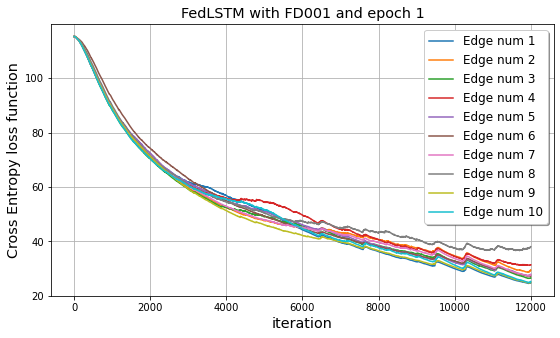

In [36]:
num_workers = 10
iteration_epoch = 3000
epoch = 1
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD001 and epoch 1", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD001_epoch_1: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_1/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD001_epoch_1))
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\alibei\AppData\Local\Temp/ipykernel_2796/4205547172.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


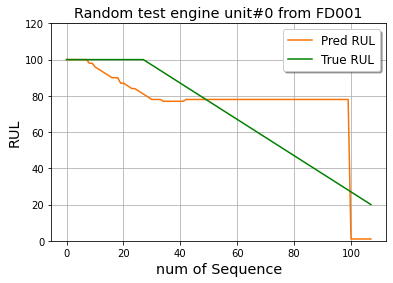

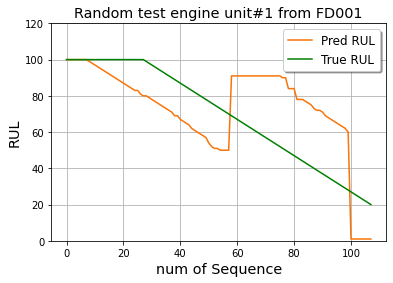

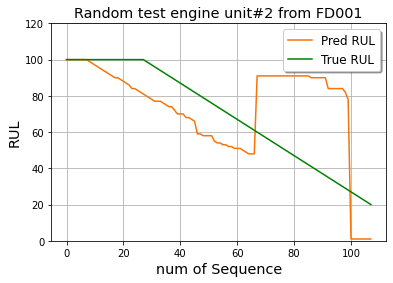

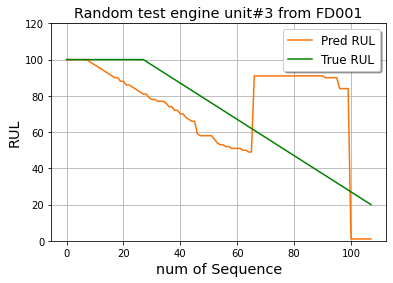

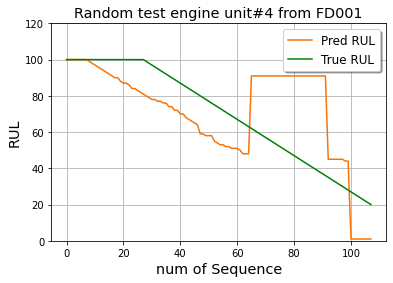

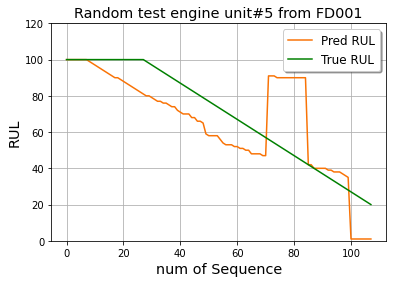

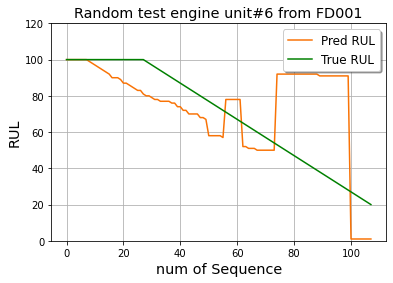

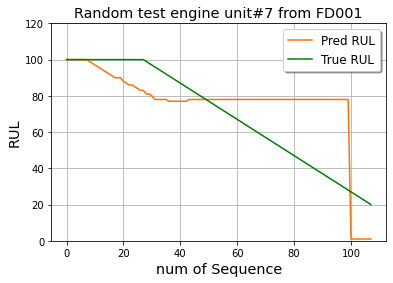

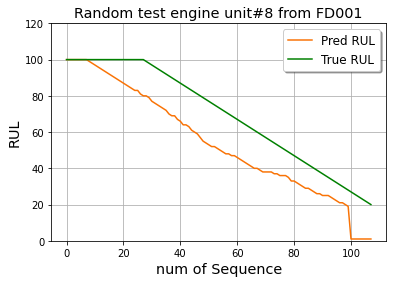

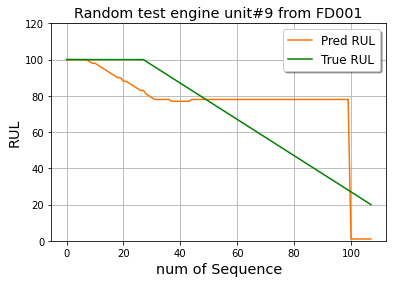

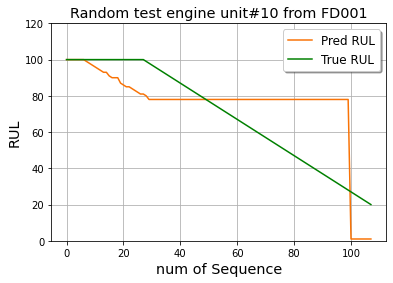

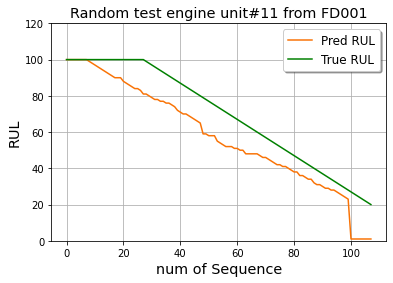

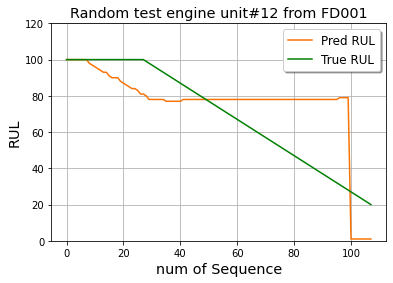

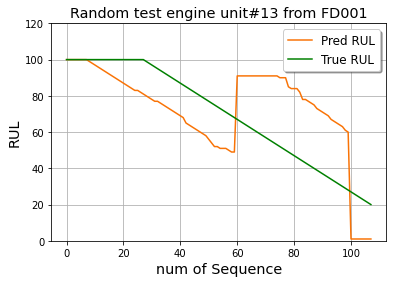

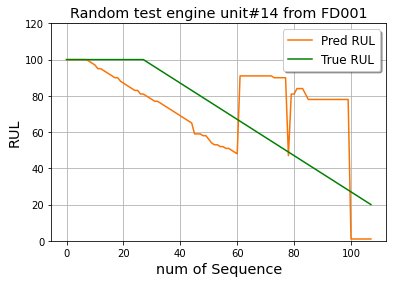

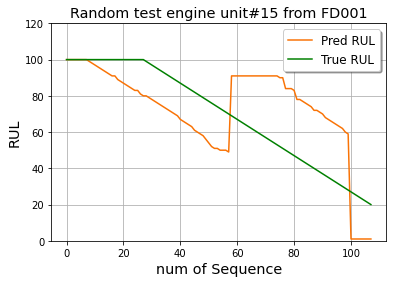

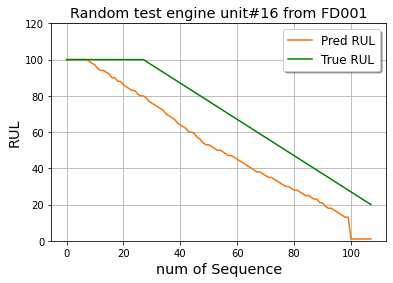

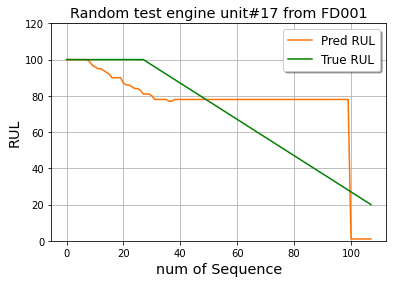

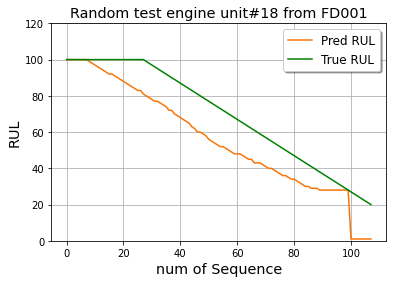

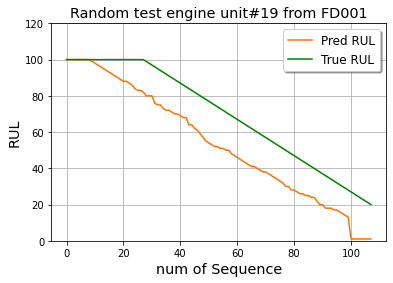

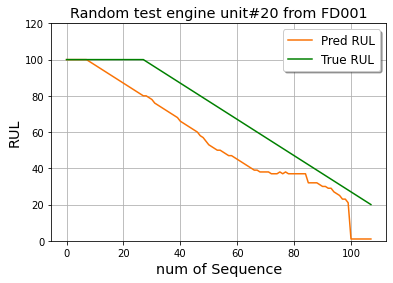

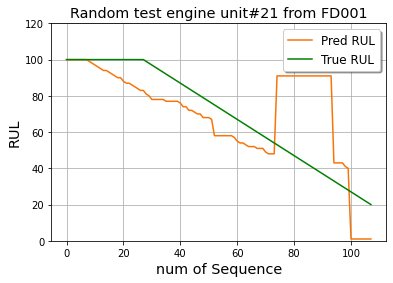

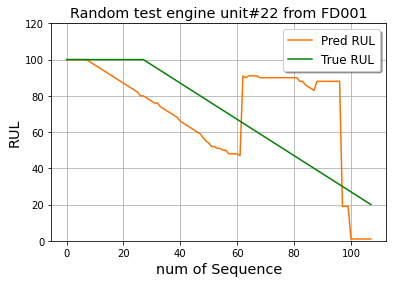

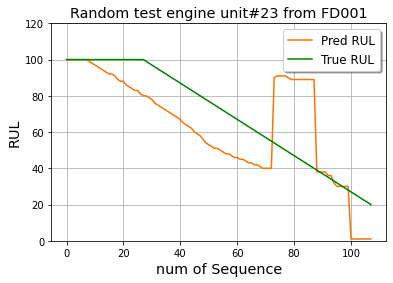

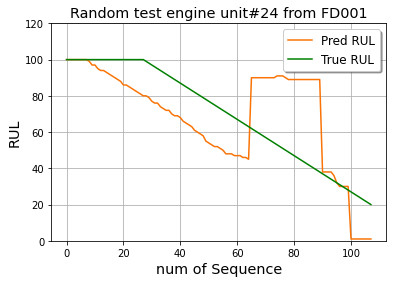

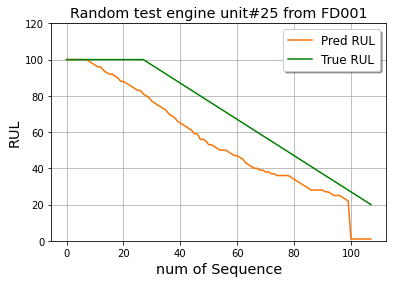

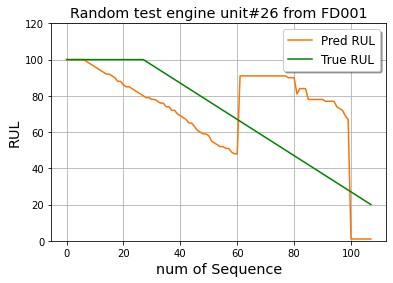

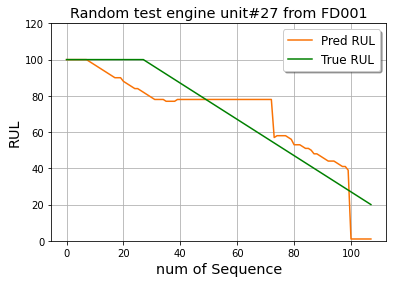

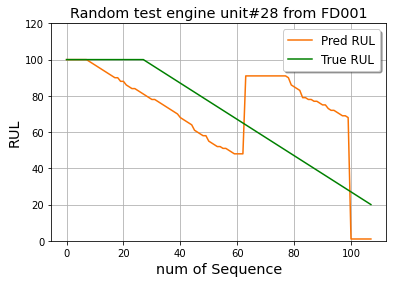

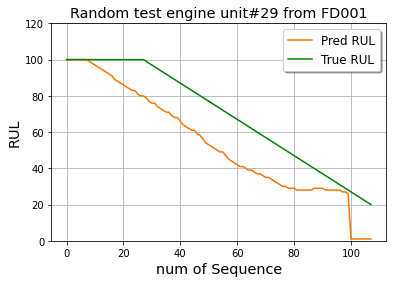

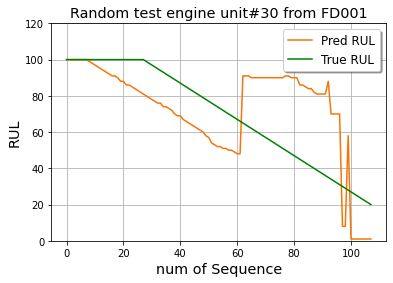

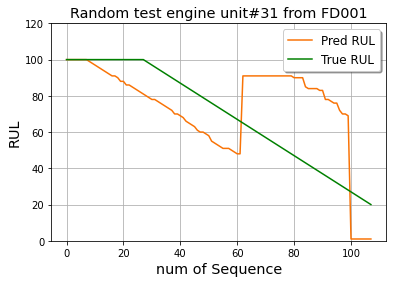

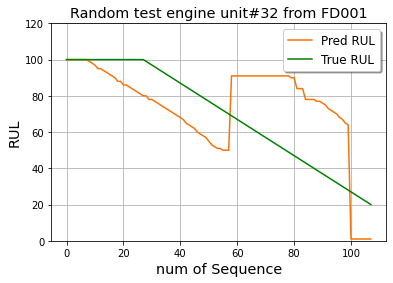

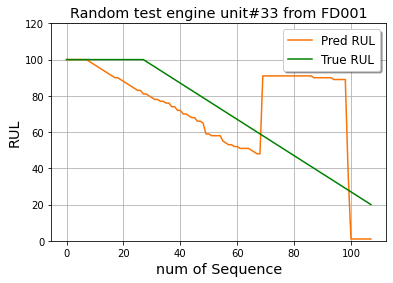

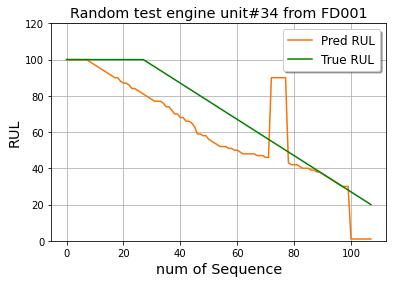

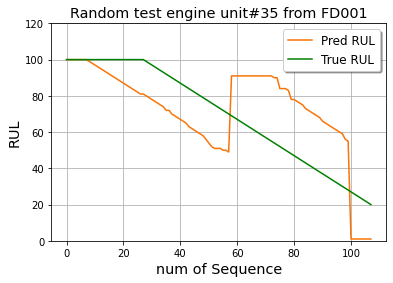

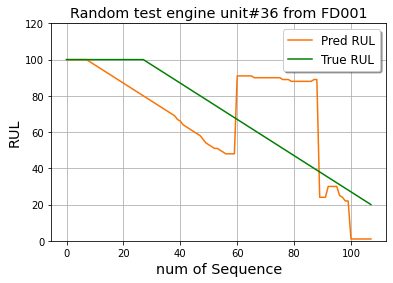

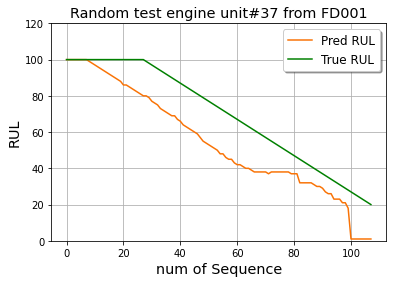

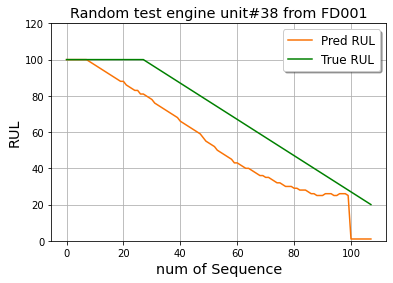

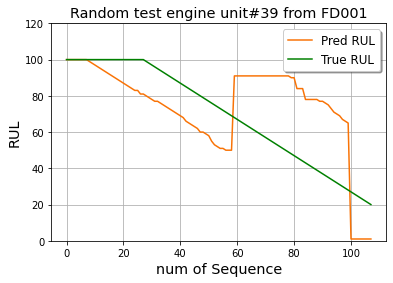

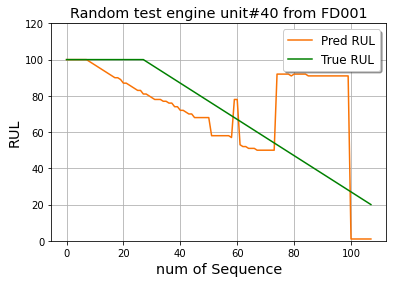

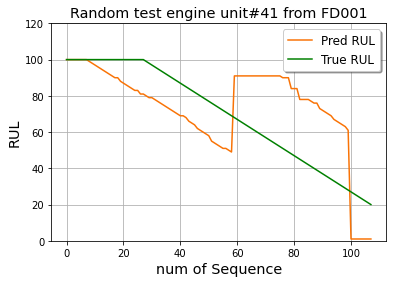

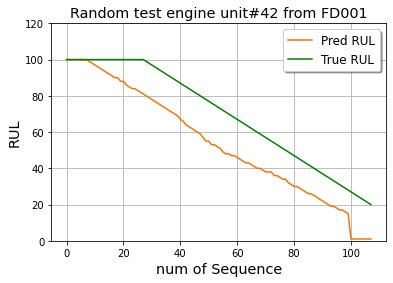

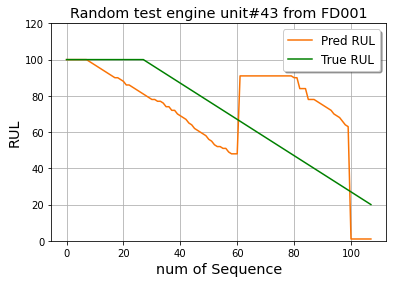

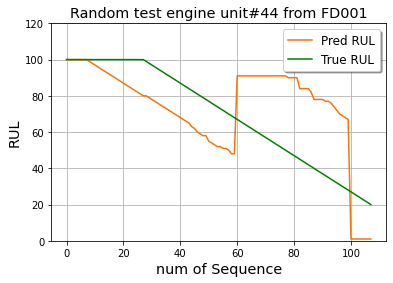

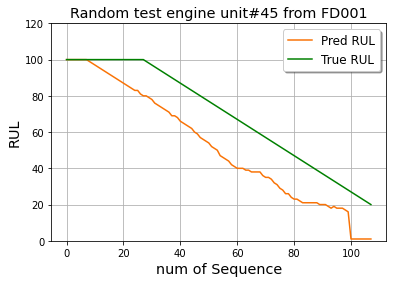

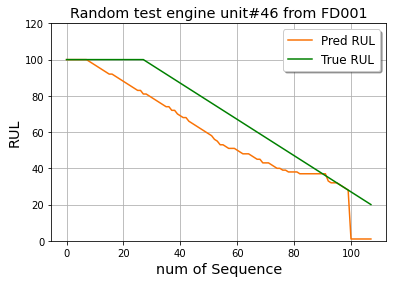

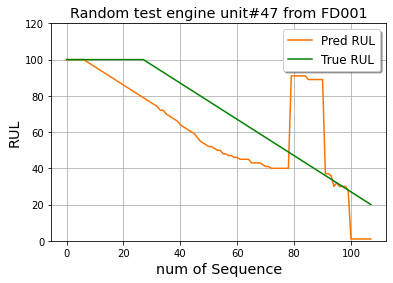

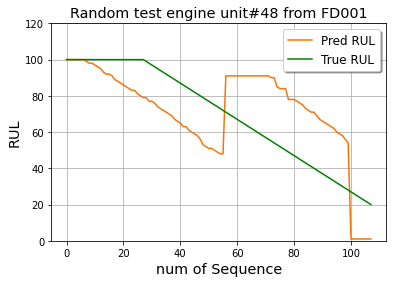

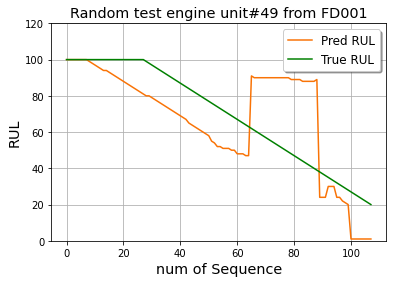

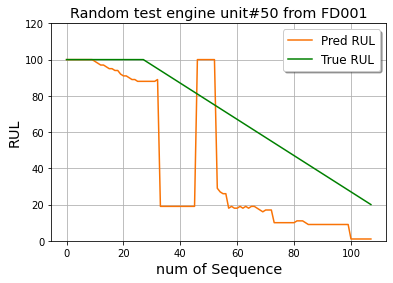

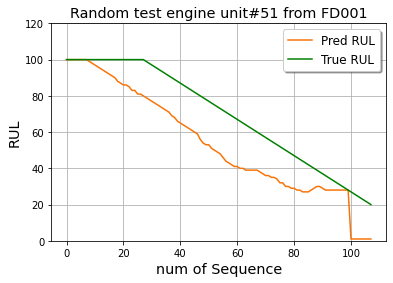

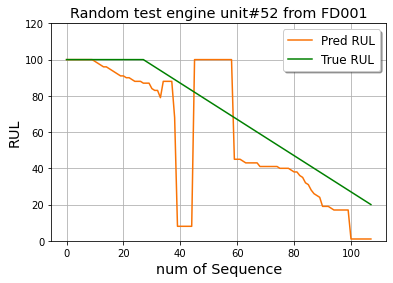

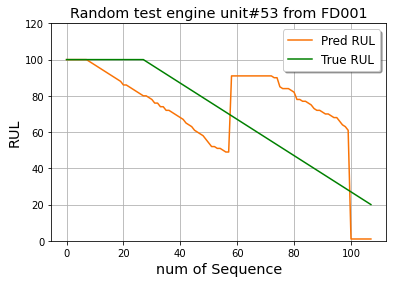

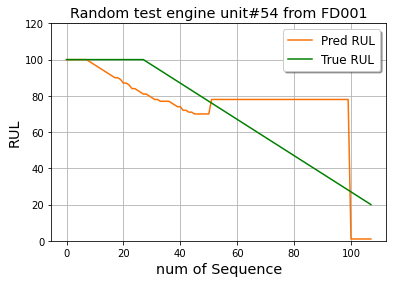

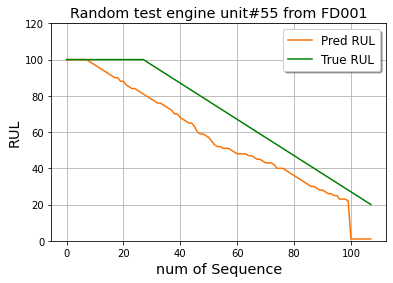

In [41]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD001", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name_epoch_4))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_04"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_04"+str(worker_i)+".png", format='png', dpi=1200)

In [42]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_1/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[16].savefig("FD001 RUL prediction with FedLSTM and epoch 1 for machine number_" + str(16) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[16].savefig("FD001 RUL prediction with FedLSTM and epoch 1 for machine number_" + str(16) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[26.67169618]


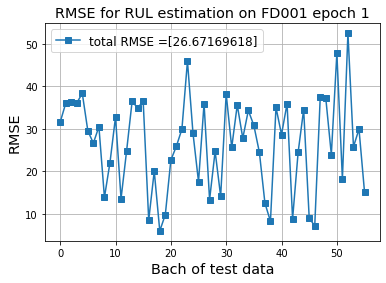

In [49]:
# RMSE and Scoring factor epoch 1
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

##################### delet out of range #############################
#RMSE = np.delete(RMSE,23)
#RMSE = np.delete(RMSE,50)
#RMSE = np.delete(RMSE,52)
#RMSE = np.delete(RMSE,4)
#RMSE = np.delete(RMSE,13)
#RMSE = np.delete(RMSE,15)
    
fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD001 epoch 1", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()

RMSE_epoch_1 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_1))
plt.legend(labels, loc='best', fontsize='large')


print(RMSE_epoch_1)
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_1/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 1.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 1.png", format='png', dpi=1200, bbox_inches='tight')

[-7.72838069e+01 -7.47571664e+01 -7.24512196e+01 -7.09277538e+01
 -7.33631437e+01 -4.02932231e+01  2.37675000e+03 -7.62274338e+01
 -6.17584488e+01 -4.33538314e+01 -7.74133305e+01 -5.97514094e+01
 -6.53143543e+01 -7.52940173e+01 -7.47349924e+01 -7.50673967e+01
 -4.64560965e+01  1.06454022e+01 -1.20169832e+01 -5.16474320e+01
 -7.66790364e+01  7.39076737e+03 -2.42417540e+01 -8.06415026e+01
  2.37954878e+01 -6.92403921e+01 -7.46145051e+01 -1.75864640e+01
  7.38506721e+02 -5.82721302e+01 -7.42033057e+01  3.08988408e+02
 -7.33542515e+01  3.90696513e+03 -7.67926640e+01 -7.43699231e+01
  5.69662980e+02 -5.47330502e+01 -3.38557162e+01 -7.34289555e+01
  1.82615928e+02 -7.44175476e+01 -4.70865911e+01  3.06601332e+02
 -7.34561707e+01 -4.71208746e+01 -2.30002017e+00 -5.58689585e+01
 -7.62690164e+01  5.54056424e+02 -7.32910863e+01 -6.85722799e+01
 -6.98242167e+01 -5.17268236e+01 -7.65974758e+01 -6.44851471e+01]
Final value for SCORE: 242.82523713757044


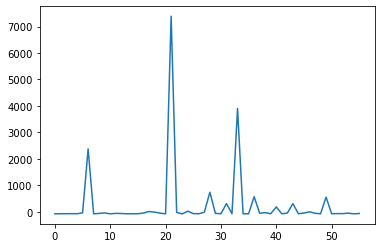

In [50]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

## Load Cost functions and Parameters

In [101]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD001_epoch_1: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_1/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD001_epoch_1 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD001_epoch_1 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_01.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[-0.18564977,  0.0322141 , -0.04818845, ..., -0.12048841,
         0.09804777,  0.05325   ],
       [-0.06109197,  0.09811411, -0.04168961, ...,  0.08114126,
         0.08047905,  0.05512676],
       [-0.12158022, -0.13627538, -0.17668155, ..., -0.20193493,
         0.20272957,  0.12999881],
       ...,
       [ 0.01255876,  0.16984161,  0.03624951, ..., -0.08108413,
         0.04121908,  0.00478767],
       [ 0.02036318,  0.06390896, -0.02934949, ...,  0.06846599,
         0.09238949,  0.08252651],
       [ 0.04791726,  0.01360442, -0.01159031, ...,  0.07645322,
         0.05202115,  0.05020851]]), 'bf': array([[1.05032015],
       [1.08373612],
       [1.08920687],
       [1.02828693],
       [1.0825476 ],
       [1.14573225],
       [1.04020056],
       [1.06803859],
       [1.07327751],
       [1.0113719 ],
       [1.0307025 ],
       [1.02641318],
       [1.07471422],
       [1.07047969],
       [1.10095669],
       [1.0111647 ],
       [1.06367949],
       [1.00765